In [1]:
its_jupyter_notebook = True

import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from tqdm.notebook import tqdm
from pathlib import Path
import argparse
import math
from scipy import stats
import copy
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable

sys.path.insert(0, '..')

from util.evaluation import obtain_enhn_easypos_smartneg, calc_corr_perf_conf, calc_corr_quality_perf, calc_corr_quality_conf, ModelResultsManager, calculate_correlations, balancing_only_for_one_task, obtain_all_model_auc, remove_outliers, map_thermodynamic_columns, obtain_df_auc, replace_outliers_with_nan_and_make_positive, obtain_sr_nosr, map_dataset_to_hp
from util.plot_utils import plot_correlations_QPC, plot_qualityVSconfidence, plot_metric_confidence_for_all_models_for_2tasks, plot_all_model_auc, perc_neg_npv_precision, collect_results_based_on_topbottom_for_all_models_perc_neg, npv_precision, plot_sr_distributions, plot_tnr_based_on_distance_for_our_model, collect_results_based_on_topbottom_for_all_models, plot_results_based_on_topbottom_for_all_models, plot_results_how_many_repeats_in_pred_pos_for_all_models, plot_metric_confidence_for_all_models, plot_tnr_based_on_distance_for_all_models, plot_confidence_based_on_distance_for_all_models, plot_tnr_for_all_models, quantile_bins, plot_features_vs_risearch2_confidence, plot_heatmap, plot_tnr_recall_for_all_models, plot_correlation_nreads_prob_intsize
from util.model_names_map import map_model_names

# %load_ext autoreload
# %autoreload 2

from config import *
from models.nt_classifier import build as build_model 
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
    
external_dataset_dir = os.path.join(dataset_files_dir, 'external_dataset', '200_test_tables')

<class 'transformers.tokenization_dna.DNATokenizer'>


In [2]:
model_name = 'arch2_PSORALENtrained_PARISval0074'#'arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0086' #'arch2_PSORALENtrained_PARISval0074' 
PARIS_FINETUNED_MODEL = True
SPLASH_TRAINED_MODEL = False
energy_columns = ['IntaRNA', 'priblast', 'RNAplex', 'rnacofold', 'assa', 'RNAhybrid', 'RNAup', 'risearch2']
list_of_HQ_datasets = ['parisHQ', 'paris_mouse_HQ', 'ricseqHQ']
list_of_datasets = list_of_HQ_datasets + ['psoralen', 'paris', 'paris_mouse', 'ricseq', 'mario', 'splash']

In [3]:
nt_models = [model_name]
list_of_models_to_test = ['nt'] + energy_columns + [f'nt{_}' for _ in range(1, len(nt_models))]

# TODO:

Controlla la classe, poi quando tutto funziona, modifica def _load_dataframes(self) usando il try except che c e dentro.

In [4]:
modelRM = ModelResultsManager(model_name = model_name, 
                            dimension = 200, 
                            chkpt_directory = os.path.join(ROOT_DIR, 'checkpoints'), 
                            rna_rna_files_dir = rna_rna_files_dir, 
                            test_info_directory = metadata_dir, 
                            other_tools = energy_columns, 
                            other_tools_dir = external_dataset_dir)

### Do the model correlate in their scores?

Sembra esserci una correlazione piu forte con la termodinamica su MOUSE e piu debole su HUMAN

DATASET: psoralen


<Figure size 720x576 with 0 Axes>

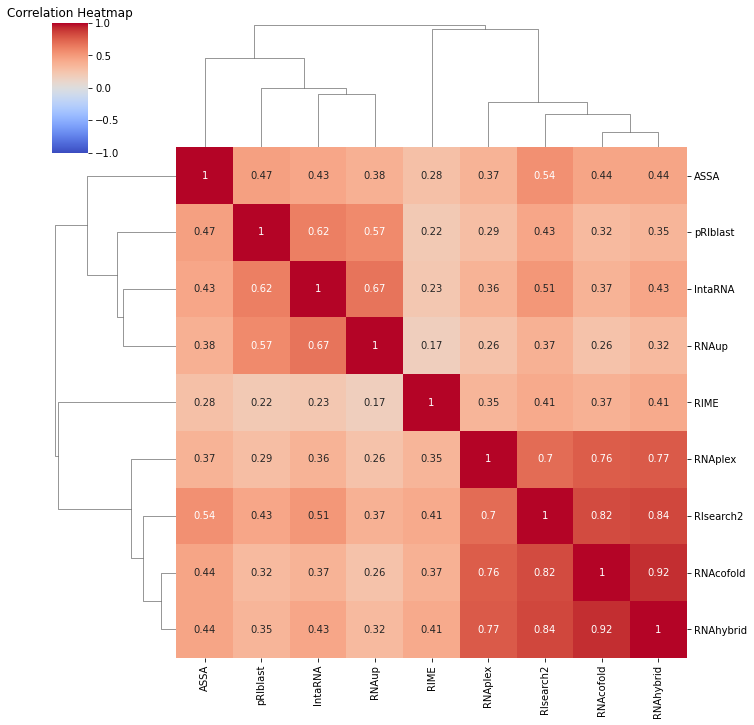

DATASET: ricseq


<Figure size 720x576 with 0 Axes>

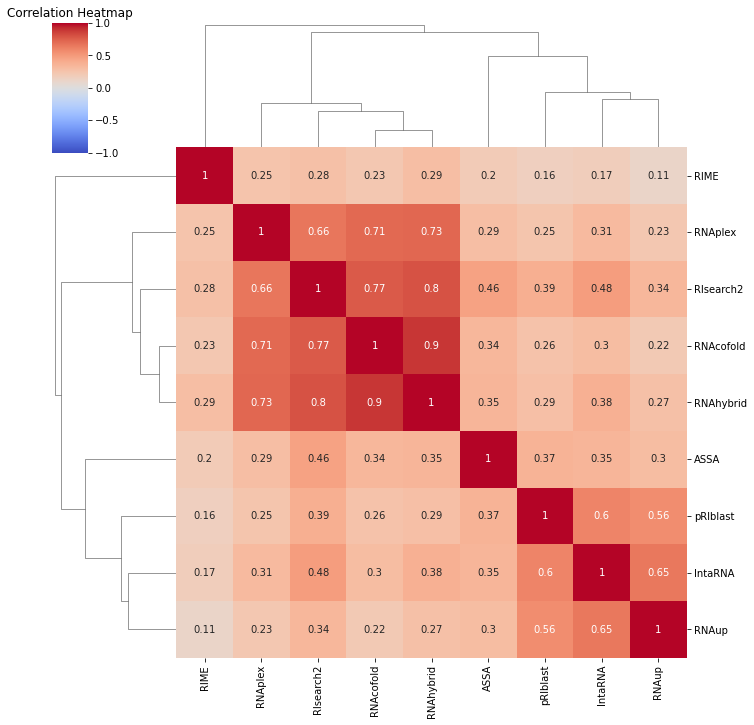

DATASET: mario


<Figure size 720x576 with 0 Axes>

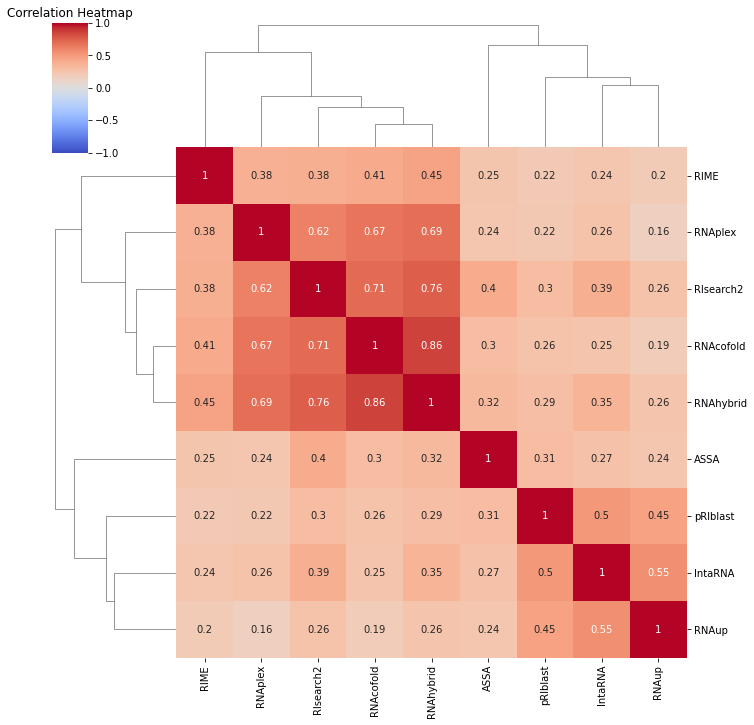

In [5]:
method='spearman' # 'pearson', 'spearman', 'kendall', 'mutual_info'
plot_each_correlation = False

for dataset in ['psoralen', 'ricseq', 'mario']: #psoralen
        
    experiment, specie_paris, _, _, _, _, _ = map_dataset_to_hp(dataset)
        
    res = modelRM.get_experiment_data(
        experiment = experiment, 
        paris_test = True, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = specie_paris,
        paris_hq = False,
        paris_hq_threshold = 1,
        n_reads_paris = 1,
        interlen_OR_nreads_paris = False,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = 1,
        logistic_regression_models = {},
    )

    for model_column in energy_columns:
        res[model_column] = -res[model_column] # make energy column positives, such that the correlations will be positives as well


    #res_for_corr = balancing_only_for_one_task(res, task = 'all')
    
    res_for_corr = res[res.ground_truth == 1]
    
    print(f'DATASET: {dataset}')
    
    #correlations = calculate_correlations([res_for_corr[i] for i in energy_columns + ['probability'] + [f'nt{_}' for _ in range(1, len(nt_models))]], method=method, plot=plot_each_correlation)
    correlations = calculate_correlations([res_for_corr[i] for i in ['probability'] + energy_columns + [f'nt{_}' for _ in range(1, len(nt_models))]], method=method, plot=plot_each_correlation)
    plot_heatmap(correlations, highlight_labels = map_model_names(energy_columns), method = method, savepath = os.path.join(plots_dir, f'correlation_heatmap_{dataset}.pdf'))

### Checks 

In [6]:
# for exp in ['test_HQ', 'test', 'mario', 'splash', 'ricseq',]:
    
#     if exp == 'test_HQ':
#         experiment = 'paris'
#         paris_hq = True
    
#     elif exp == 'test':
#         experiment = 'paris'
#         paris_hq = False
#     else:
#         experiment = exp
#         paris_hq = False
        
        
#     res = modelRM.get_experiment_data(
#                 experiment = experiment, 
#                 paris_test = True, 
#                 paris_finetuned_model = PARIS_FINETUNED_MODEL, 
#                 specie_paris = 'all',
#                 paris_hq = paris_hq,
#                 paris_hq_threshold = 1,
#                 n_reads_paris = 1,
#                 interlen_OR_nreads_paris = False,
#                 splash_trained_model = False,
#                 only_test_splash_ricseq_mario = False,
#                 n_reads_ricseq = 1,
#                 logistic_regression_models = {},
#     ) 
        
#     original_res = pd.read_csv( os.path.join(ROOT_DIR, 'checkpoints', model_name, f'{exp}_results200.csv'))
#     test500 = pd.read_csv(os.path.join(metadata_dir, f'{exp}200.csv'))
    
    
#     print(exp)
    
#     with open(os.path.join(rna_rna_files_dir, "gene_pairs_training.txt"), "rb") as fp:
#             couples_paris_training = pickle.load(fp)
#     original_res = original_res[~original_res.couples.isin(couples_paris_training)].reset_index(drop = True)
#     test500 = test500[~(test500.g1 + '_' + test500.g2).isin(couples_paris_training)].reset_index(drop = True)
    
#     assert test500.shape[0] == original_res.shape[0]
#     assert set(test500.couples) == set(original_res.id_sample) == set(res.id_sample)
#     assert set(original_res.merge(res, on = ['probability', 'id_sample']).id_sample) == set(original_res.id_sample)

#     cols_equal = list(set(test500.drop(['policy', 'g1', 'g2', 'couples'], axis = 1).columns).intersection(res.columns))
#     assert set(test500.merge(res.drop('couples', axis = 1), on = cols_equal).couples) == set(original_res.id_sample)

# Map models signal in [0, 1] and save the mapping

##### Train the model (we train with psoralen human)

In [7]:
res = modelRM.get_experiment_data(
    experiment = 'paris', 
    paris_test = True, 
    paris_finetuned_model = PARIS_FINETUNED_MODEL, 
    specie_paris = 'all',
    paris_hq = False,
    paris_hq_threshold = 1,
    n_reads_paris = 1,
    interlen_OR_nreads_paris = False,
    splash_trained_model = False,
    only_test_splash_ricseq_mario = False,
    n_reads_ricseq = np.nan,
    logistic_regression_models = {},
)

In [6]:
df_training = balancing_only_for_one_task(res, task = 'all').reset_index(drop = True)

In [100]:
logistic_regression_models = {}
for model_column in tqdm(energy_columns):
    
    
    df_s = df_training.copy()
    df_s = remove_outliers(df_s, model_column, threshold = 3)
    df_training = balancing_only_for_one_task(df_training, task = 'all').reset_index(drop = True)
    
    X_train, y_train = np.expand_dims(df_s[model_column], 1), np.array(df_s.ground_truth)
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Calculate threshold_value
    threshold_value = -model.intercept_ / model.coef_
    threshold_value = np.round(threshold_value[0][0], 2)

    logistic_regression_models[model_column] = {'intercept': model.intercept_[0], 
                                               'coef': model.coef_[0][0],
                                               'threshold_value': threshold_value}
    
    
#assa
logistic_regression_models['assa']['threshold_value'] = -0.05 # 
logistic_regression_models['assa']['coef'] = np.round(-logistic_regression_models['assa']['intercept'] / logistic_regression_models['assa']['coef'], 2)

#priblast
logistic_regression_models['priblast']['threshold_value'] = -0.05 # 
logistic_regression_models['priblast']['coef'] = np.round(-logistic_regression_models['priblast']['intercept'] / logistic_regression_models['priblast']['coef'], 2)


# # Open the file in binary write mode and serialize the dictionary
# with open(LR_MAPPING_PATH, 'wb') as file:
#     pickle.dump(logistic_regression_models, file)

  0%|          | 0/8 [00:00<?, ?it/s]

# Model comparison

In [5]:
with open(LR_MAPPING_PATH, 'rb') as file:
    logistic_regression_models = pickle.load(file)

### AUC

In [7]:
df_auc = obtain_df_auc(modelRM, PARIS_FINETUNED_MODEL, energy_columns, SPLASH_TRAINED_MODEL, list_of_datasets = list_of_datasets, logistic_regression_models = {} )

HQ_COLS = [
    'model_name', 
    'auc_interactors_parisHQ', 'auc_patches_parisHQ', 
    'auc_interactors_paris_mouse_HQ', 'auc_patches_paris_mouse_HQ',
    'auc_interactors_ricseqHQ', 'auc_patches_ricseqHQ'
]

SE_HQ_COLS = [
    'model_name', 
    'se_interactors_parisHQ', 'se_patches_parisHQ', 
    'se_interactors_paris_mouse_HQ', 'se_patches_paris_mouse_HQ',
    'se_interactors_ricseqHQ', 'se_patches_ricseqHQ'
]

OTHER = [
    'model_name', 
    'auc_interactors_psoralen', 'auc_patches_psoralen', 
    'auc_interactors_paris', 'auc_patches_paris', 
    'auc_interactors_paris_mouse', 'auc_patches_paris_mouse', 
    'auc_interactors_ricseq', 'auc_patches_ricseq', 'auc_interactors_mario', 
    'auc_patches_mario', 'auc_interactors_splash', 'auc_patches_splash'
]

  0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
df_auc.filter(HQ_COLS, axis = 1)

model_name  auc_interactors_parisHQ  auc_patches_parisHQ  \
0       RIME                     0.72                 0.77   
1    IntaRNA                     0.57                 0.60   
2   pRIblast                     0.55                 0.57   
3    RNAplex                     0.54                 0.57   
4  RNAcofold                     0.51                 0.54   
5       ASSA                     0.53                 0.55   
6  RNAhybrid                     0.55                 0.59   
7      RNAup                     0.55                 0.57   
8  RIsearch2                     0.58                 0.62   

   auc_interactors_paris_mouse_HQ  auc_patches_paris_mouse_HQ  \
0                            0.62                        0.76   
1                            0.59                        0.63   
2                            0.56                        0.60   
3                            0.60                        0.68   
4                            0.54                        0.64   
5                            0.56                        0.59   
6                            0.59                        0.67   
7                            0.58                        0.61   
8                            0.62                        0.70   

   auc_interactors_ricseqHQ  auc_patches_ricseqHQ  
0                      0.70                  0.77  
1                      0.54                  0.58  
2                      0.54                  0.56  
3                      0.57                  0.60  
4                      0.55                  0.59  
5                      0.57                  0.58  
6                      0.61                  0.65  
7                      0.50                  0.53  
8                      0.61                  0.66

In [9]:
df_auc.filter(OTHER, axis = 1)

model_name  auc_interactors_psoralen  auc_patches_psoralen  \
0       RIME                      0.58                  0.68   
1    IntaRNA                      0.55                  0.59   
2   pRIblast                      0.54                  0.56   
3    RNAplex                      0.53                  0.57   
4  RNAcofold                      0.52                  0.57   
5       ASSA                      0.53                  0.55   
6  RNAhybrid                      0.53                  0.59   
7      RNAup                      0.54                  0.57   
8  RIsearch2                      0.55                  0.60   

   auc_interactors_paris  auc_patches_paris  auc_interactors_paris_mouse  \
0                   0.58               0.67                         0.54   
1                   0.53               0.57                         0.55   
2                   0.52               0.55                         0.53   
3                   0.53               0.57                         0.53   
4                   0.52               0.57                         0.52   
5                   0.52               0.54                         0.52   
6                   0.53               0.58                         0.53   
7                   0.53               0.55                         0.54   
8                   0.54               0.59                         0.54   

   auc_patches_paris_mouse  auc_interactors_ricseq  auc_patches_ricseq  \
0                     0.69                    0.54                0.63   
1                     0.59                    0.58                0.61   
2                     0.56                    0.55                0.58   
3                     0.60                    0.51                0.56   
4                     0.61                    0.50                0.54   
5                     0.55                    0.54                0.55   
6                     0.61                    0.52                0.57   
7                     0.56                    0.56                0.60   
8                     0.62                    0.55                0.60   

   auc_interactors_mario  auc_patches_mario  auc_interactors_splash  \
0                   0.48               0.65                    0.68   
1                   0.47               0.54                    0.80   
2                   0.49               0.52                    0.76   
3                   0.50               0.64                    0.53   
4                   0.49               0.68                    0.57   
5                   0.50               0.52                    0.74   
6                   0.50               0.67                    0.59   
7                   0.48               0.54                    0.77   
8                   0.49               0.64                    0.72   

   auc_patches_splash  
0                0.83  
1                0.87  
2                0.82  
3                0.60  
4                0.63  
5                0.78  
6                0.67  
7                0.82  
8                0.79

dataset: parisHQ
# of positive samples:  424


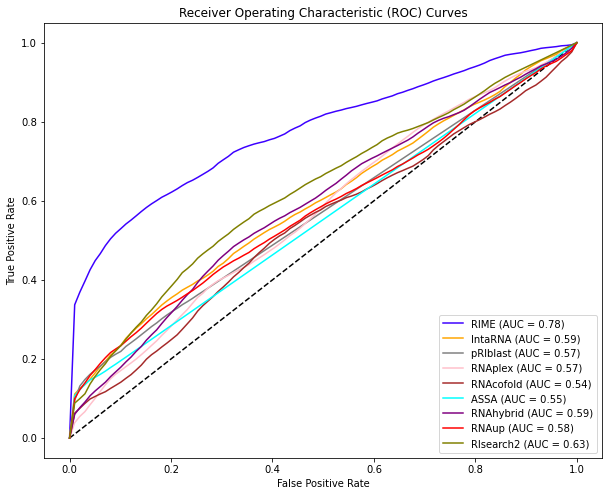

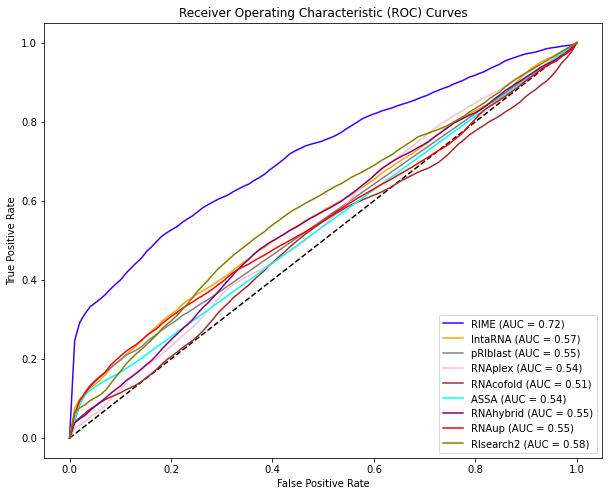

dataset: paris_mouse_HQ
# of positive samples:  82


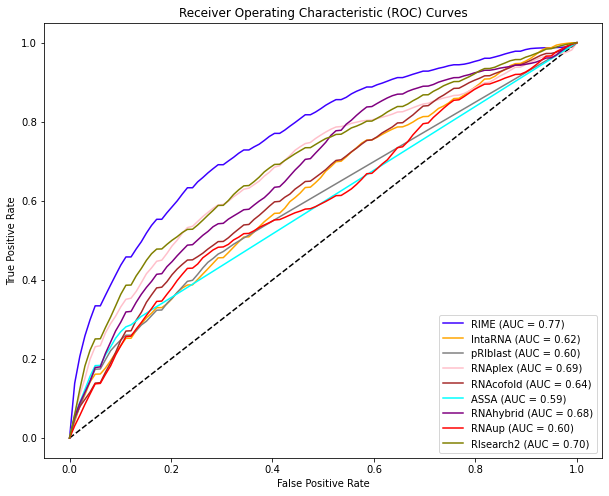

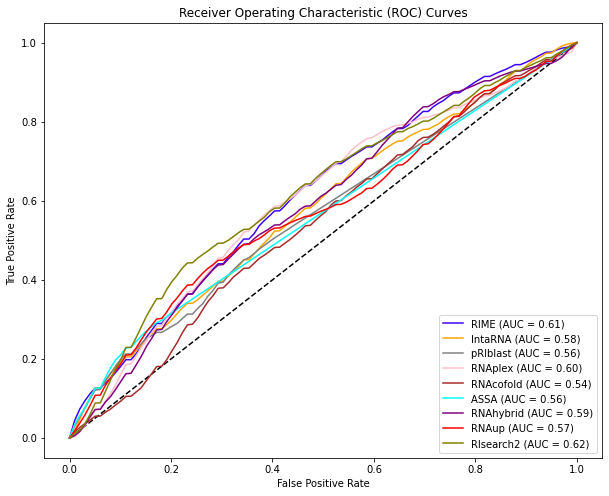

dataset: ricseqHQ
# of positive samples:  161


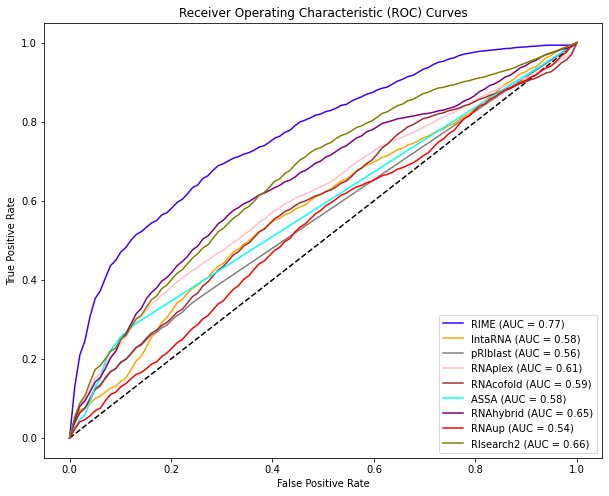

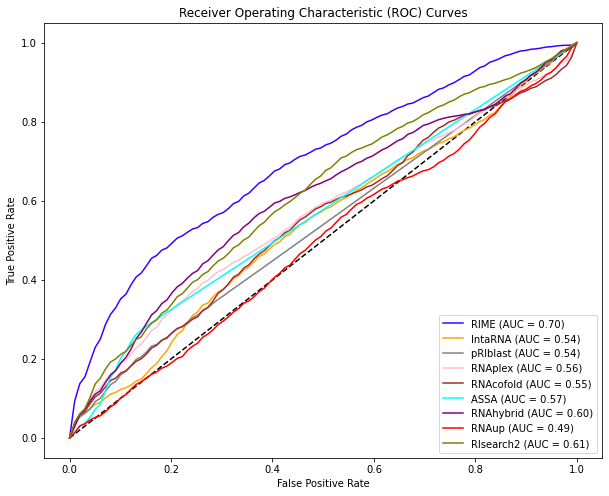

In [39]:
for dataset in list_of_HQ_datasets:
    
    experiment, specie_paris, paris_hq_threshold, n_reads_ricseq, n_reads_paris, interlen_OR_nreads_paris, paris_test = map_dataset_to_hp(dataset)
    res = modelRM.get_experiment_data(
        experiment = experiment, 
        paris_test = paris_test, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = specie_paris,
        paris_hq = False,
        paris_hq_threshold = paris_hq_threshold,
        n_reads_paris = n_reads_paris,
        interlen_OR_nreads_paris = interlen_OR_nreads_paris,
        splash_trained_model = SPLASH_TRAINED_MODEL,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = n_reads_ricseq,
        logistic_regression_models = logistic_regression_models,
    )
     
    print(f'dataset: {dataset}')
    
    print('# of positive samples: ', res[res.policy=='easypos'].shape[0])
    
    plot_all_model_auc(res[res.policy.isin(['easypos', 'easyneg', 'hardneg'])].reset_index(drop = True), energy_columns, savepath = os.path.join(plots_dir, f'AUC_DRP_{dataset}.pdf'))
    plot_all_model_auc(res[res.policy.isin(['easypos', 'smartneg'])].reset_index(drop = True), energy_columns, savepath = os.path.join(plots_dir, f'AUC_DRI_{dataset}.pdf'))

In [10]:
# TO CHECK THAT IT'S WORKING THE MAPPING
# df_auc2 = obtain_df_auc(modelRM, energy_columns, list_of_datasets = list_of_datasets, logistic_regression_models = logistic_regression_models )
# errors = df_auc.filter(OTHER, axis = 1).drop('model_name', axis =1 ) - df_auc2.filter(OTHER, axis = 1).drop('model_name', axis =1 )
# errors['model_name'] = df_auc['model_name']
# errors

### Repeats enrichment

In [11]:
#analysis args
feature_to_search_name = 'Simple Repeat' #'Simple_repeat', 'Low_complexity'
list_of_feature_to_search = ['Simple_repeat', 'Low_complexity']


full_overlap = False
if full_overlap:
    suffix = 'full_'
else:
    suffix = ''
    
both_sr_condition = True

In [12]:
#kde plot args
figsize_kde = (7, 4)

#treshold plot args
figsize_treshold = (17,9)
MIN_PERC = 2
n_values = 12
size_multiplier = 0
n_run_undersampling = 15
list_of_metrics = ['precision_recall_curve']
plot_function = plot_results_based_on_topbottom_for_all_models

##############   ##############   ##############   ##############   ##############
---------- DATASET: psoralen ----------
Simple Repeat are the 1.3595312854044606  % of the total couples
No Simple Repeat are the 81.97326255138705  % of the total couples
0.6373305666803393
0.4866238329840966


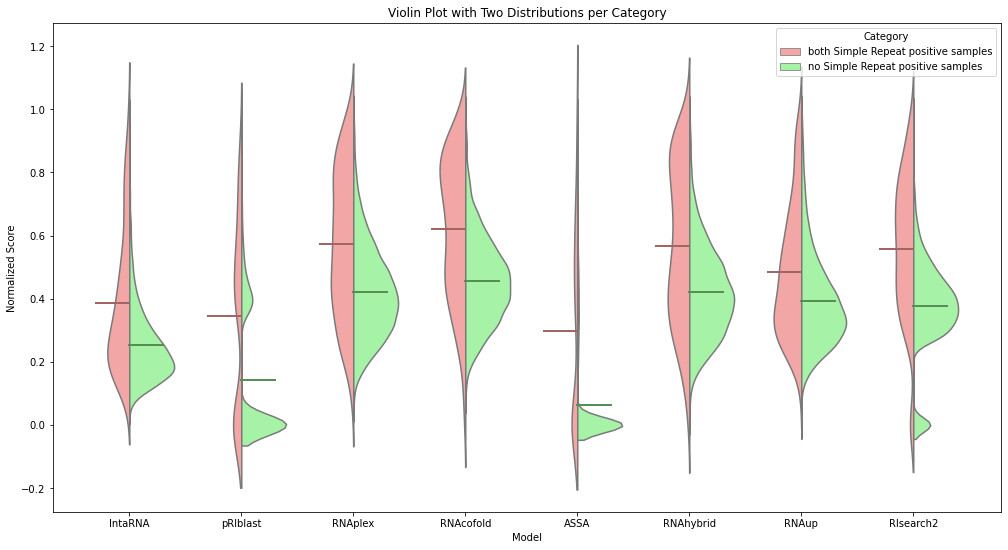




##############   ##############   ##############   ##############   ##############
---------- DATASET: ricseq ----------
Simple Repeat are the 0.7008244994110718  % of the total couples
No Simple Repeat are the 85.39458186101295  % of the total couples
0.5184116519111044
0.45206057288591245


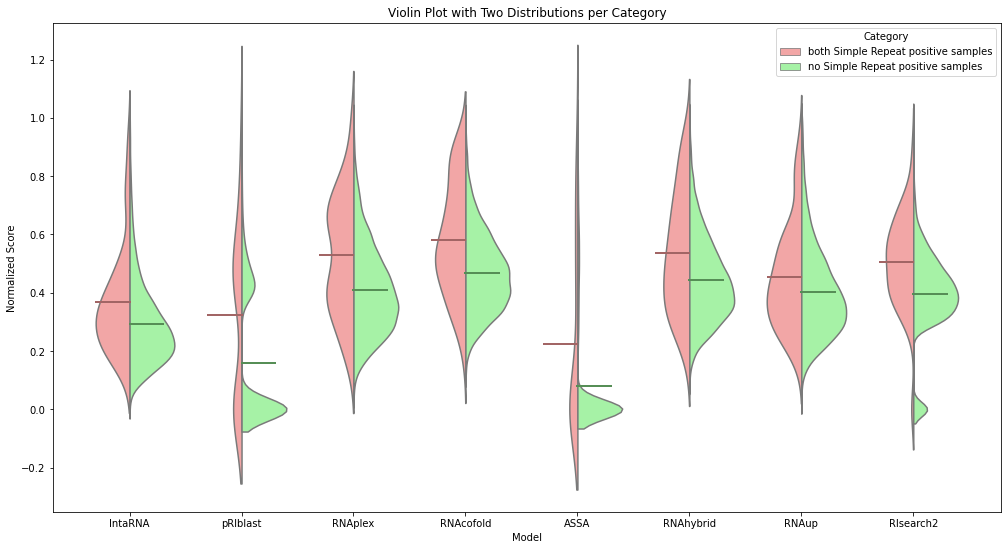




##############   ##############   ##############   ##############   ##############
---------- DATASET: mario ----------
Simple Repeat are the 0.353045013239188  % of the total couples
No Simple Repeat are the 86.40776699029125  % of the total couples
0.5832410454750061
0.46454131313496166


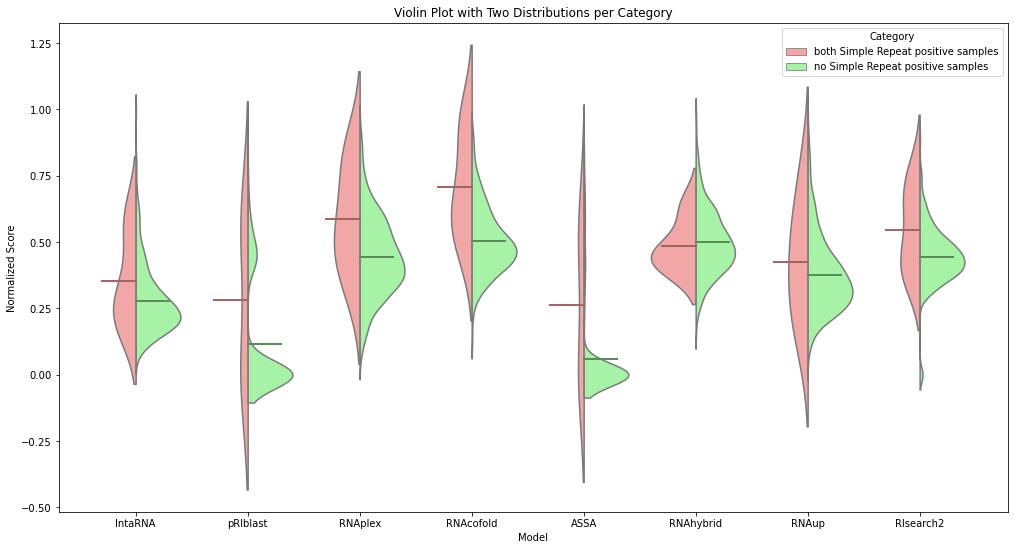

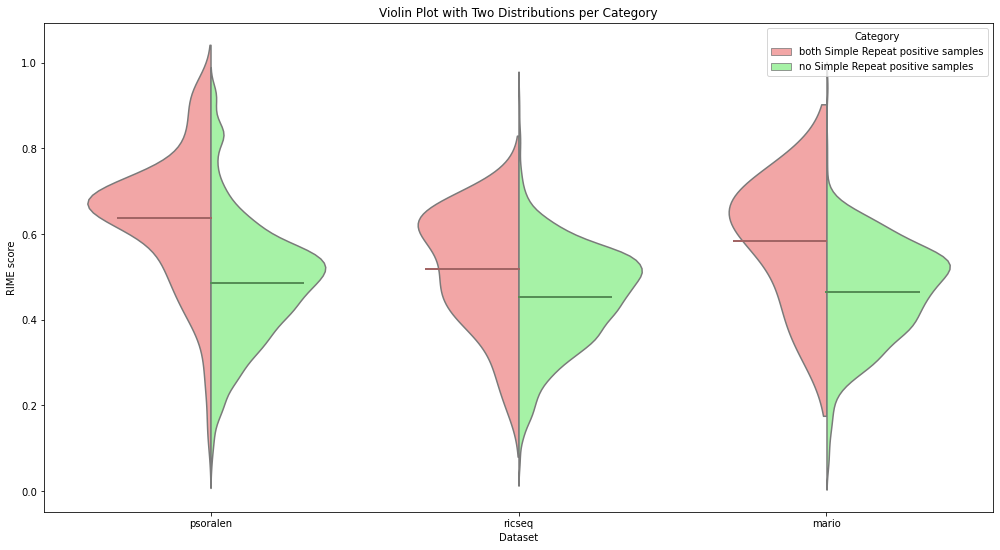

In [13]:
df_sr_only_rime = []
for dataset in ['psoralen', 'ricseq', 'mario']: #'paris_mouse',
    print(f'##############   ##############   ##############   ##############   ##############')
    print(f'---------- DATASET: {dataset} ----------')
    
    
    experiment, specie_paris, _, _, _, _, _ = map_dataset_to_hp(dataset)
        
    res = modelRM.get_experiment_data(
        experiment = experiment, 
        paris_test = True, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = specie_paris,
        paris_hq = False,
        paris_hq_threshold = 1,
        n_reads_paris = 1,
        interlen_OR_nreads_paris = False,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = 1,
        logistic_regression_models = {},
    )
    
    res = replace_outliers_with_nan_and_make_positive(res, energy_columns)
    
    #normalize after we removed outliers
    for model_column in energy_columns:
        res[model_column] = (res[model_column]-res[model_column].min())/(res[model_column].max()-res[model_column].min())
    
    res['simple_repeat1'] = res[f'{suffix}feature1'].apply(lambda x: any(f in x for f in list_of_feature_to_search))
    res['simple_repeat2'] = res[f'{suffix}feature2'].apply(lambda x: any(f in x for f in list_of_feature_to_search))
    res['none1'] = res[f'{suffix}feature1'].apply(lambda x: 'None' in x)
    res['none2'] = res[f'{suffix}feature2'].apply(lambda x: 'None' in x)
    
    filtered_policies = ['easypos', 'smartneg']
    sr, no_sr = obtain_sr_nosr(res, both_sr_condition, filtered_policies)
    N_total_couples = len(set(res[res.policy.isin(filtered_policies)].id_sample))
    print(f'{feature_to_search_name} are the {len(set(sr.id_sample)) /  N_total_couples * 100}  % of the total couples')
    print(f'No {feature_to_search_name} are the {len(set(no_sr.id_sample)) /  N_total_couples * 100}  % of the total couples')

    if len(set(sr.id_sample))>0:

        sr_ep = sr[sr.policy == 'easypos'].reset_index(drop = True)
        sr_sn = sr[sr.policy == 'smartneg'].reset_index(drop = True)

        no_sr_ep = no_sr[no_sr.policy == 'easypos'].reset_index(drop = True)
        no_sr_sn = no_sr[no_sr.policy == 'smartneg'].reset_index(drop = True)


        df_sr = []
        for column in (['probability'] + energy_columns):

            if both_sr_condition:
                label_x = f'both {feature_to_search_name} positive samples'
            else:
                label_x = f'at least {feature_to_search_name} positive samples'

            x, y = sr_ep[column], no_sr_ep[column]

            df_model = pd.DataFrame({
                    'Model': [column] * (len(x) + len(y)),
                    'Category': pd.concat([
                        pd.Series([label_x] * len(x)), 
                        pd.Series([f'no {feature_to_search_name} positive samples'] * len(y))
                    ]),
                    'Normalized Score': pd.concat([x, y])
                })

            df_sr.append(df_model)

            if column == 'probability':
                df_model = df_model.copy()
                df_model['Dataset'] = dataset
                df_sr_only_rime.append(df_model)

        df_sr = pd.concat(df_sr)

        both_sr = 'both_sr' if both_sr_condition else 'one_sr'
        
        print(df_sr[(df_sr['Model'] == 'probability')&(df_sr['Category'] ==f'both {feature_to_search_name} positive samples')]['Normalized Score'].mean())
        print(df_sr[(df_sr['Model'] == 'probability')&(df_sr['Category'] ==f'no {feature_to_search_name} positive samples')]['Normalized Score'].mean())
        
        df_sr = df_sr[~(df_sr.Model == 'probability')].reset_index(drop = True) #only_thermodynamics

        plot_sr_distributions(df_sr, label_x, figsize = figsize_treshold, savepath = os.path.join(plots_dir, f'{feature_to_search_name}_{suffix}_{both_sr}_{dataset}_thermodynamics.pdf'))

        print('\n\n')
    
df_sr_only_rime = pd.concat(df_sr_only_rime)
plot_sr_distributions(df_sr_only_rime, label_x, label_y_name = 'RIME score', column = 'Dataset', figsize = figsize_treshold, savepath = os.path.join(plots_dir, f'{feature_to_search_name}_{suffix}_{both_sr}_{MODEL_NAME}_alldatasets.pdf'))


### To see how it works in predicting Simple Repeat cases, but also whats the percentage of SR at high confidence

In [58]:
# for dataset in list_of_datasets:
#     print(f'##############   ##############   ##############   ##############   ##############')
#     print(f'---------- DATASET: {dataset} ----------')

#     experiment, specie_paris, paris_hq_threshold, n_reads_ricseq, n_reads_paris, interlen_OR_nreads_paris, paris_test = map_dataset_to_hp(dataset)
        
#     res = modelRM.get_experiment_data(
#         experiment = experiment, 
#         paris_test = paris_test, 
#         paris_finetuned_model = PARIS_FINETUNED_MODEL, 
#         specie_paris = specie_paris,
#         paris_hq = paris_hq_threshold,
#         paris_hq_threshold = 1,
#         n_reads_paris = n_reads_paris,
#         interlen_OR_nreads_paris = False,
#         splash_trained_model = False,
#         only_test_splash_ricseq_mario = False,
#         n_reads_ricseq = n_reads_ricseq,
#         logistic_regression_models = logistic_regression_models,
#     )

#     res['simple_repeat1'] = res[f'{suffix}feature1'].apply(lambda x: feature_to_search in x)
#     res['simple_repeat2'] = res[f'{suffix}feature2'].apply(lambda x: feature_to_search in x)
#     res['none1'] = res[f'{suffix}feature1'].apply(lambda x: 'None' in x)
#     res['none2'] = res[f'{suffix}feature2'].apply(lambda x: feature_to_search in x)

#     filtered_policies = ['easypos', 'smartneg']
#     sr, no_sr = obtain_sr_nosr(res, both_sr_condition, filtered_policies)
#     N_total_couples = len(set(res[res.policy.isin(filtered_policies)].id_sample))
#     print(f'{feature_to_search} are the {len(set(sr.id_sample)) /  N_total_couples * 100}  % of the total couples')
#     print(f'No {feature_to_search} are the {len(set(no_sr.id_sample)) /  N_total_couples * 100}  % of the total couples')

#     sr_ep = sr[sr.policy == 'easypos'].reset_index(drop = True)
#     sr_sn = sr[sr.policy == 'smartneg'].reset_index(drop = True)

#     no_sr_ep = no_sr[no_sr.policy == 'easypos'].reset_index(drop = True)
#     no_sr_sn = no_sr[no_sr.policy == 'smartneg'].reset_index(drop = True)

#     ##################### ##################### TRESHOLD PLOTS ##################### #####################
        
#     for metric in list_of_metrics:
    
#         for task in tasks_treshold:
#             print(f'           -- -- -- {task} -- -- -- ')
#             print(f'           -  -  -  {metric}  -  -  - ')

#             if task == 'simple_repeat_EPSN':
#                 assert len(sr.ground_truth.value_counts().index) == 2
#                 subset_to_plot = sr.reset_index(drop = True)
#             elif task == 'no_simple_repeat_EPSN':
#                 assert len(no_sr.ground_truth.value_counts().index) == 2
#                 subset_to_plot = no_sr.reset_index(drop = True)

#             plt.figure(figsize=figsize_treshold)
#             plot_function(subset_to_plot, MIN_PERC = MIN_PERC, 
#                           list_of_models_to_test = ['probability'] + energy_columns, 
#                           n_values = n_values, n_run_undersampling = n_run_undersampling, 
#                           metric = metric, task_name = task, 
#                           size_multiplier = size_multiplier#, balance_predictions_at_each_step = True
#                          )
#             plt.show()
            
#     print('\n\n')
    
#     ##################### ##################### REPEATS IN POSITIVE PREDICTIONS ##################### #####################
#     #Percentage of SR in positive predictions based on model Confidence Levels (questo prende in considerazione tutti i positivi, e vediamo se all aumentare del livello di confidenza predilige le repeats)
#     print('EASYPOS Percentage of SR in positive predictions based on model Confidence Levels')
#     plt.figure(figsize=figsize_treshold)
#     plot_results_how_many_repeats_in_pred_pos_for_all_models(res[res.policy == 'easypos'].reset_index(drop = True),
#                                                              MIN_PERC, ['probability'] + energy_columns, n_values = n_values, both_sr = both_sr_condition, feature_to_search = feature_to_search
#                                                             )
#     print('SMARTNEG Percentage of SR in positive predictions based on model Confidence Levels')
#     plt.figure(figsize=figsize_treshold)
#     plot_results_how_many_repeats_in_pred_pos_for_all_models(res[res.policy == 'smartneg'].reset_index(drop = True),
#                                                              MIN_PERC, ['probability'] + energy_columns, n_values = n_values, both_sr = both_sr_condition, feature_to_search = feature_to_search
#                                                             ) #these are errors
    
    
#     print('\n\n')

### Patches task depend on the distance from the interaction site, and on the presence of interacting regions inside the embedding

A notable feature of our method is its growing confidence in predicting negatives as the distance to interaction regions in the embeddings increases. Essentially, the model's confidence and its ability to accurately identify HNW and ENW improve when interaction regions are more distant within the embeddings.

---------- DATASET: parisHQ ----------


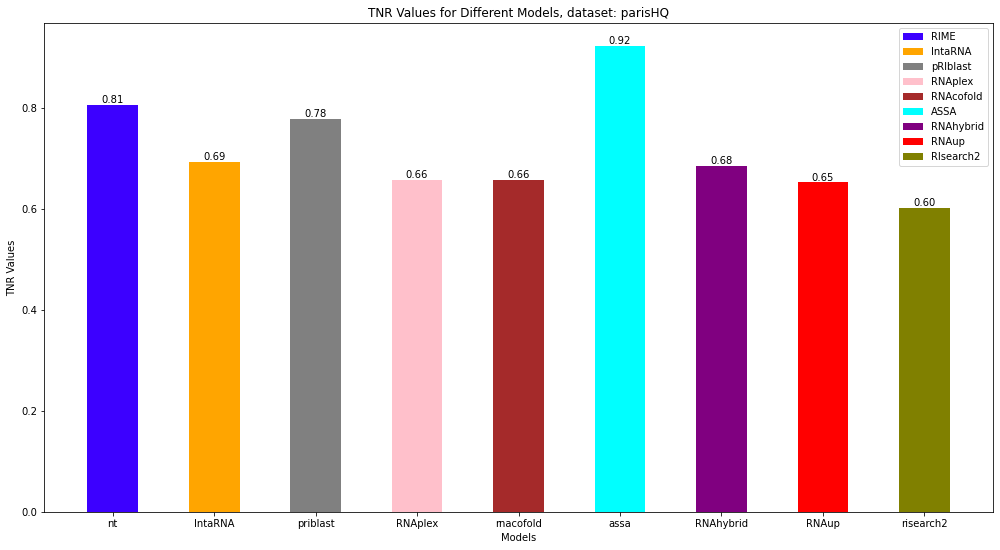

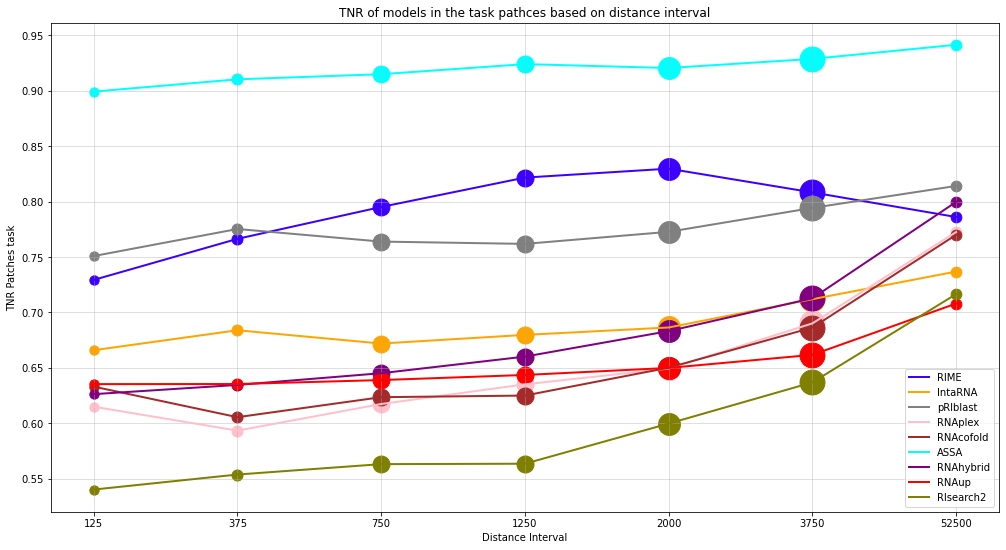

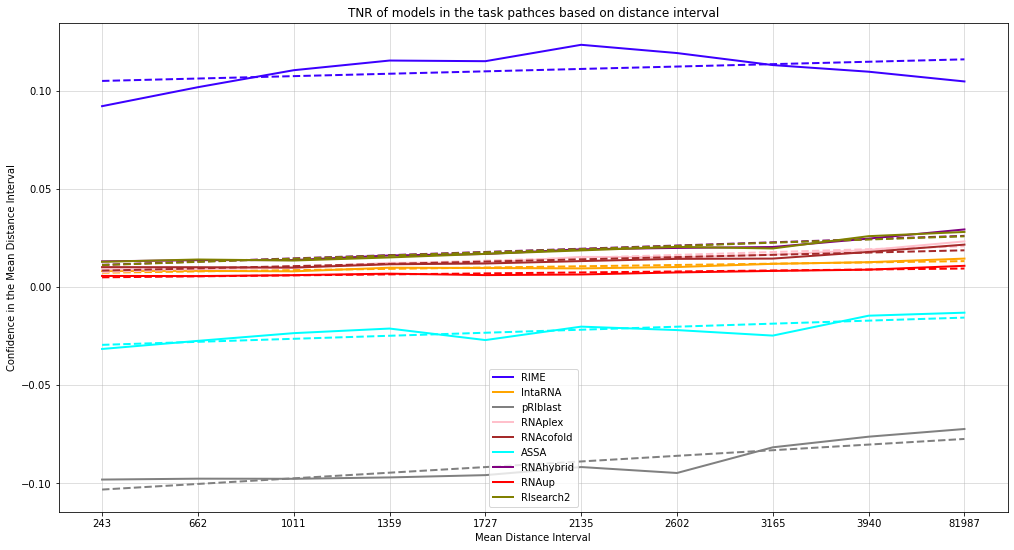

---------- DATASET: paris_mouse_HQ ----------


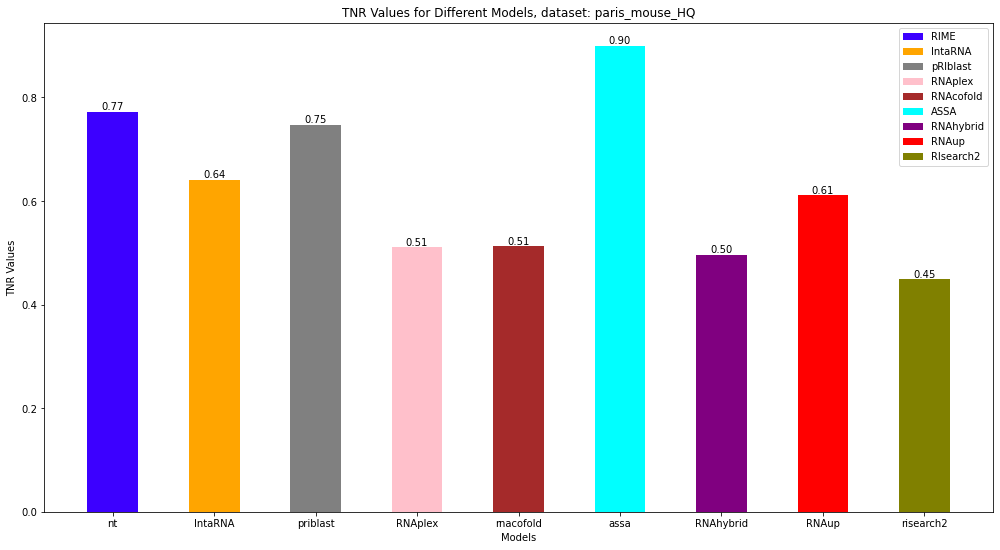

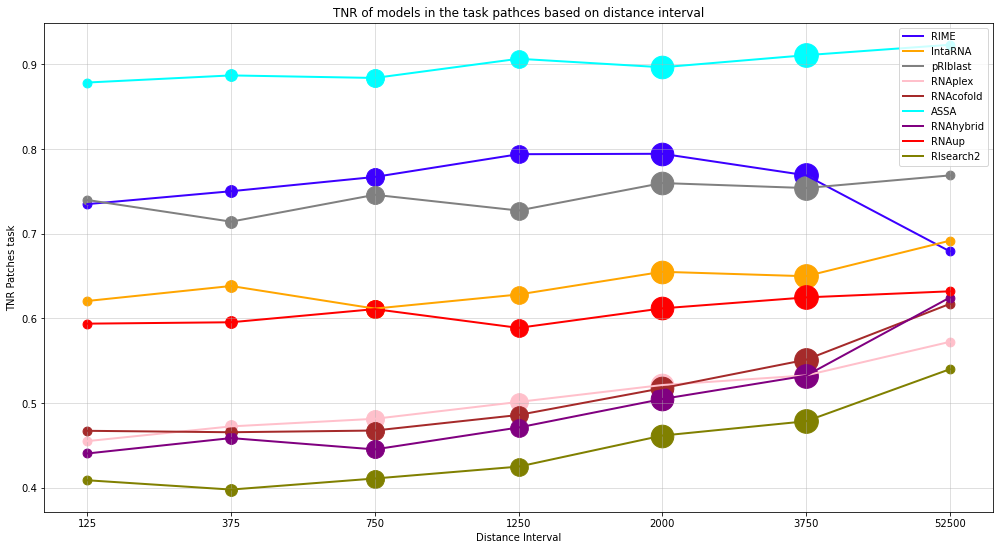

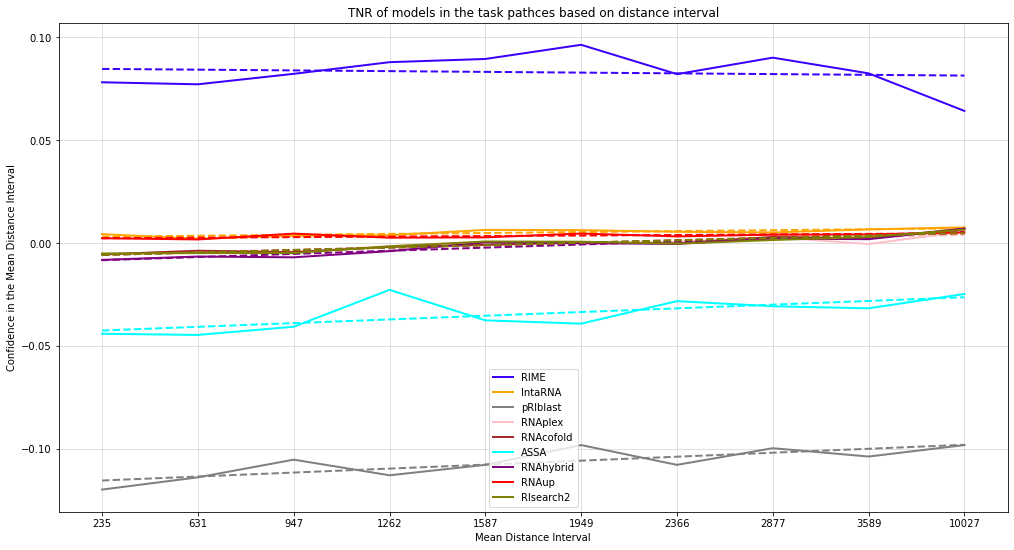

---------- DATASET: ricseqHQ ----------


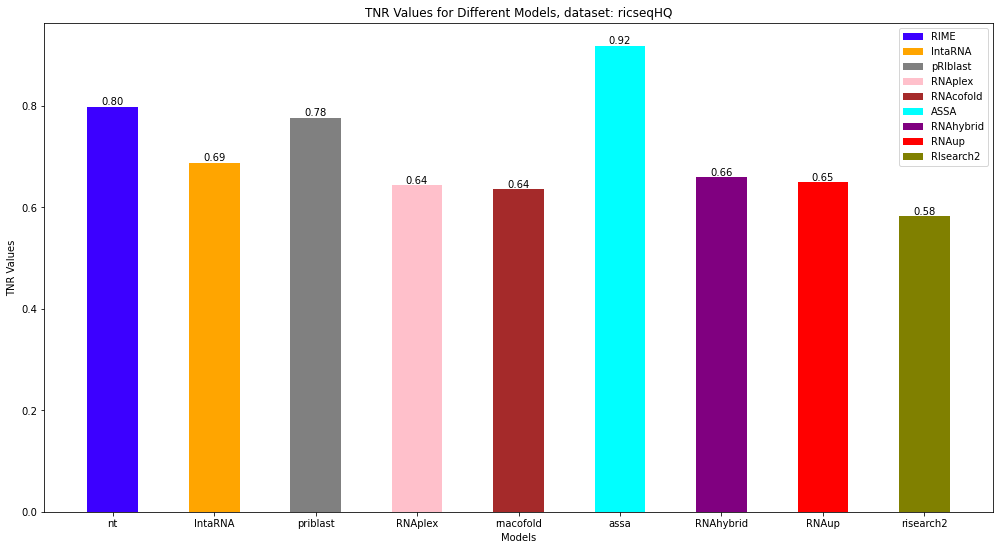

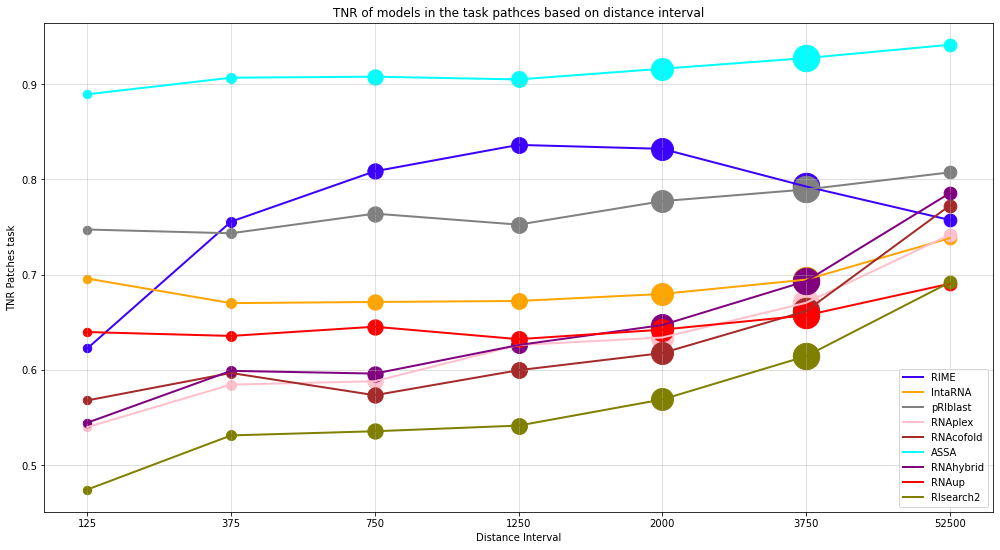

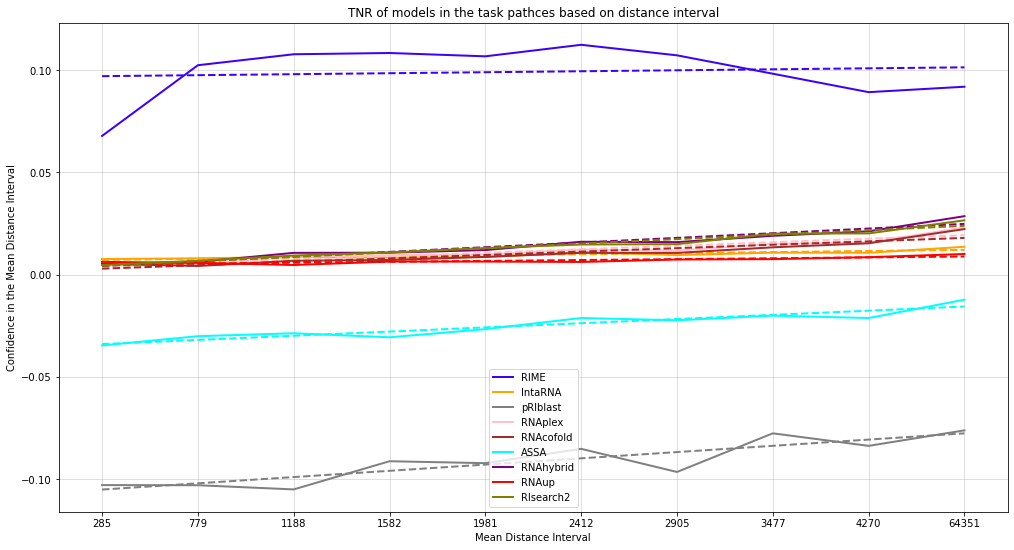

---------- DATASET: psoralen ----------


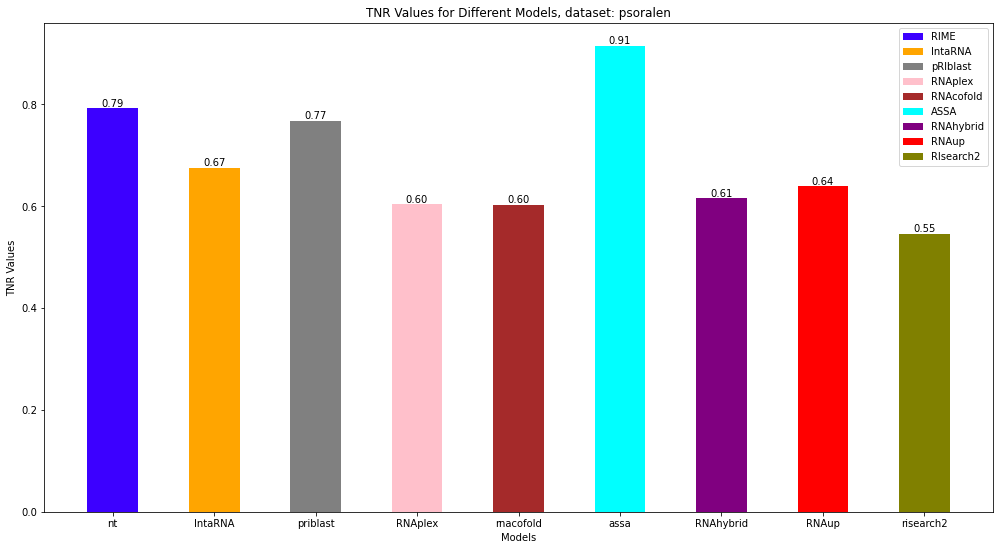

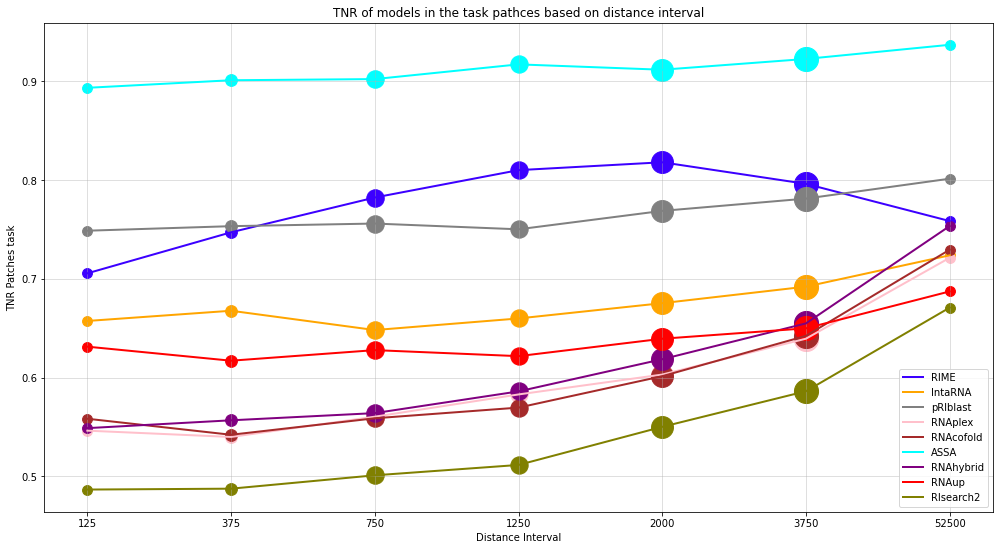

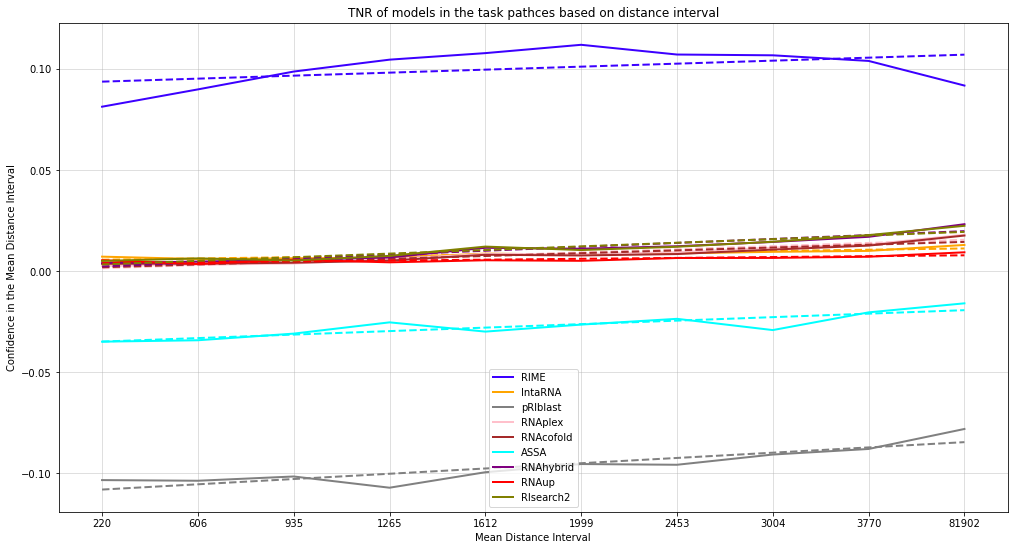

---------- DATASET: paris ----------


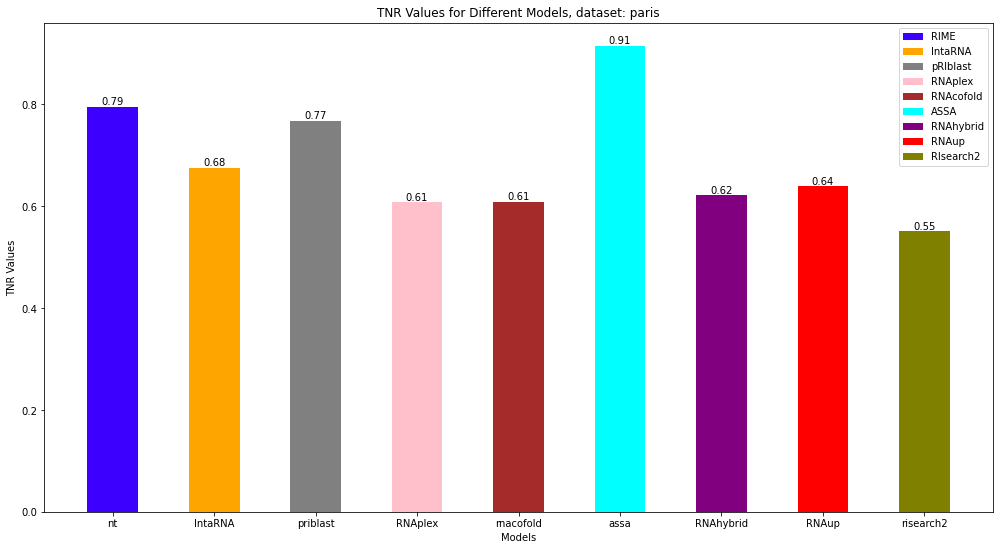

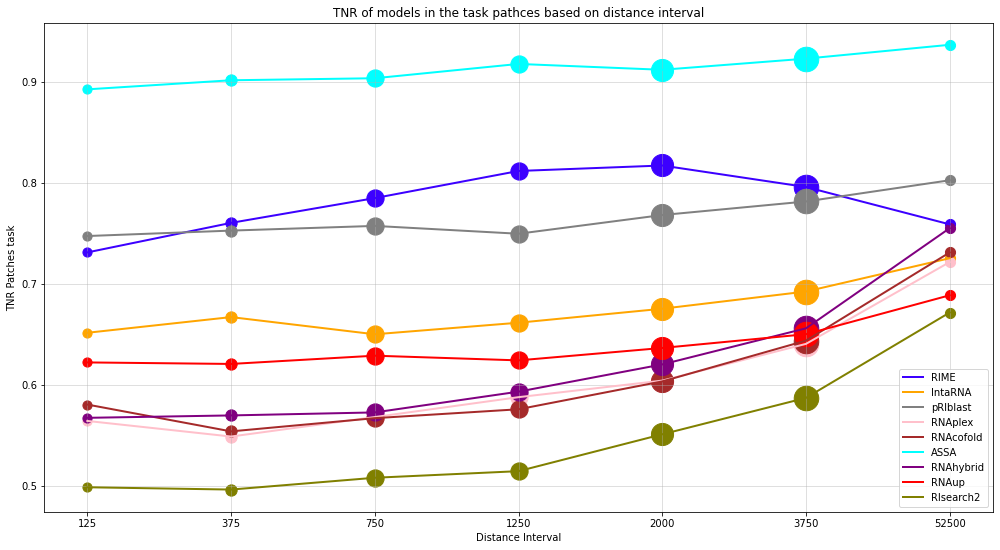

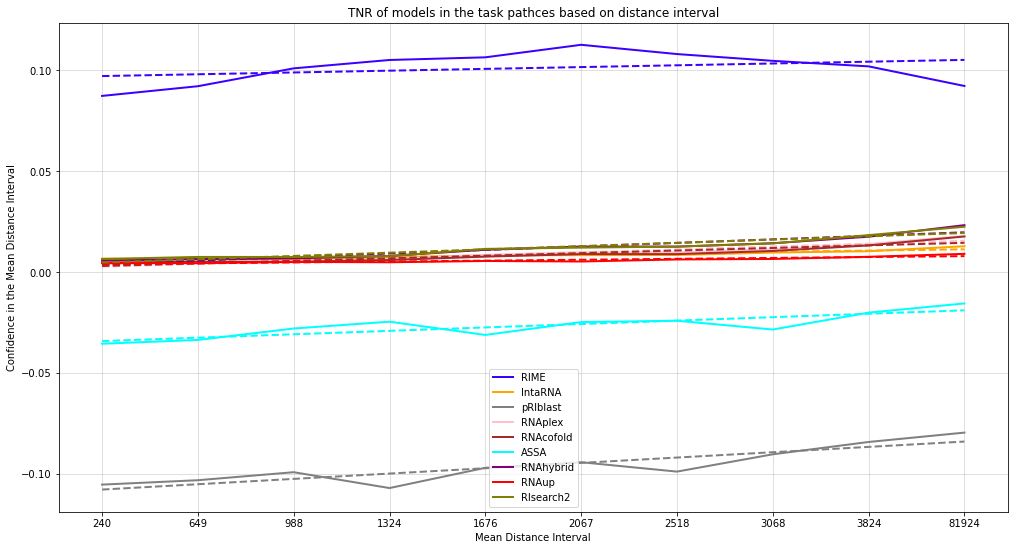

---------- DATASET: paris_mouse ----------


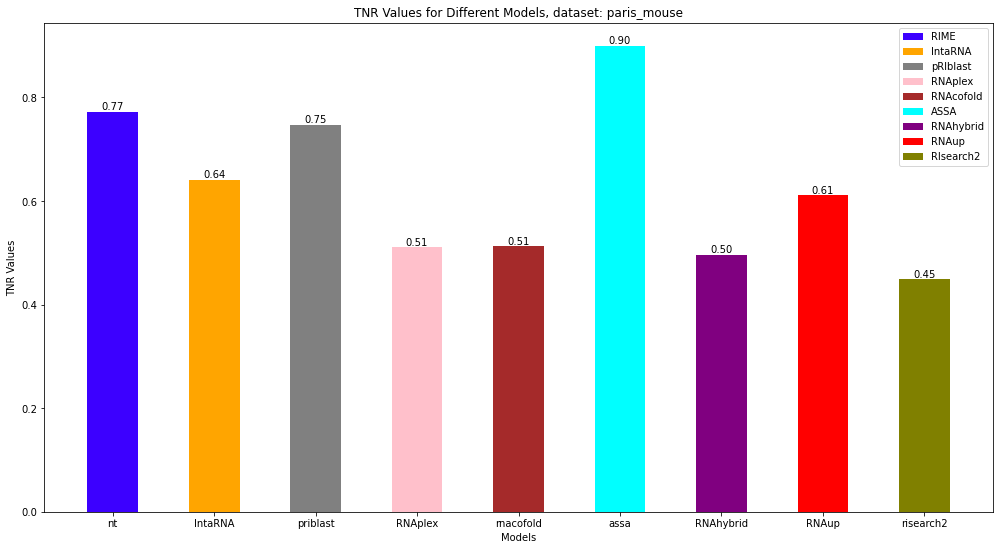

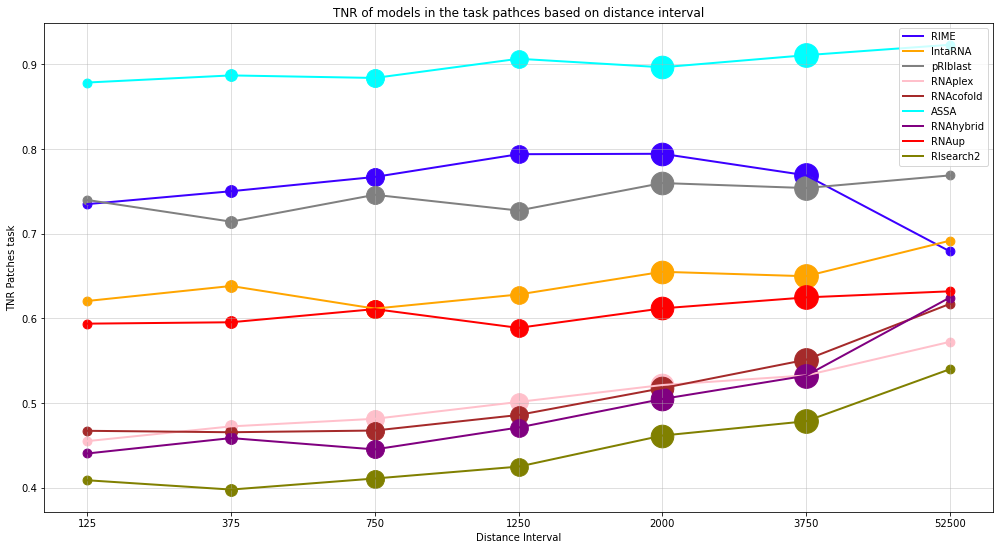

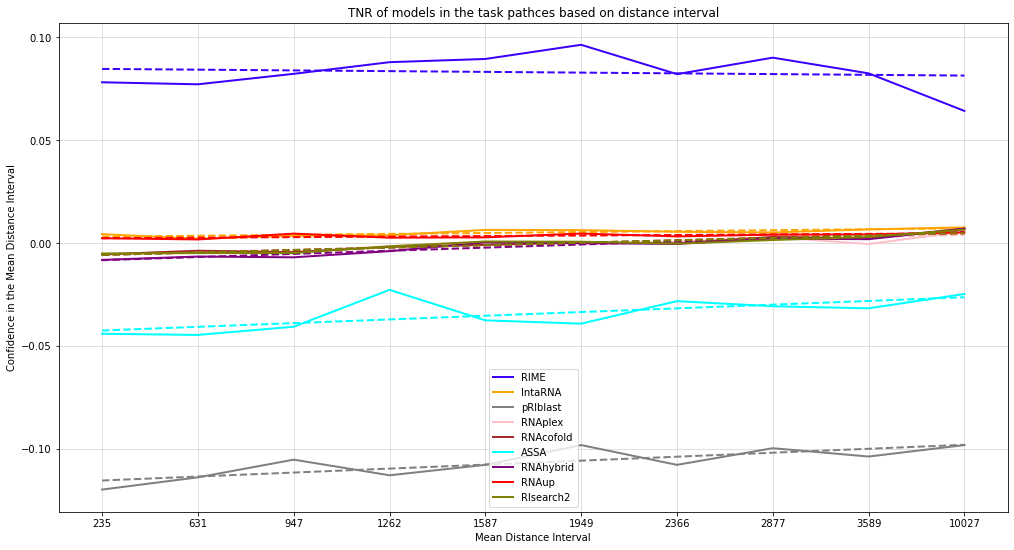

---------- DATASET: ricseq ----------


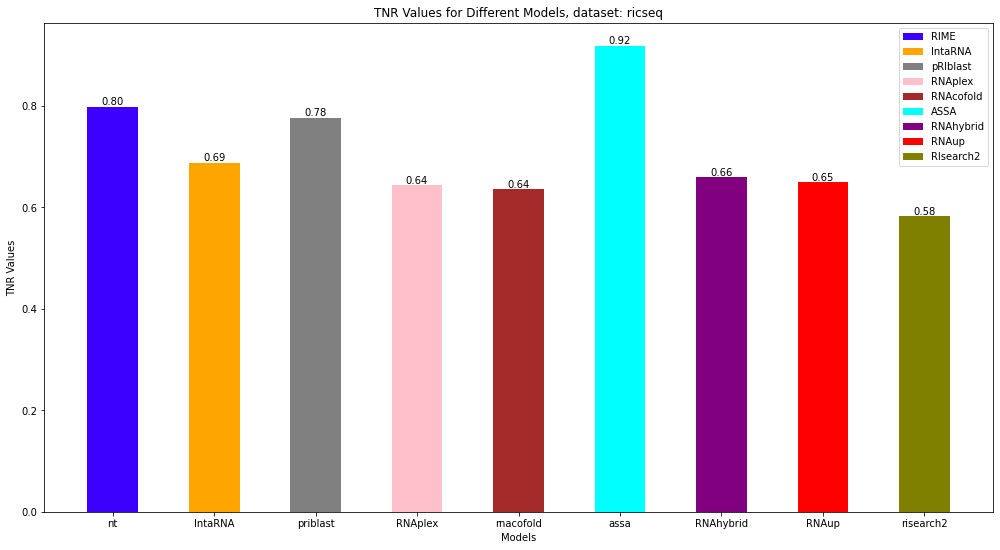

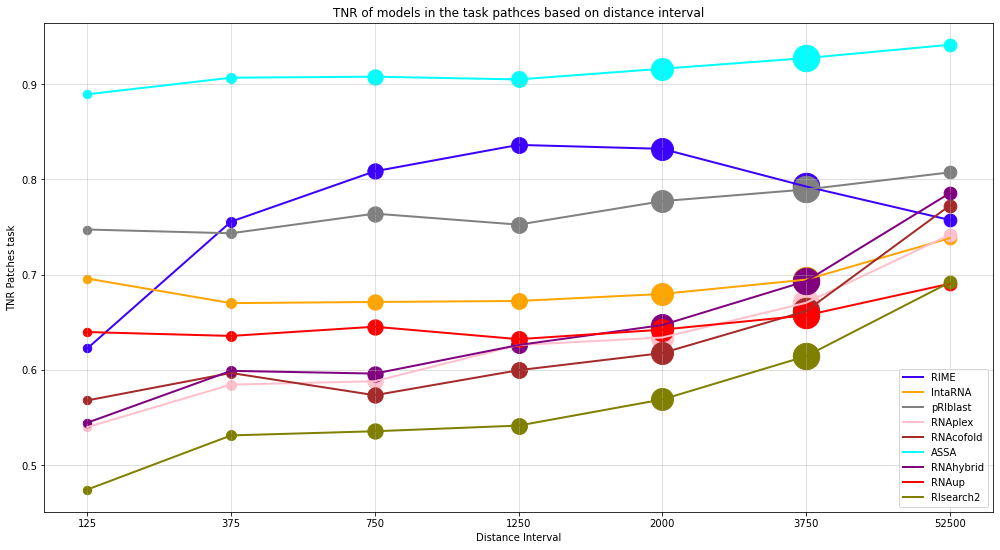

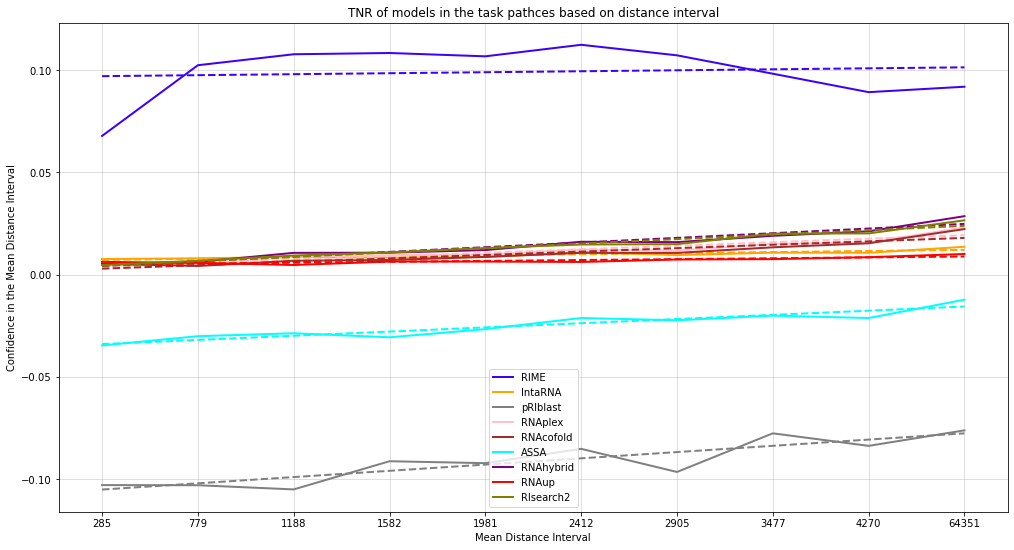

---------- DATASET: mario ----------


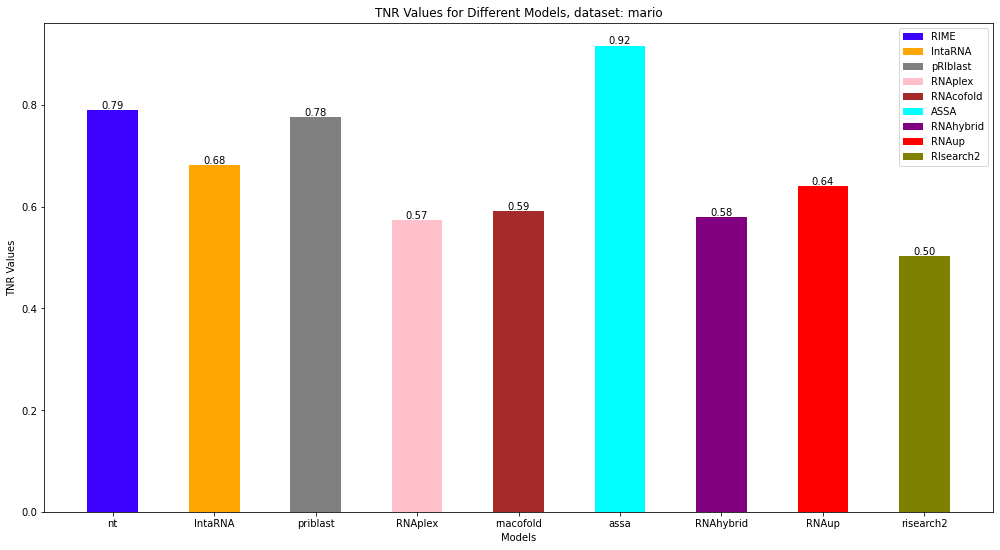

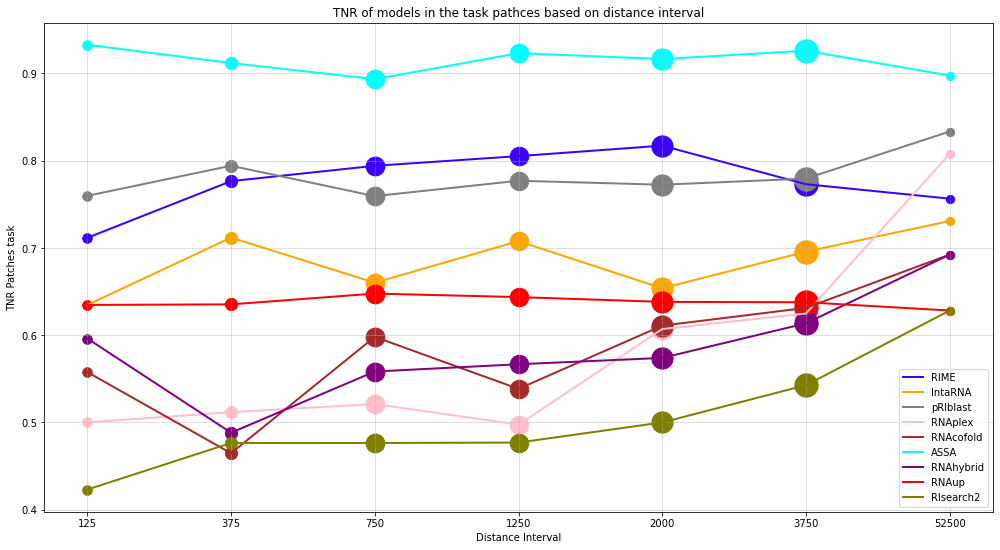

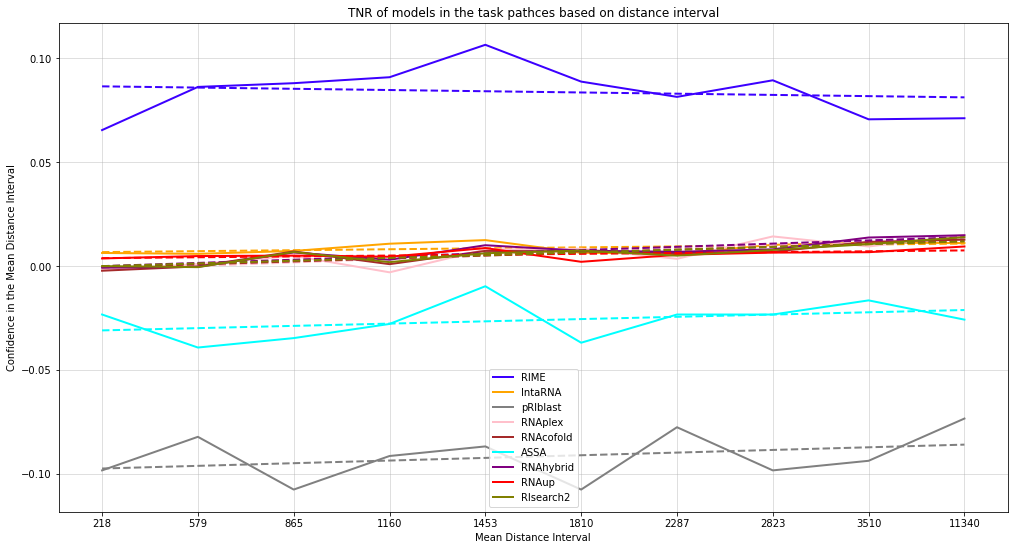

---------- DATASET: splash ----------


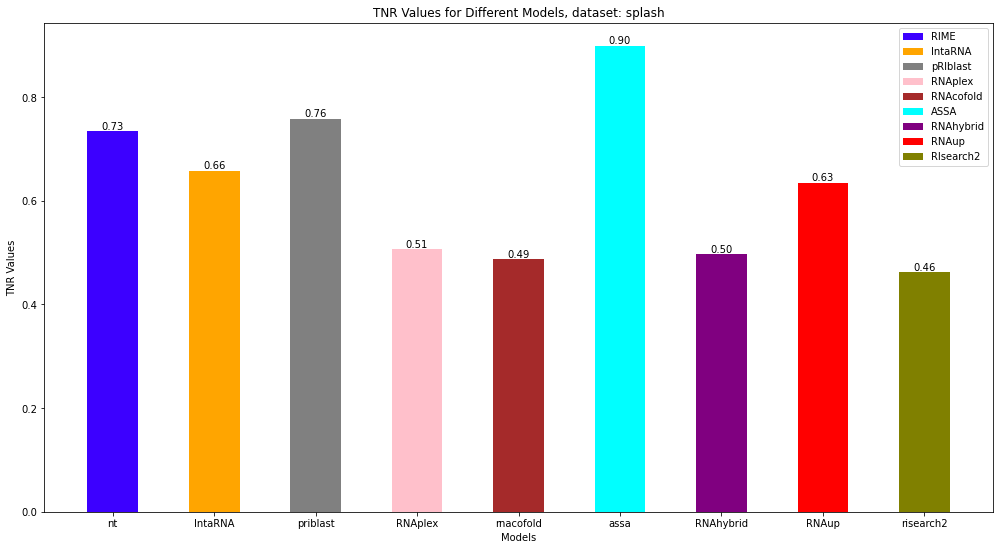

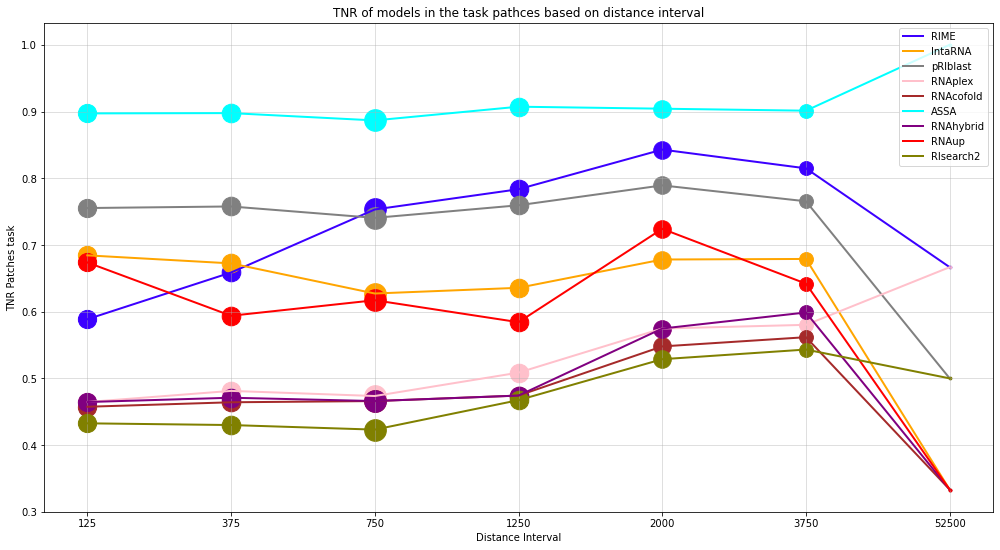

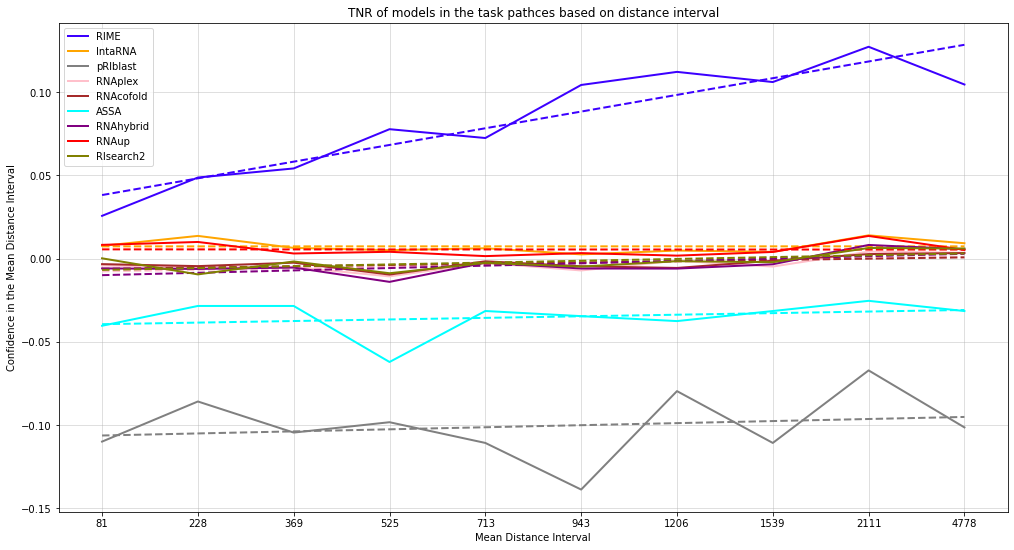

In [59]:
figsize = (17, 9)
size_multiplier = 20
bins_distance = [[1, 250], [250, 500], [500, 1_000], [1_000, 1_500], [1_500, 2_500], [2_500, 5_000], [5_000, 100_000]]

checkpoint_dir = [os.path.join(ROOT_DIR, 'checkpoints', _) for _ in nt_models]

for dataset in list_of_datasets:
    
    print(f'---------- DATASET: {dataset} ----------')
    
    experiment, specie_paris, paris_hq_threshold, n_reads_ricseq, n_reads_paris, interlen_OR_nreads_paris, paris_test = map_dataset_to_hp(dataset)
    
    res = modelRM.get_experiment_data(
        experiment = experiment, 
        paris_test = paris_test, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = specie_paris,
        paris_hq = False,
        paris_hq_threshold = paris_hq_threshold,
        n_reads_paris = n_reads_paris,
        interlen_OR_nreads_paris = False,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = n_reads_ricseq,
        logistic_regression_models = logistic_regression_models,
    )
        
    subset_to_plot = res[res.policy.isin(['easyneg', 'hardneg'])].reset_index(drop = True)
    
    
    plot_tnr_for_all_models(list_of_models_to_test, #['nt']
                            subset_to_plot, 
                            figsize = figsize, 
                            title_suffix = f'dataset: {dataset}', 
                            bar_width = 0.5
                           )

    plot_tnr_based_on_distance_for_all_models(subset_to_plot,
                                              bins_distance,
                                              list_of_models_to_test, #['nt']
                                              figsize=figsize, 
                                              size_multiplier = size_multiplier
                                             )

    bins_distance_quantile = quantile_bins(subset_to_plot.distance_from_site, 10)
    plot_confidence_based_on_distance_for_all_models(subset_to_plot, 
                                                     bins_distance_quantile, 
                                                     list_of_models_to_test, #['nt']
                                                     figsize)

### Plots based on top-bottom

In [11]:
#plot parameters
n_values = 5
figsize = (17,7)
size_multiplier = 10

MIN_PERC = 5
list_of_metrics = ['precision', 'npv'] #['f1','precision', 'npv'] #[['f1','precision', 'npv', 'recall', 'specificity', 'precision_recall_curve']
balance_predictions_at_each_step=False

#### Patches / Intectors

parisHQ interactors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


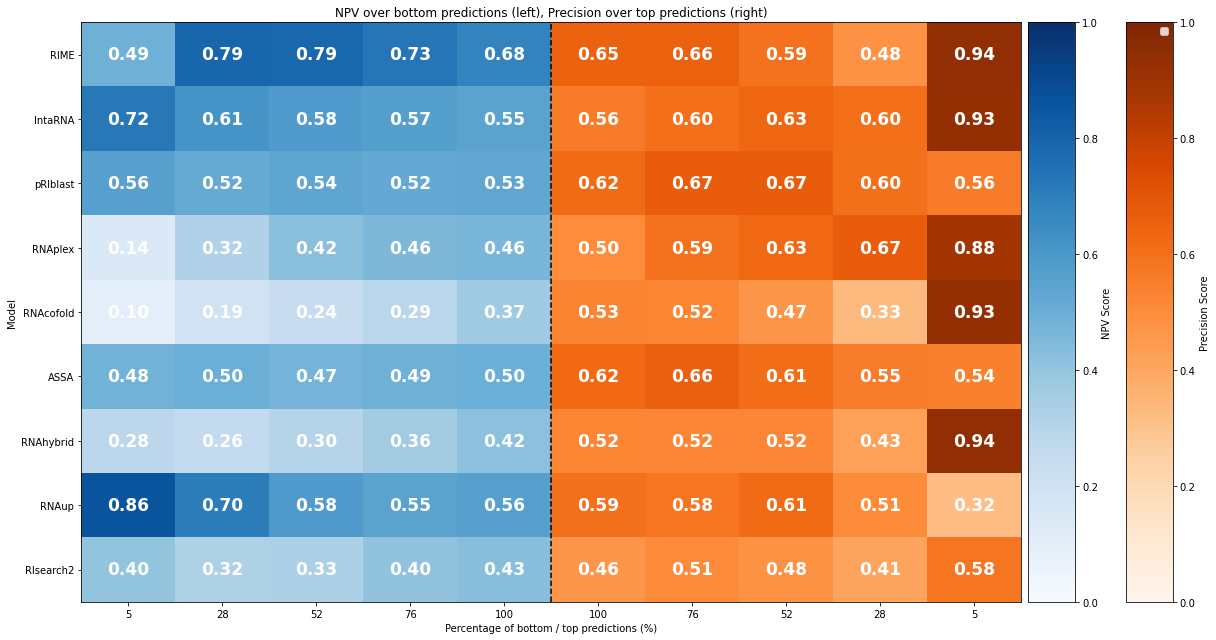

parisHQ patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


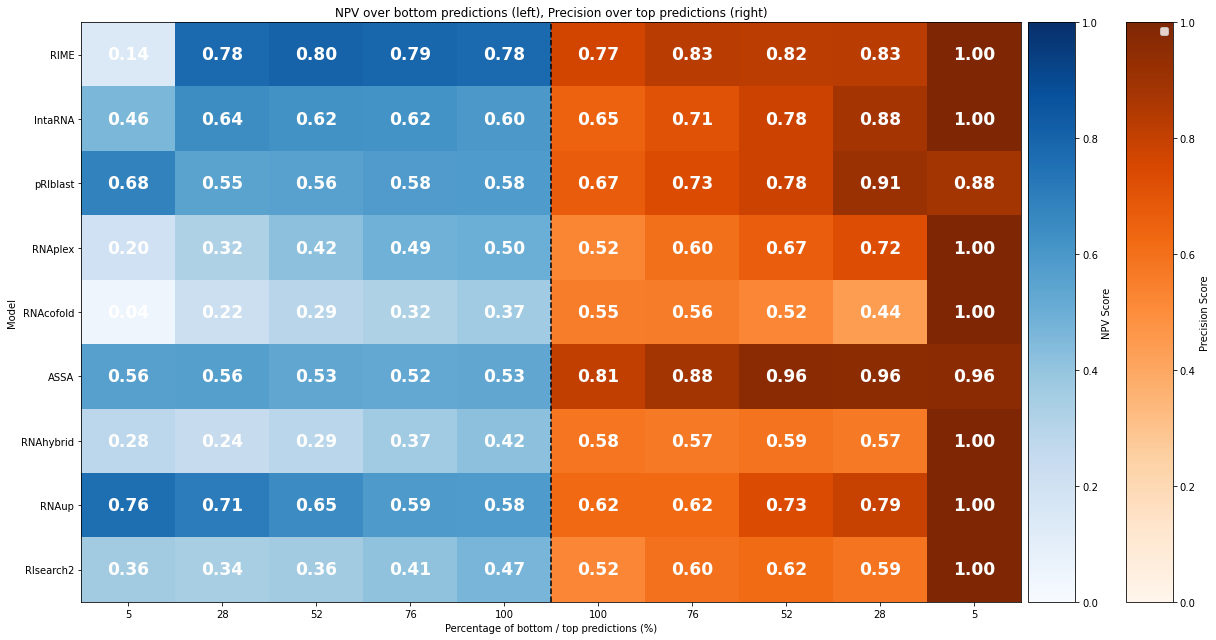

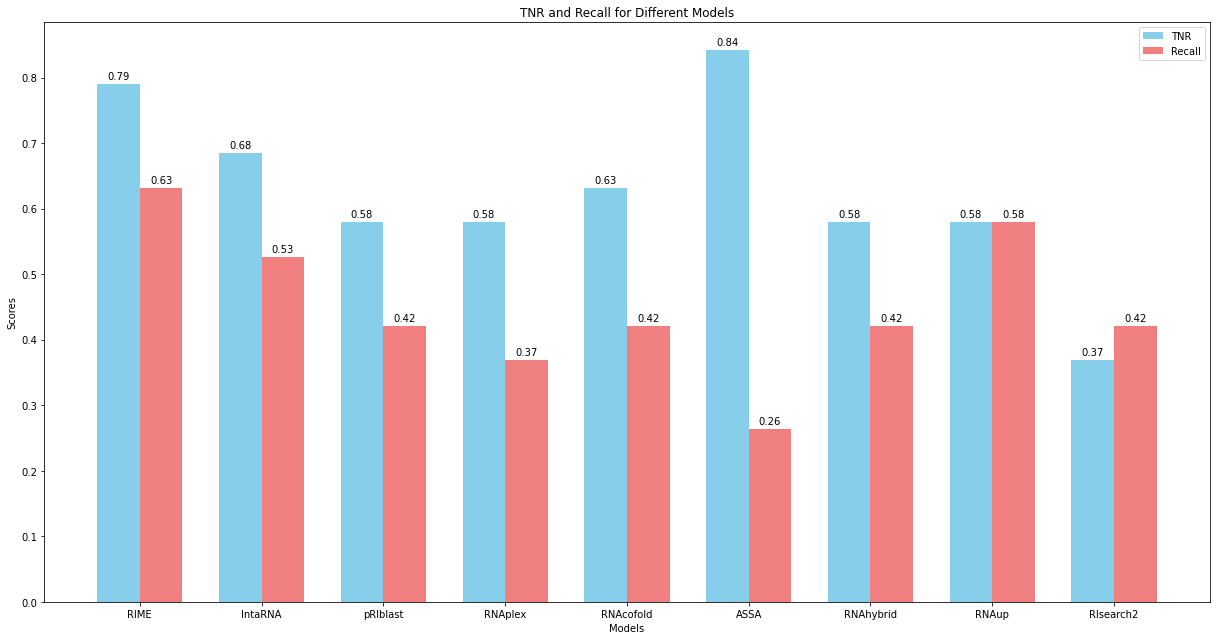

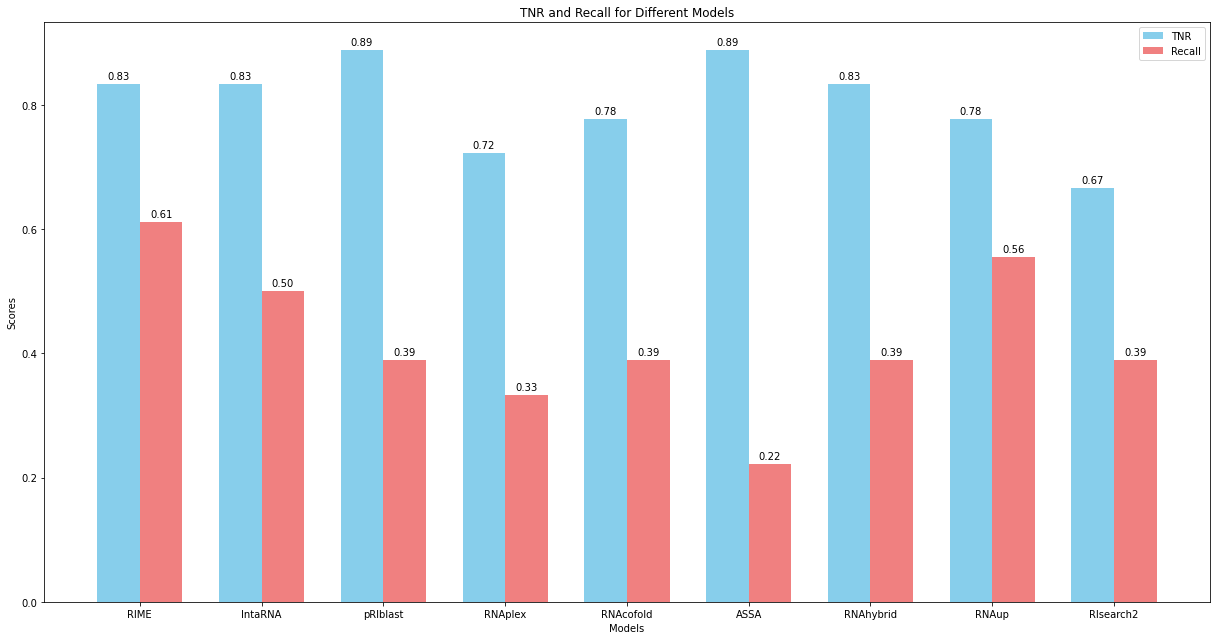

paris_mouse_HQ interactors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


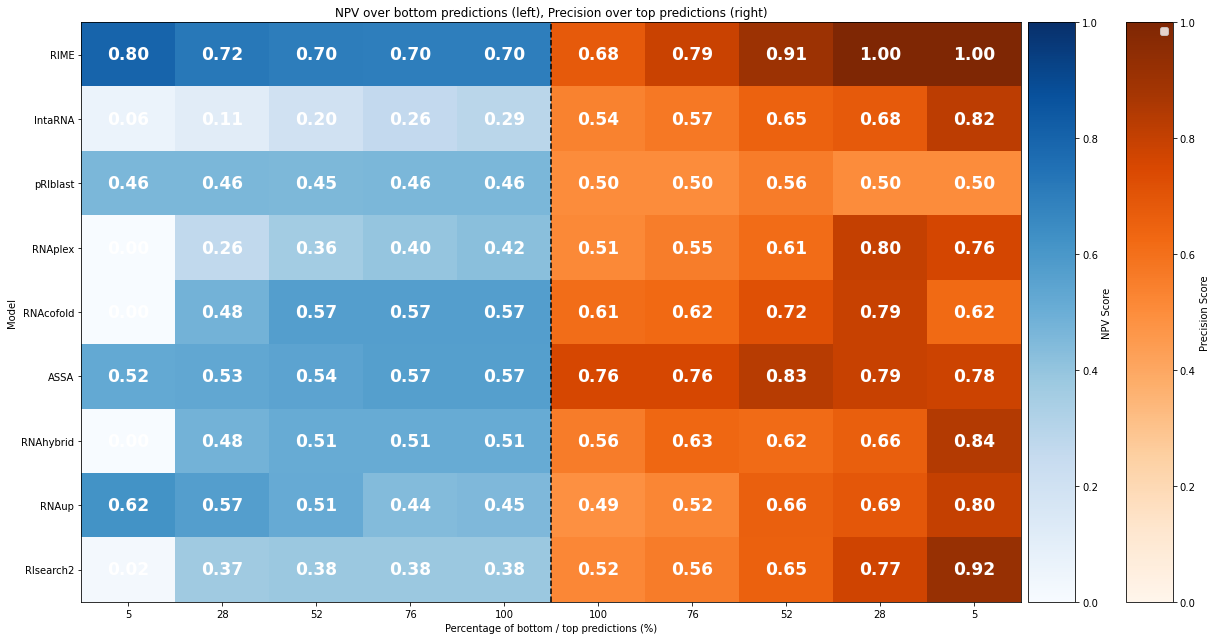

paris_mouse_HQ patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


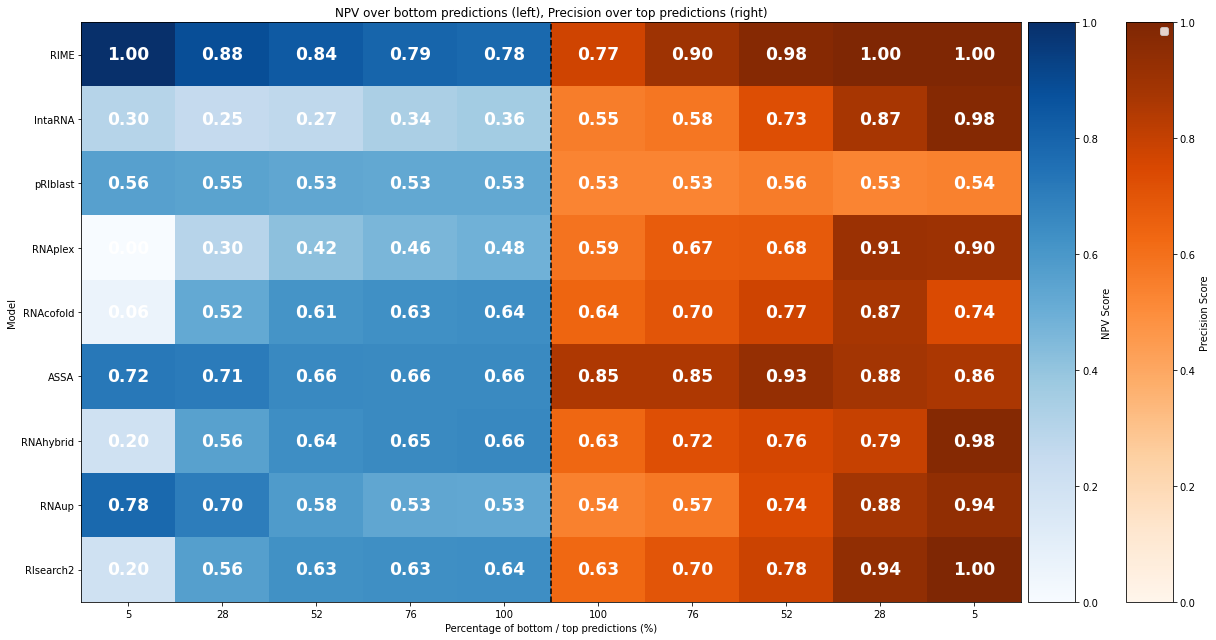

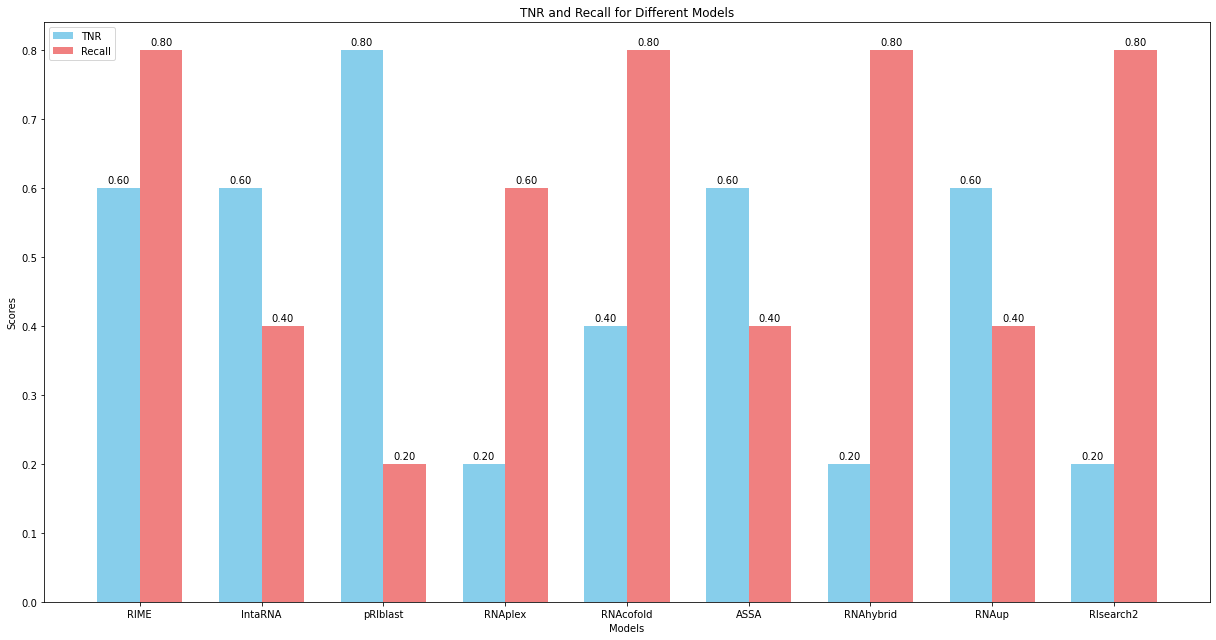

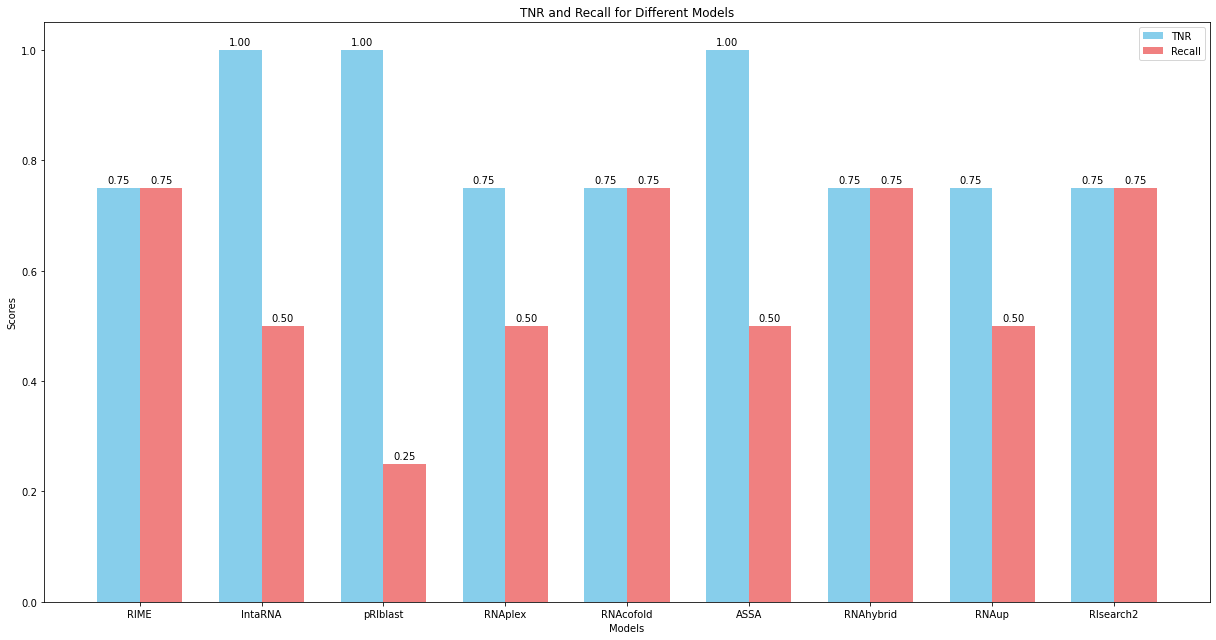

ricseqHQ interactors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


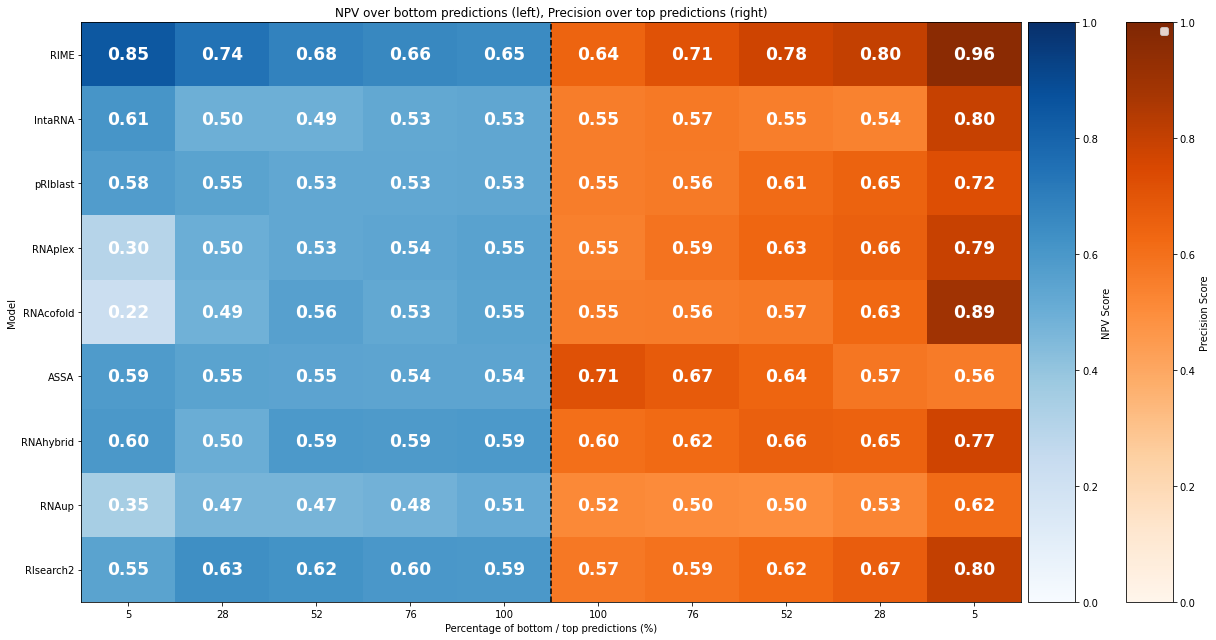

ricseqHQ patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


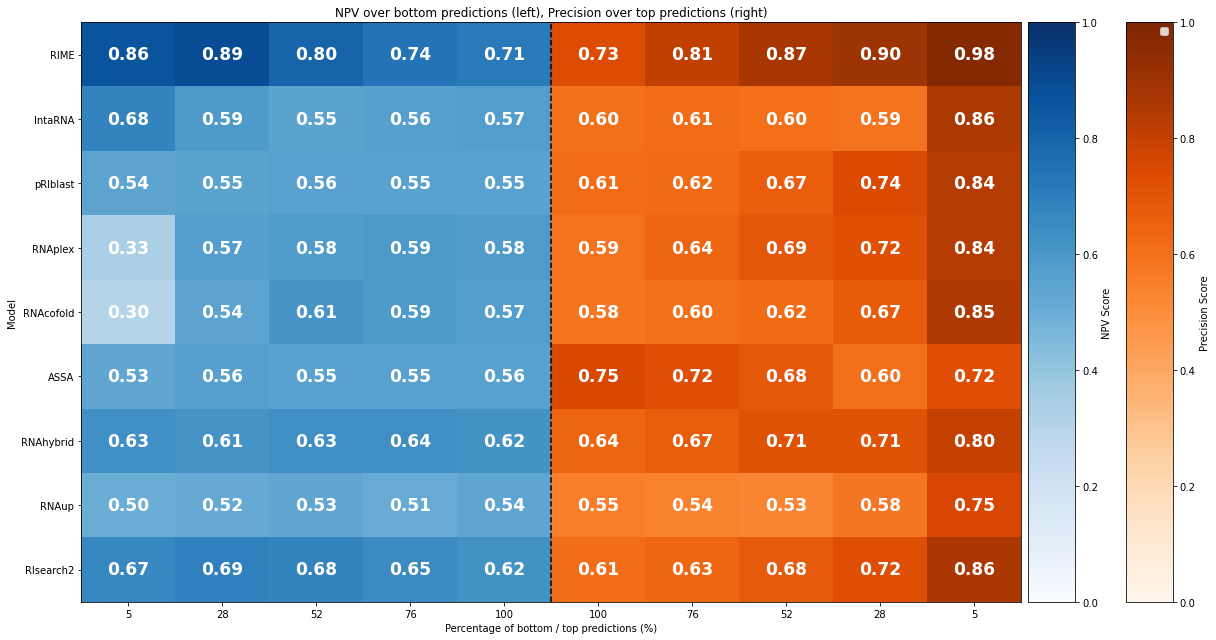

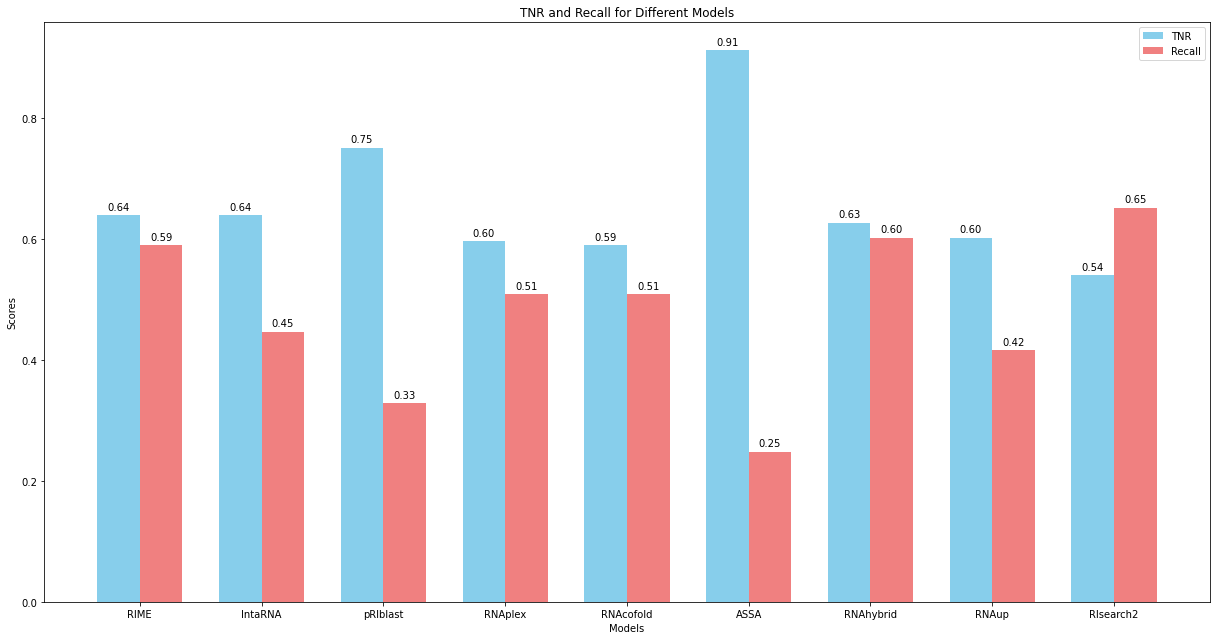

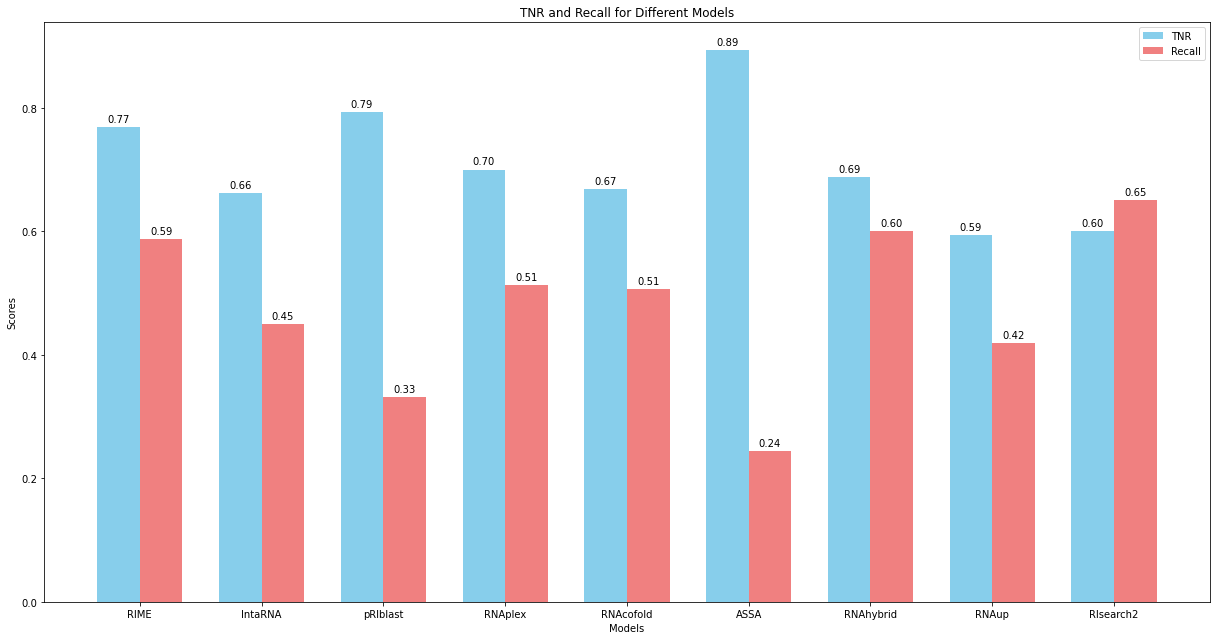

psoralen interactors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


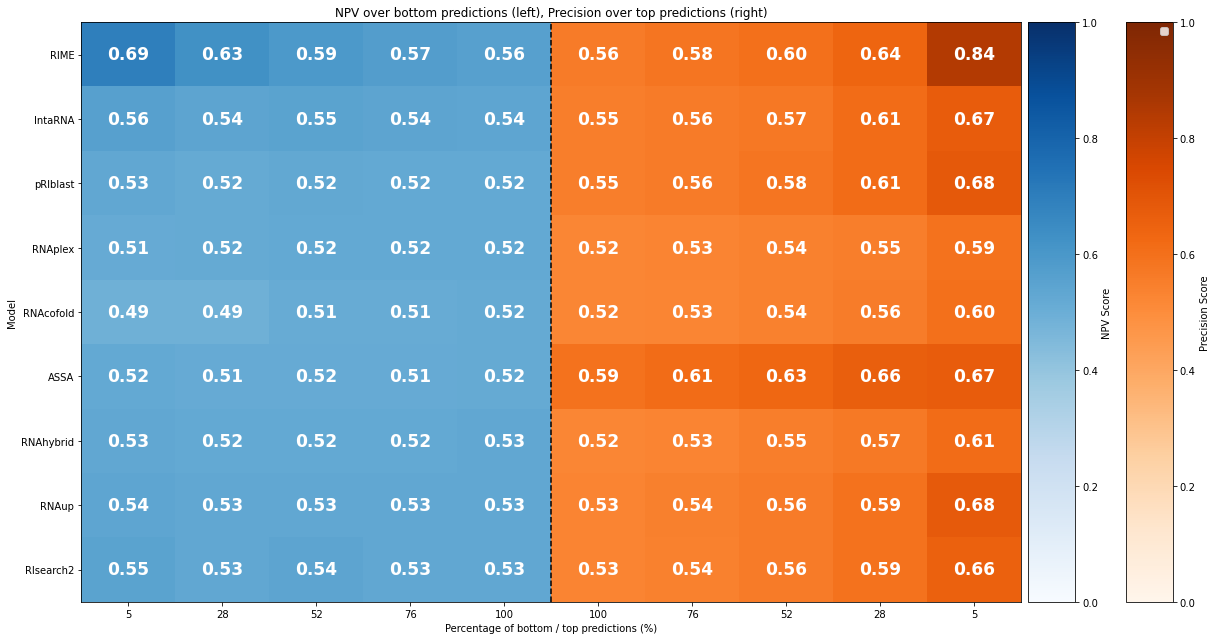

psoralen patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


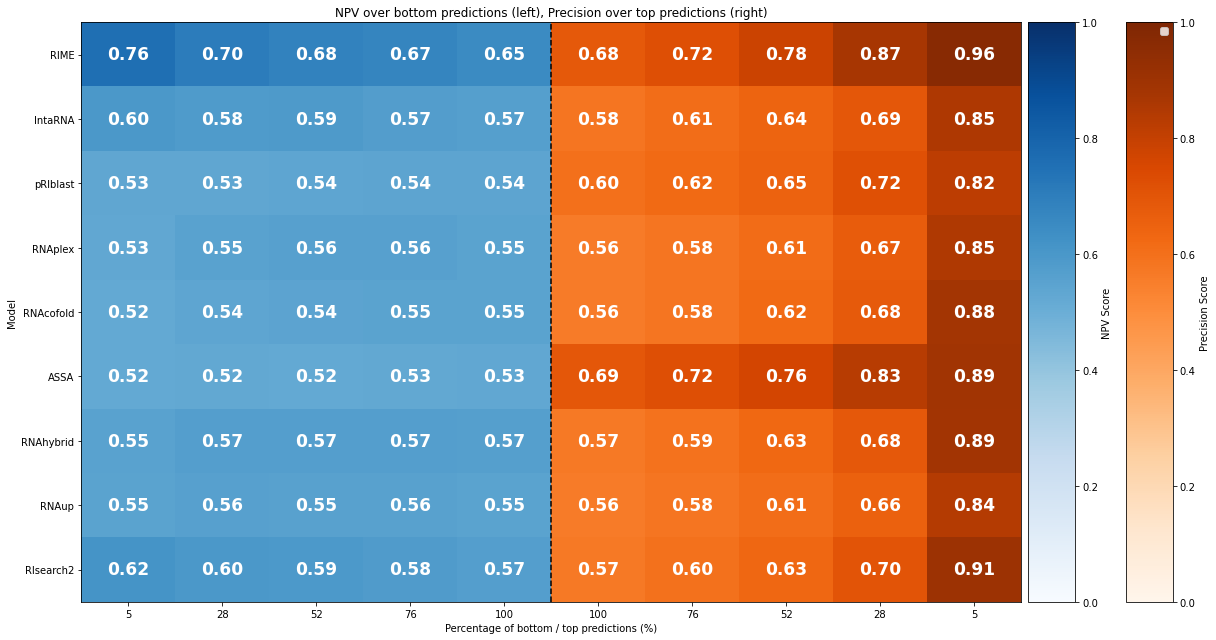

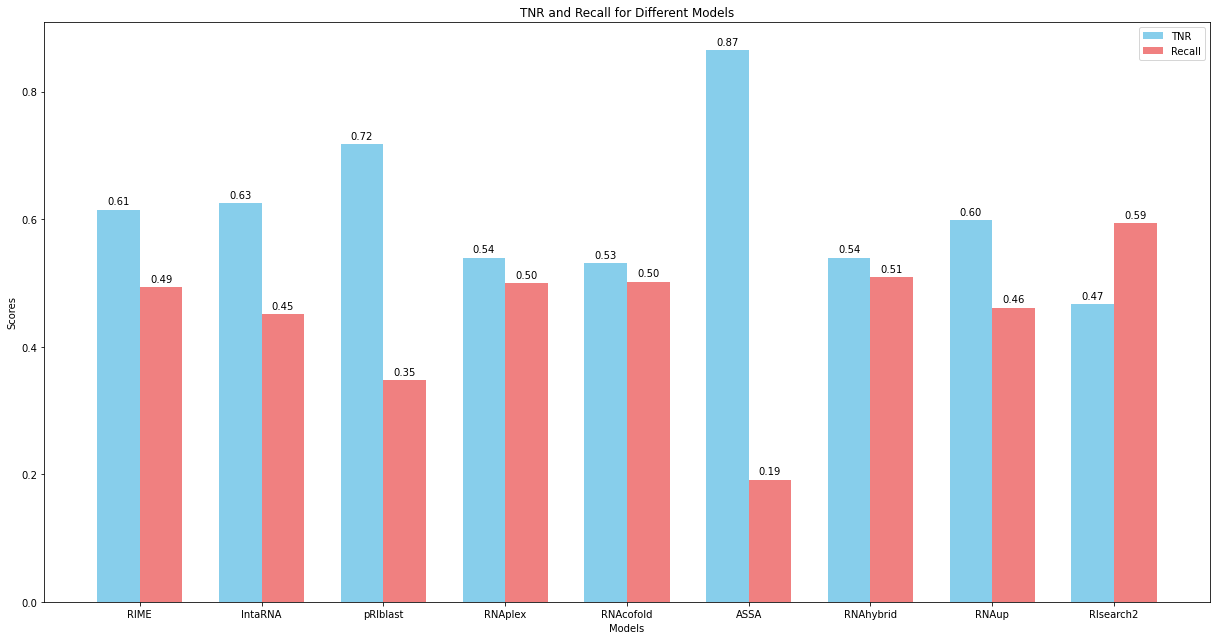

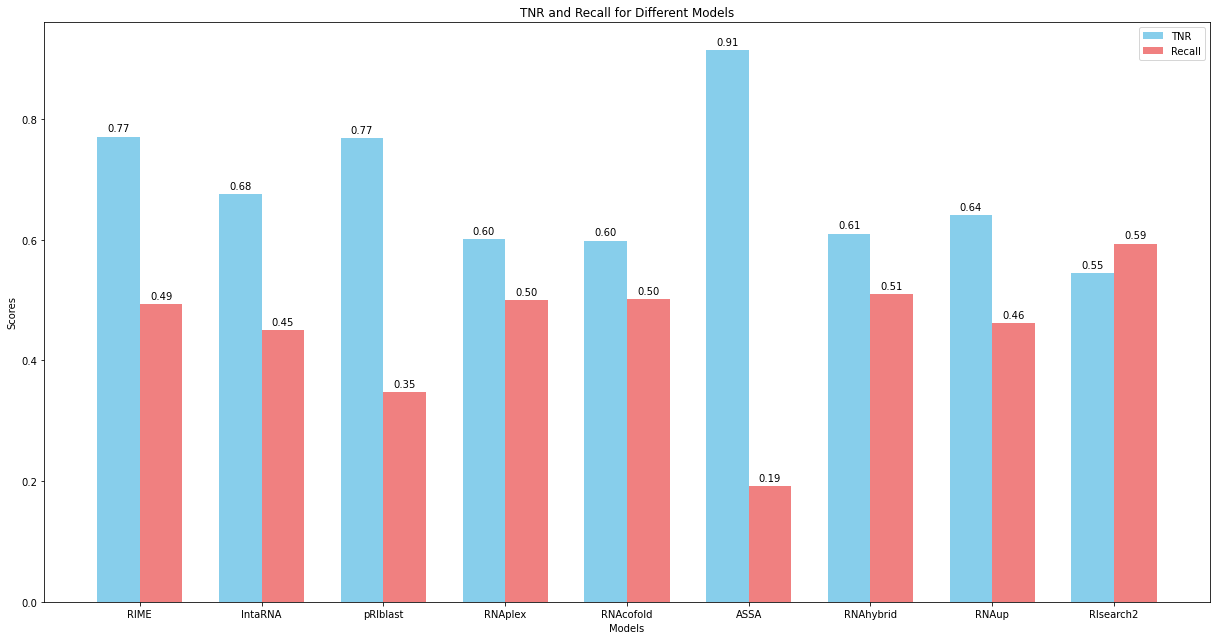

paris interactors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


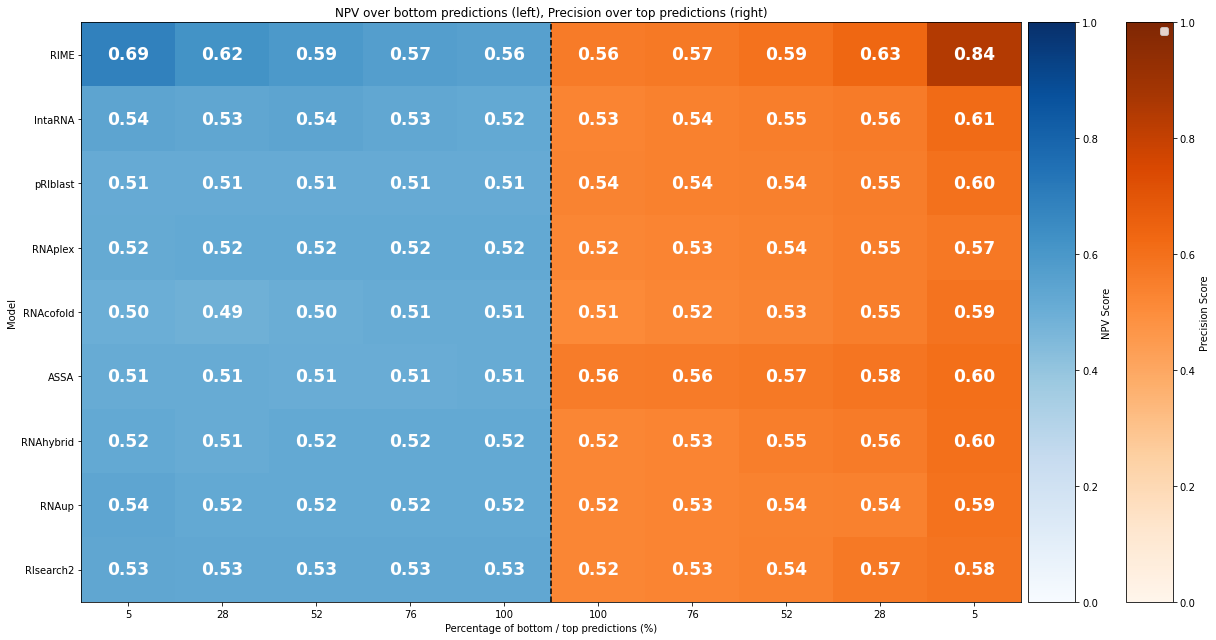

paris patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


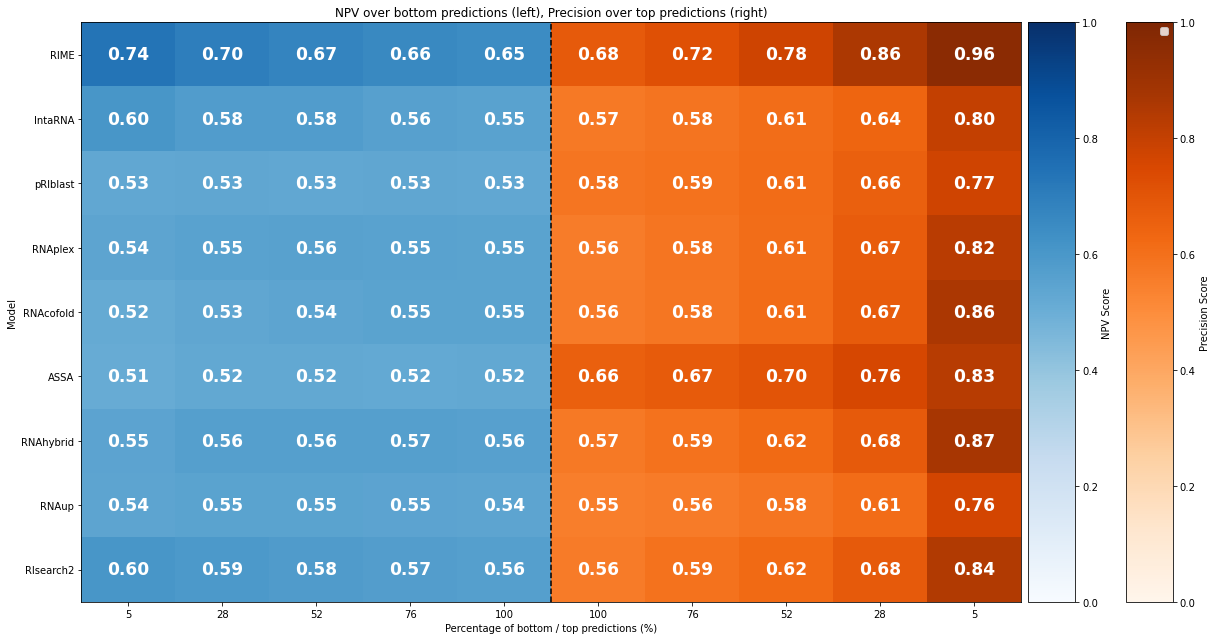

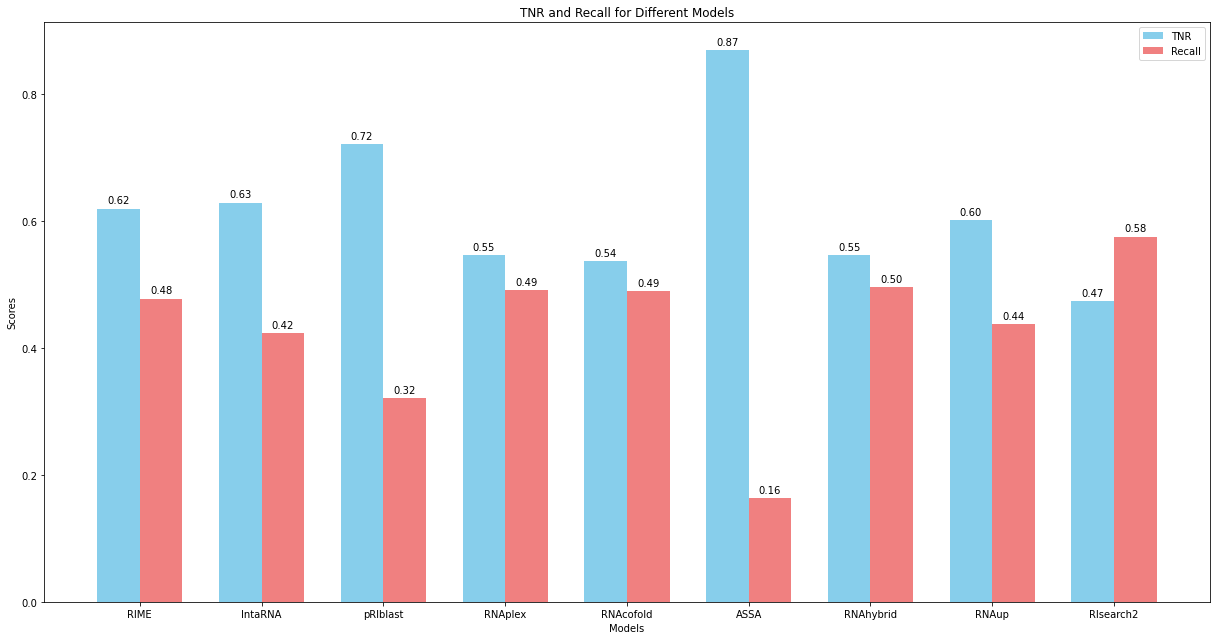

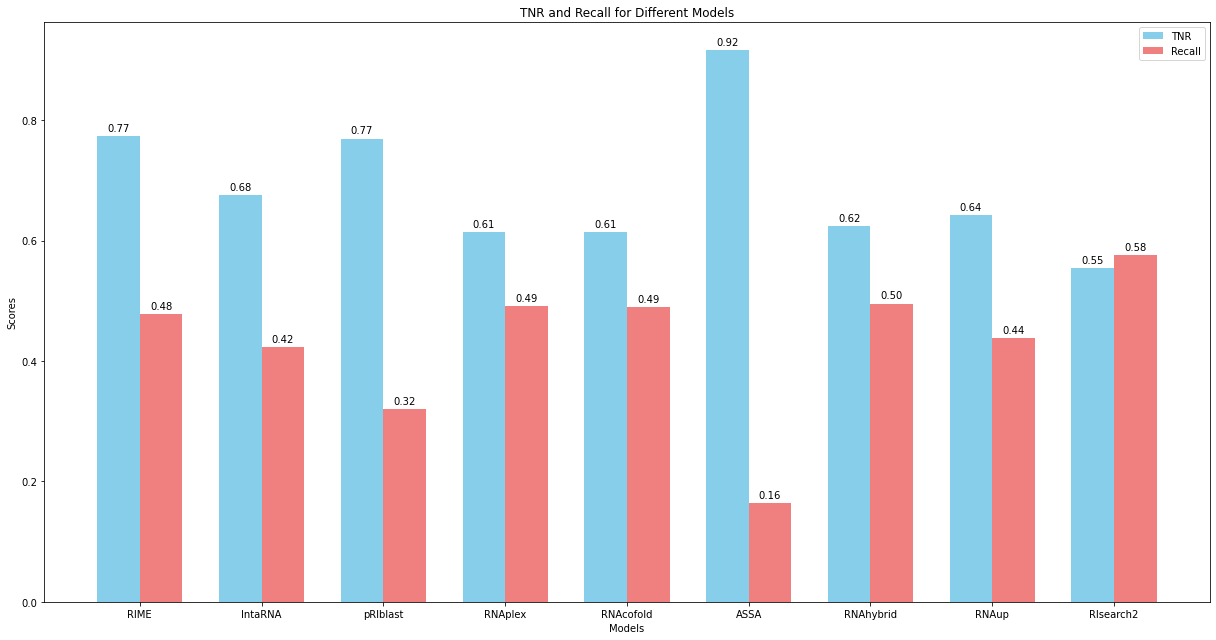

paris_mouse interactors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


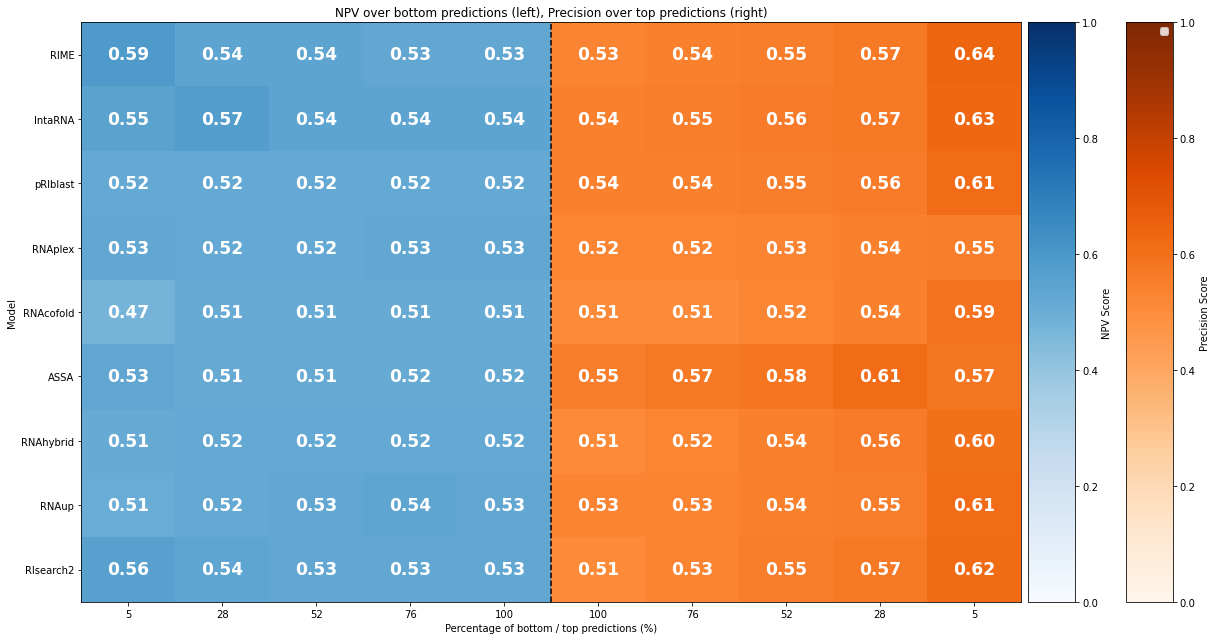

paris_mouse patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


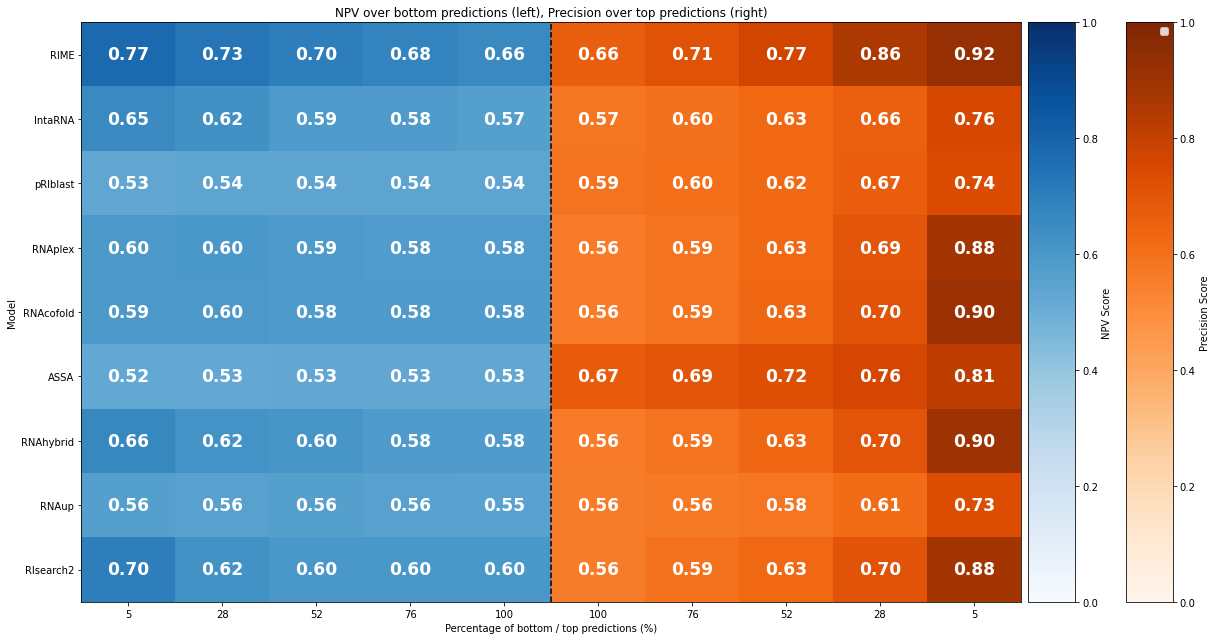

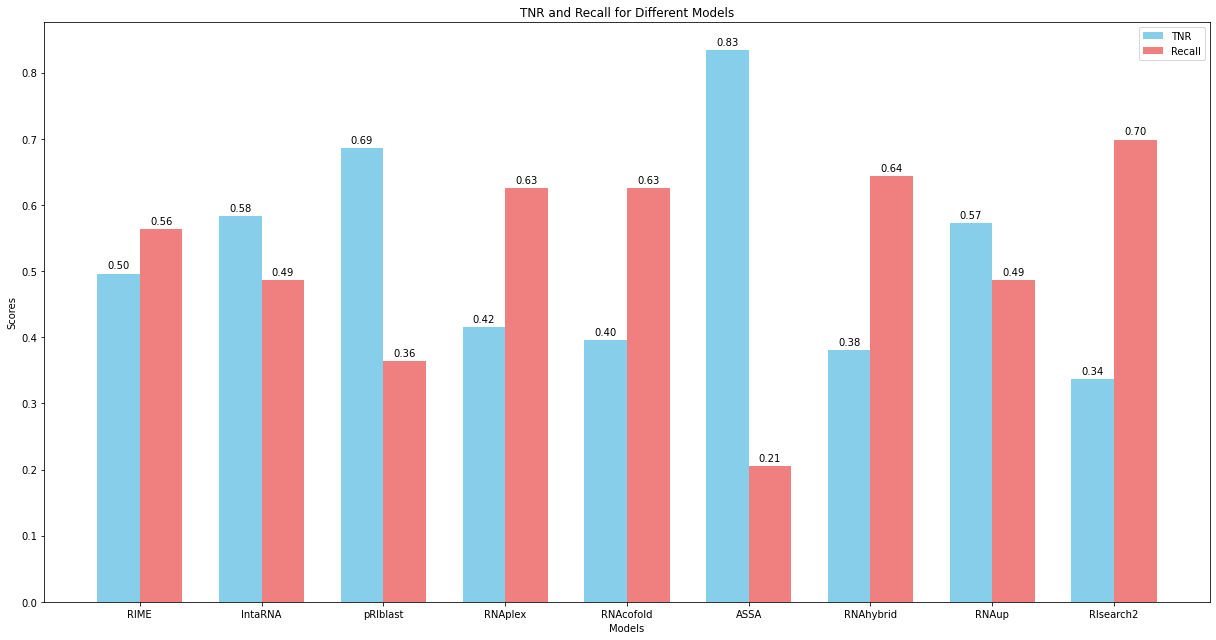

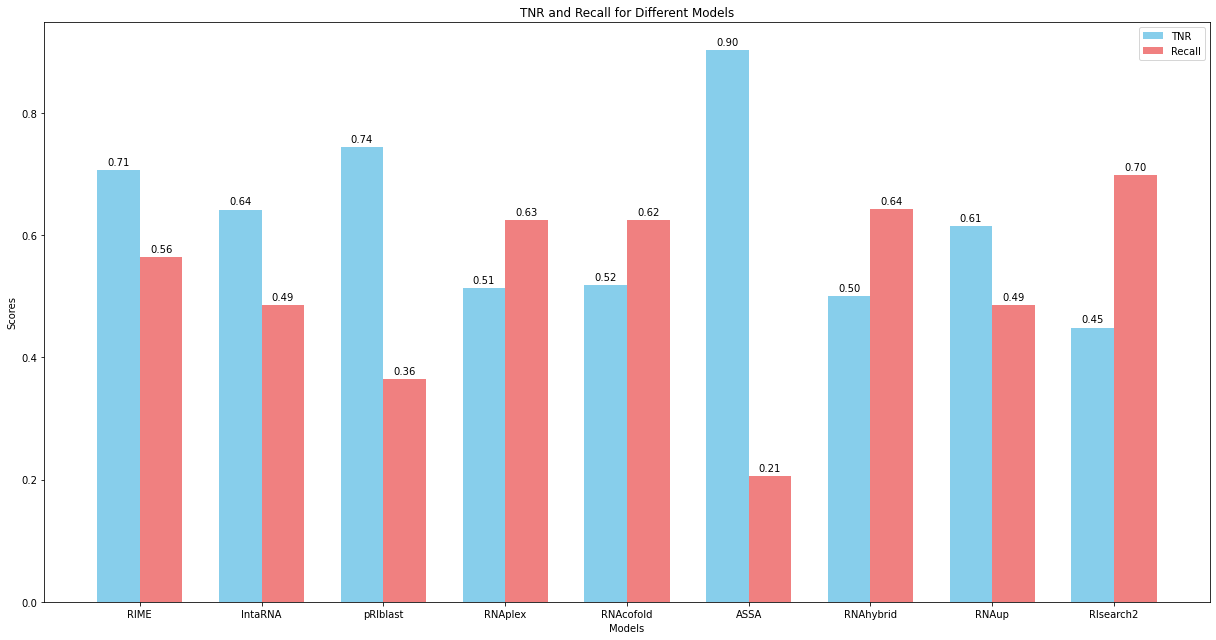

ricseq interactors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


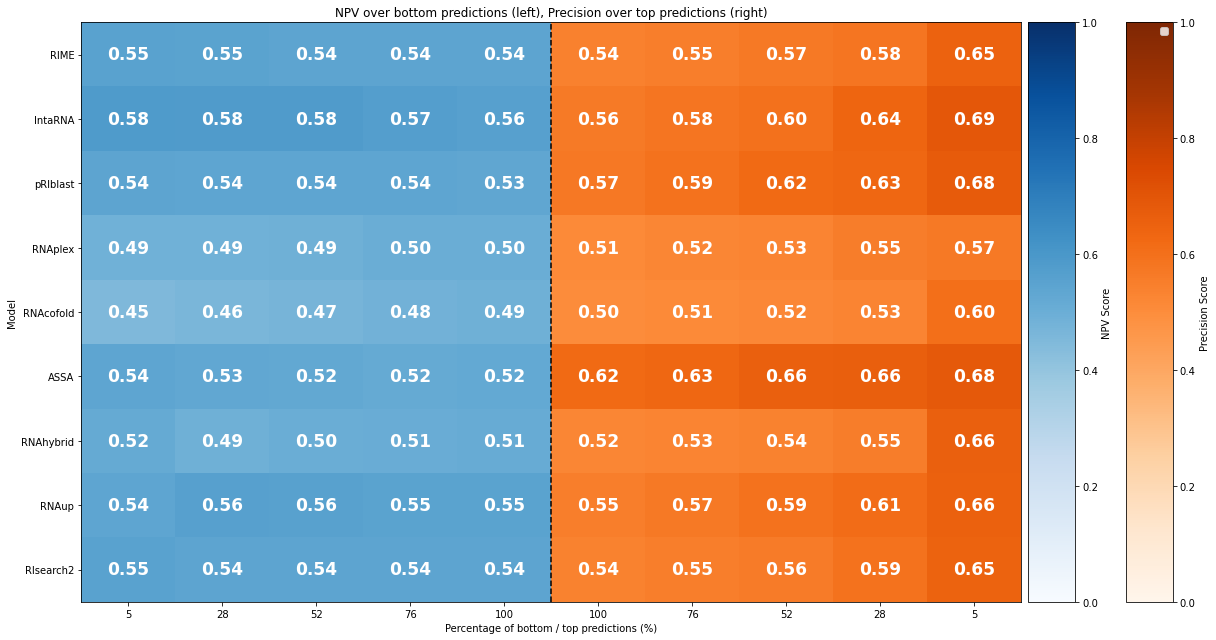

ricseq patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


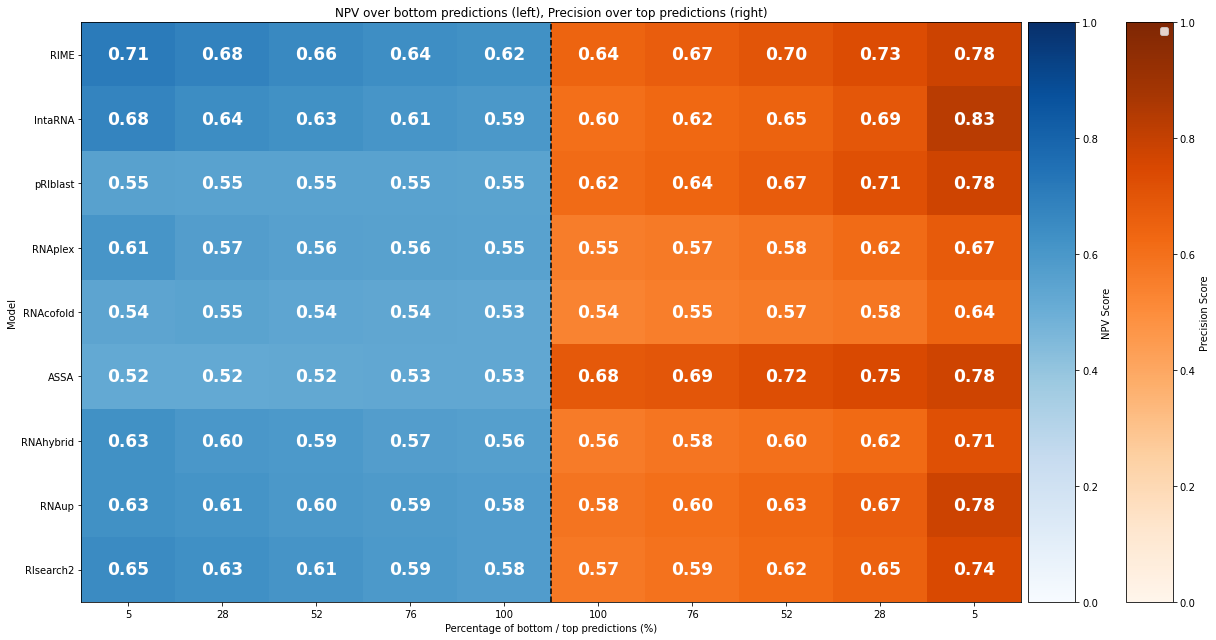

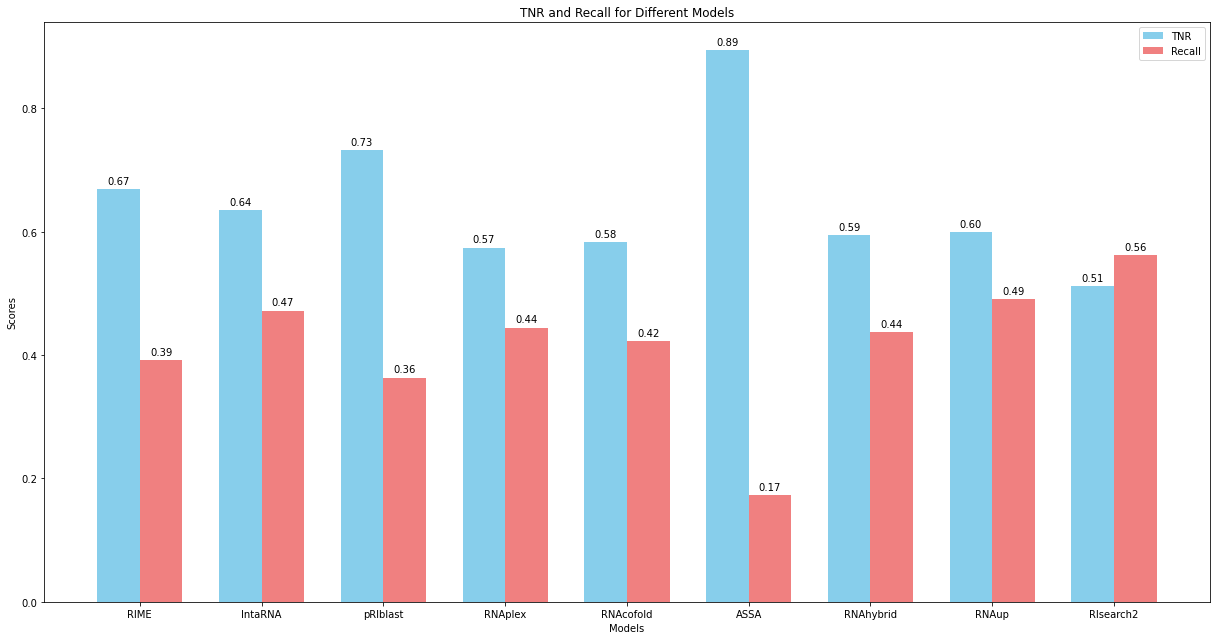

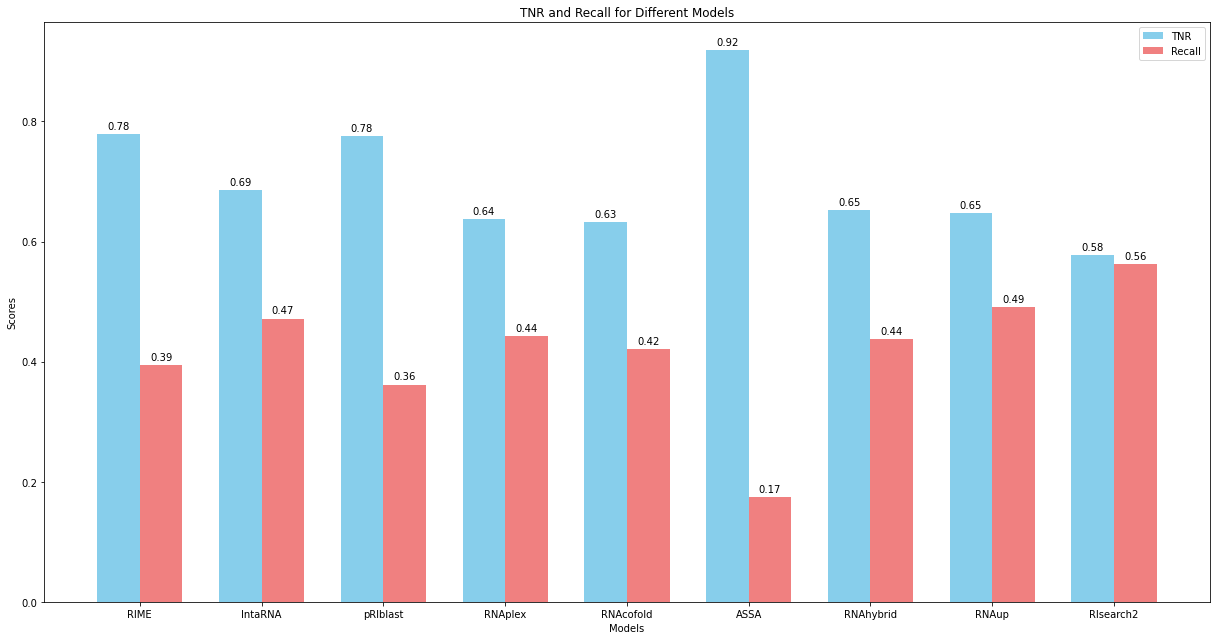

mario interactors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


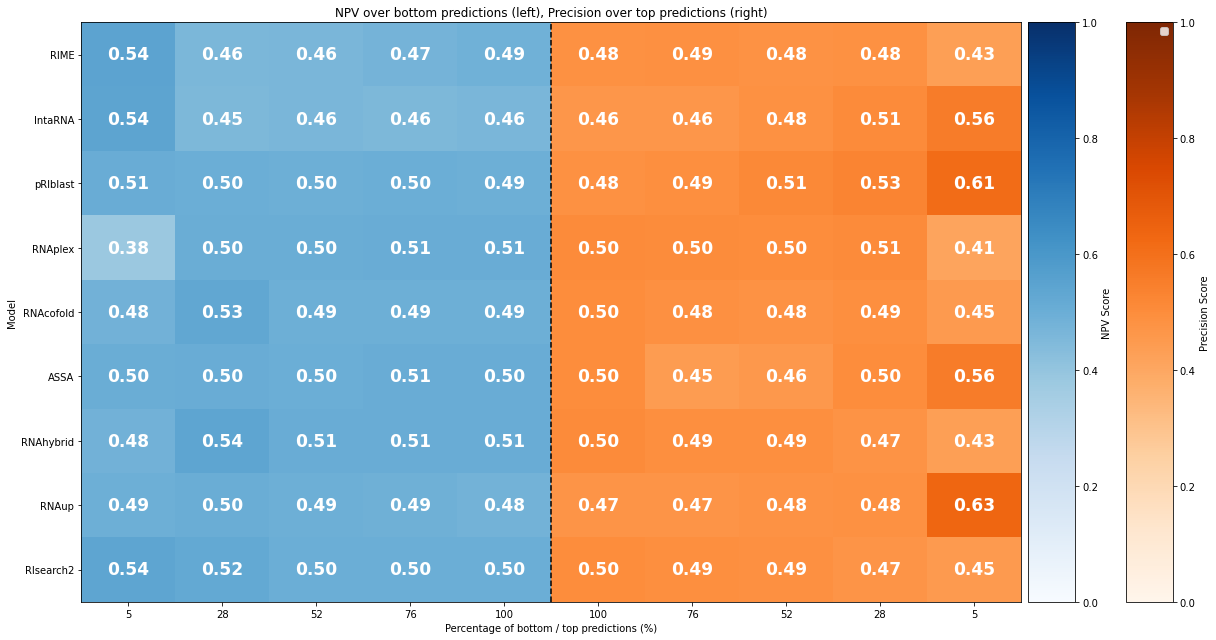

mario patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


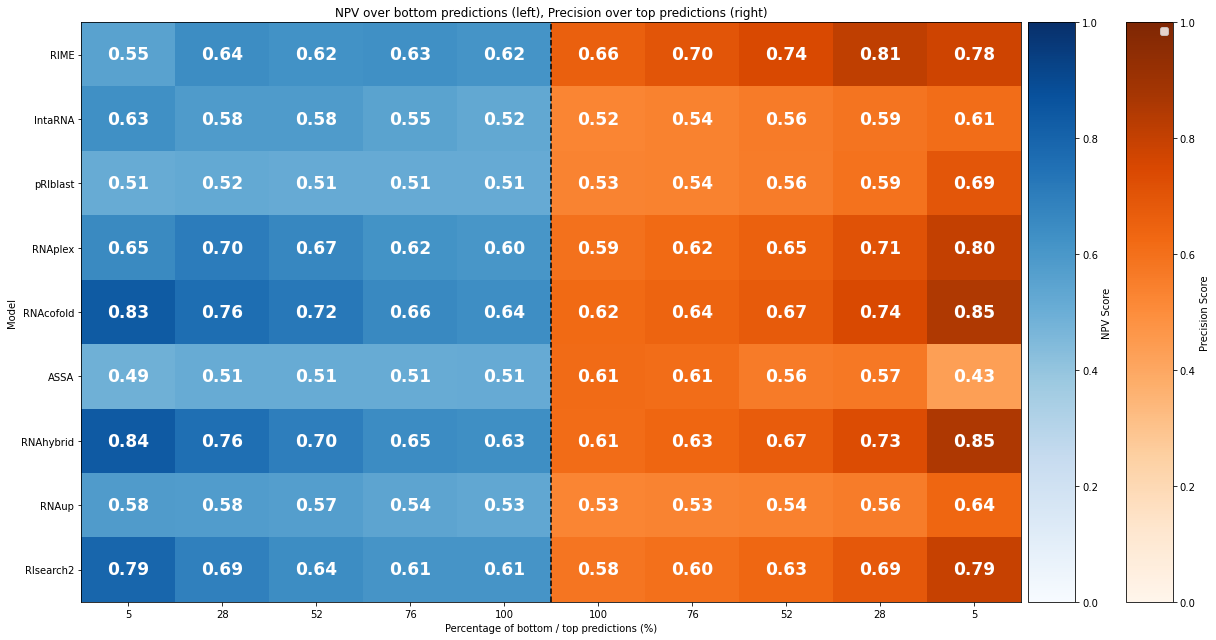

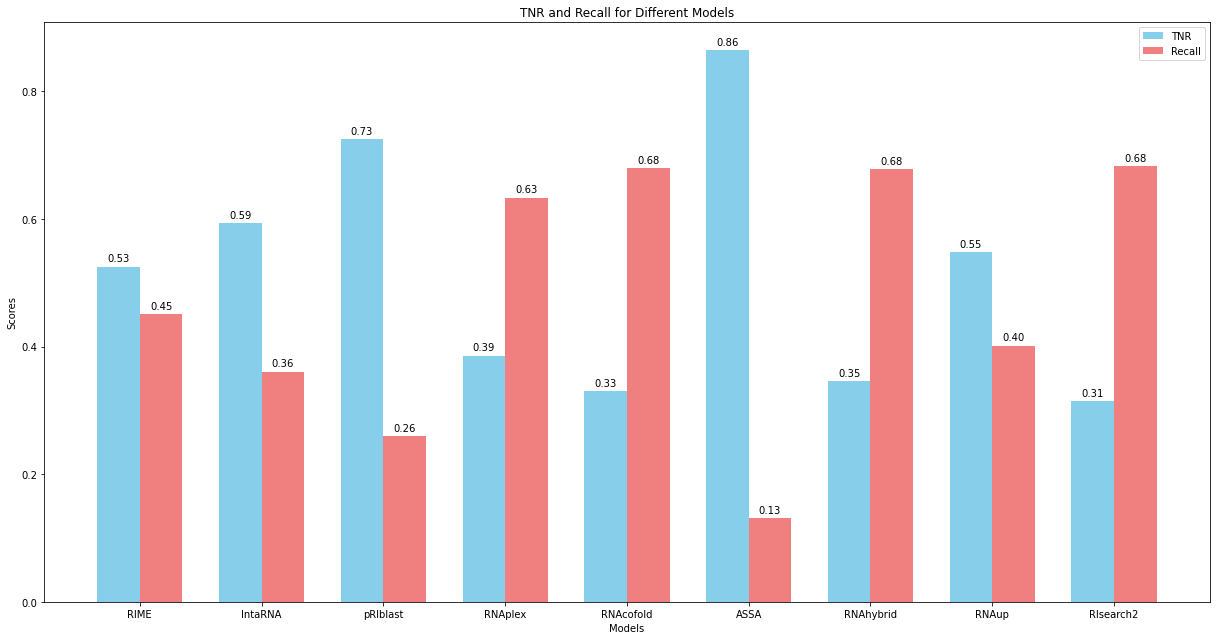

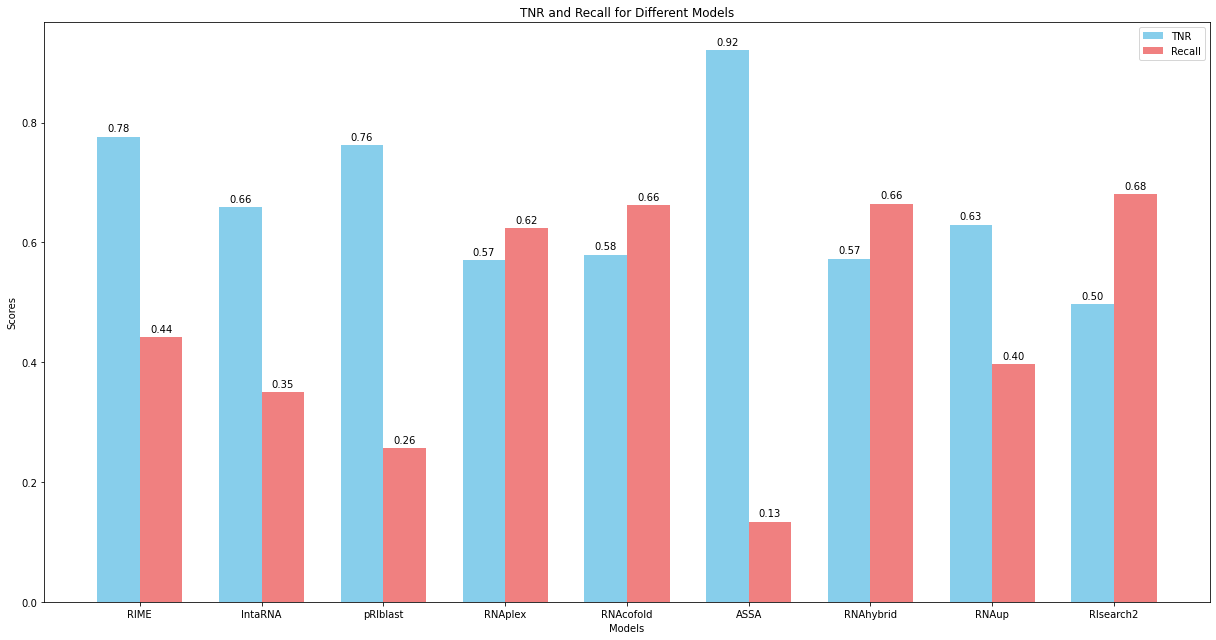

splash interactors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


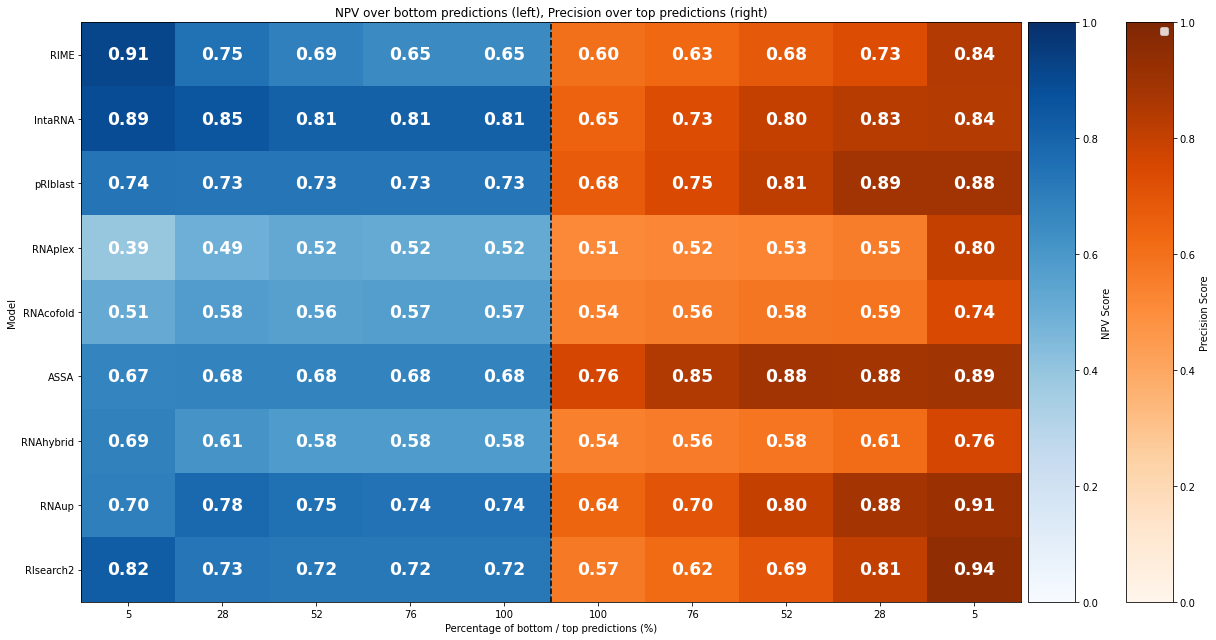

splash patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


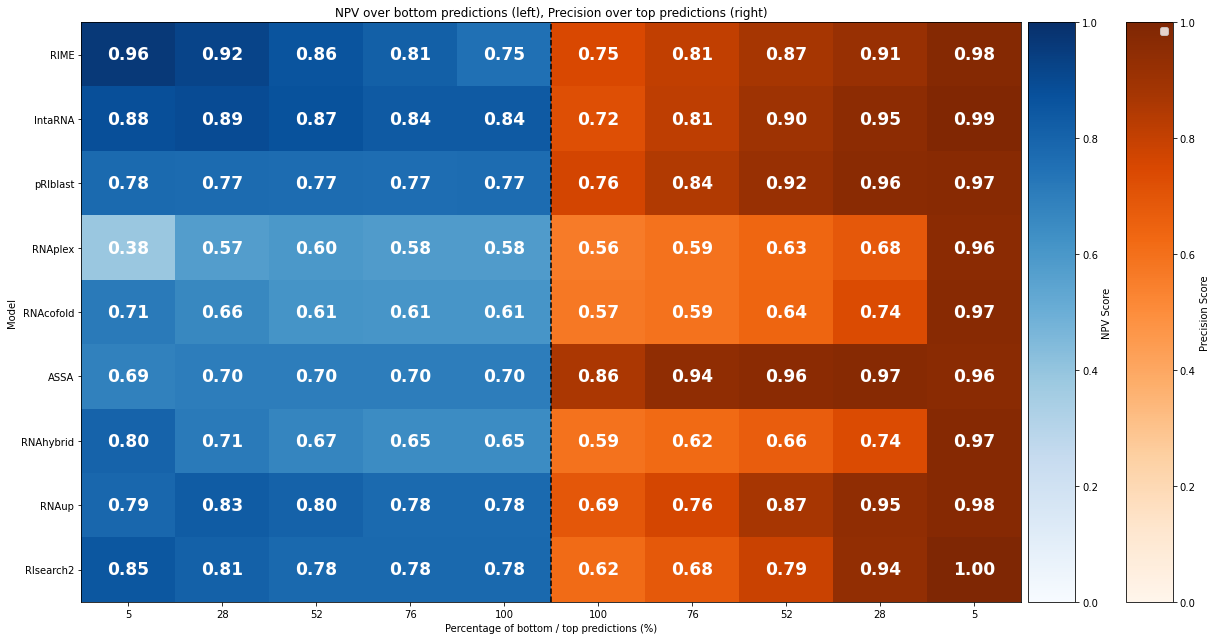

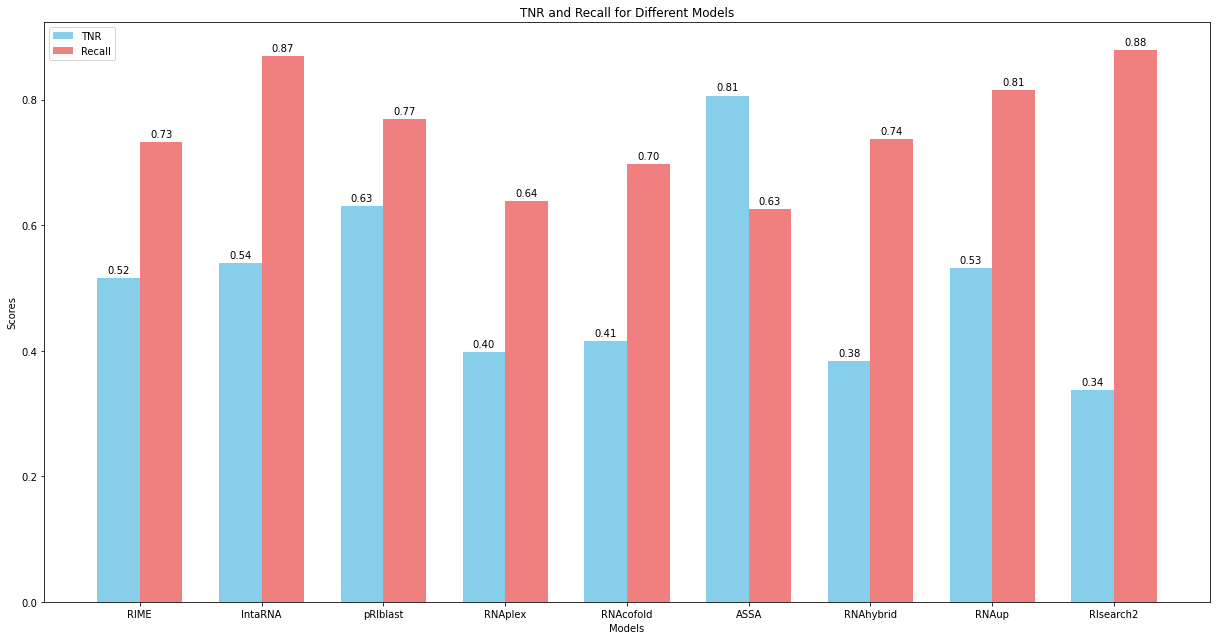

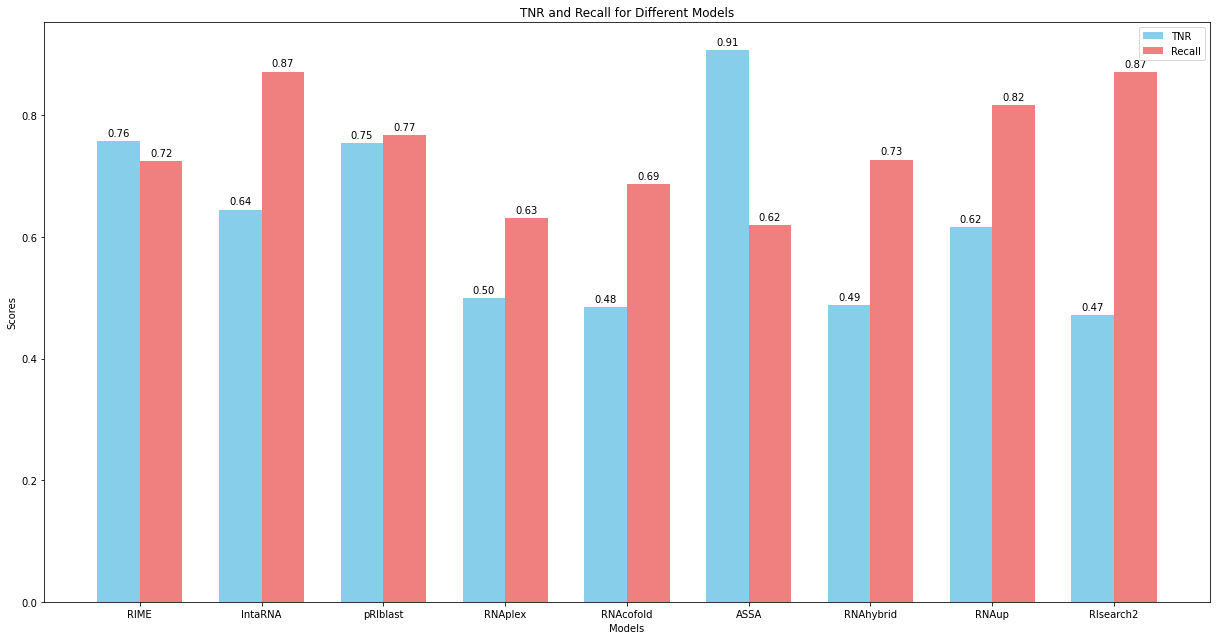

In [38]:
# for dataset in list_of_datasets:
    
#     experiment, specie_paris, paris_hq_threshold, n_reads_ricseq, n_reads_paris, interlen_OR_nreads_paris, paris_test = map_dataset_to_hp(dataset)
    
#     if dataset in ['parisHQ', 'paris_mouse_HQ', 'ricseqHQ', 'mario', 'splash']:
#         n_run_undersampling = 50 
#     else:
#         n_run_undersampling = 10
    
#     res = modelRM.get_experiment_data(
#         experiment = experiment, 
#         paris_test = paris_test, 
#         paris_finetuned_model = PARIS_FINETUNED_MODEL, 
#         specie_paris = specie_paris,
#         paris_hq = False,
#         paris_hq_threshold = paris_hq_threshold,
#         n_reads_paris = n_reads_paris,
#         interlen_OR_nreads_paris = False,
#         splash_trained_model = False,
#         only_test_splash_ricseq_mario = False,
#         n_reads_ricseq = n_reads_ricseq,
#         logistic_regression_models = logistic_regression_models,
#     )
    
#     easypos_smartneg = res[res.policy.isin(['easypos', 'smartneg'])].reset_index(drop = True)
#     ephnen = res[res.policy.isin(['easypos', 'easyneg', 'hardneg'])].reset_index(drop = True)
    
#     #interactors
#     print(dataset, 'interactors')
#     precision_data, _, model_names = collect_results_based_on_topbottom_for_all_models(easypos_smartneg, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'precision')
#     npv_models, _, model_names = collect_results_based_on_topbottom_for_all_models(easypos_smartneg, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'npv')
#     npv_data = np.array([npv [::-1] for npv in npv_models])
#     npv_precision(precision_data, npv_data, model_names, figsize, MIN_PERC, savepath = os.path.join(plots_dir, f'derbyplot_DRI_{dataset}.pdf'))
    
#     #patches
#     print(dataset, 'patches')
#     precision_data, _, model_names = collect_results_based_on_topbottom_for_all_models(ephnen, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'precision')
#     npv_models, _, model_names = collect_results_based_on_topbottom_for_all_models(ephnen, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'npv')
#     npv_data = np.array([npv [::-1] for npv in npv_models])
#     npv_precision(precision_data, npv_data, model_names, figsize, MIN_PERC, savepath = os.path.join(plots_dir, f'derbyplot_DRP_{dataset}.pdf'))
    
#     plot_tnr_recall_for_all_models(list_of_models_to_test, balancing_only_for_one_task(res, task = 'interactors'), figsize, bar_width=0.35)
#     plot_tnr_recall_for_all_models(list_of_models_to_test, balancing_only_for_one_task(res, task = 'patches'), figsize, bar_width=0.35)

#### Merging patches and interactors

In [20]:
# for dataset in list_of_datasets:
    
#     experiment, specie_paris, paris_hq_threshold, n_reads_ricseq, n_reads_paris, interlen_OR_nreads_paris, paris_test = map_dataset_to_hp(dataset)
    
#     if dataset in ['parisHQ', 'paris_mouse_HQ', 'ricseqHQ', 'mario', 'splash']:
#         n_run_undersampling = 50 
#     else:
#         n_run_undersampling = 10
    
#     res = modelRM.get_experiment_data(
#         experiment = experiment, 
#         paris_test = paris_test, 
#         paris_finetuned_model = PARIS_FINETUNED_MODEL, 
#         specie_paris = specie_paris,
#         paris_hq = paris_hq_threshold,
#         paris_hq_threshold = 1,
#         n_reads_paris = n_reads_paris,
#         interlen_OR_nreads_paris = False,
#         splash_trained_model = False,
#         only_test_splash_ricseq_mario = False,
#         n_reads_ricseq = n_reads_ricseq,
#         logistic_regression_models = logistic_regression_models,
#     )
    
#     print(f'dataset: {dataset}')
    
#     precision_data, _, model_names, perc_sn_prec, perc_hn_prec, perc_en_prec = collect_results_based_on_topbottom_for_all_models_perc_neg(res, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'precision')
#     npv_models, _, model_names, perc_sn_npv, perc_hn_npv, perc_en_npv = collect_results_based_on_topbottom_for_all_models_perc_neg(res, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'npv')
    
#     npv_data = np.array([npv [::-1] for npv in npv_models])
#     perc_sn_npv = np.array([npv [::-1] for npv in perc_sn_npv])
#     perc_hn_npv = np.array([npv [::-1] for npv in perc_hn_npv])
#     perc_en_npv = np.array([npv [::-1] for npv in perc_en_npv])
    
#     npv_precision(precision_data, npv_data, model_names, figsize, MIN_PERC)     
#     perc_neg_npv_precision(perc_sn_prec, perc_hn_prec, perc_en_prec, perc_sn_npv, perc_hn_npv, perc_en_npv, model_names, 'nt', figsize, min_perc = 1)
#     plot_tnr_recall_for_all_models(list_of_models_to_test, balancing_only_for_one_task(res, task = 'all'), figsize, bar_width=0.35)

### 1 plot only RIME 

In [15]:
shorter_datasets = ['psoralen', 'ricseq', 'mario']

prec_dri_list = []
npv_dri_list = []
prec_drp_list = []
npv_drp_list = []

for dataset in shorter_datasets:
    
    experiment, specie_paris, paris_hq_threshold, n_reads_ricseq, n_reads_paris, interlen_OR_nreads_paris, paris_test = map_dataset_to_hp(dataset)
    
    if dataset in ['parisHQ', 'paris_mouse_HQ', 'ricseqHQ', 'mario', 'splash']:
        n_run_undersampling = 50 
    else:
        n_run_undersampling = 10
    
    res = modelRM.get_experiment_data(
        experiment = experiment, 
        paris_test = paris_test, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = specie_paris,
        paris_hq = False,
        paris_hq_threshold = paris_hq_threshold,
        n_reads_paris = n_reads_paris,
        interlen_OR_nreads_paris = False,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = n_reads_ricseq,
        logistic_regression_models = logistic_regression_models,
    )
    
    easypos_smartneg = res[res.policy.isin(['easypos', 'smartneg'])].reset_index(drop = True)
    ephnen = res[res.policy.isin(['easypos', 'easyneg', 'hardneg'])].reset_index(drop = True)
    
    #interactors
    print(dataset, 'interactors')
    precision_data, _, model_names = collect_results_based_on_topbottom_for_all_models(easypos_smartneg, MIN_PERC, ['nt'], n_values, n_run_undersampling, 'precision')
    npv_models, _, model_names = collect_results_based_on_topbottom_for_all_models(easypos_smartneg, MIN_PERC, ['nt'], n_values, n_run_undersampling, 'npv')
    prec_dri_list.append(precision_data[0])
    npv_dri_list.append(npv_models[0])
    npv_data = np.array([npv [::-1] for npv in npv_models])
    
    #patches
    print(dataset, 'patches')
    precision_data, _, model_names = collect_results_based_on_topbottom_for_all_models(ephnen, MIN_PERC, ['nt'], n_values, n_run_undersampling, 'precision')
    npv_models, _, model_names = collect_results_based_on_topbottom_for_all_models(ephnen, MIN_PERC, ['nt'], n_values, n_run_undersampling, 'npv')
    prec_drp_list.append(precision_data[0])
    npv_drp_list.append(npv_models[0])
    npv_data = np.array([npv [::-1] for npv in npv_models])
    
    
# npv_precision(precision_data, npv_data, model_names, figsize, MIN_PERC, savepath = os.path.join(plots_dir, f'derbyplot_DRI_{dataset}.pdf'))
# npv_precision(precision_data, npv_data, model_names, figsize, MIN_PERC, savepath = os.path.join(plots_dir, f'derbyplot_DRP_{dataset}.pdf'))

# plot_tnr_recall_for_all_models(list_of_models_to_test, balancing_only_for_one_task(res, task = 'interactors'), figsize, bar_width=0.35)
# plot_tnr_recall_for_all_models(list_of_models_to_test, balancing_only_for_one_task(res, task = 'patches'), figsize, bar_width=0.35)

psoralen interactors
psoralen patches
ricseq interactors
ricseq patches
mario interactors
mario patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


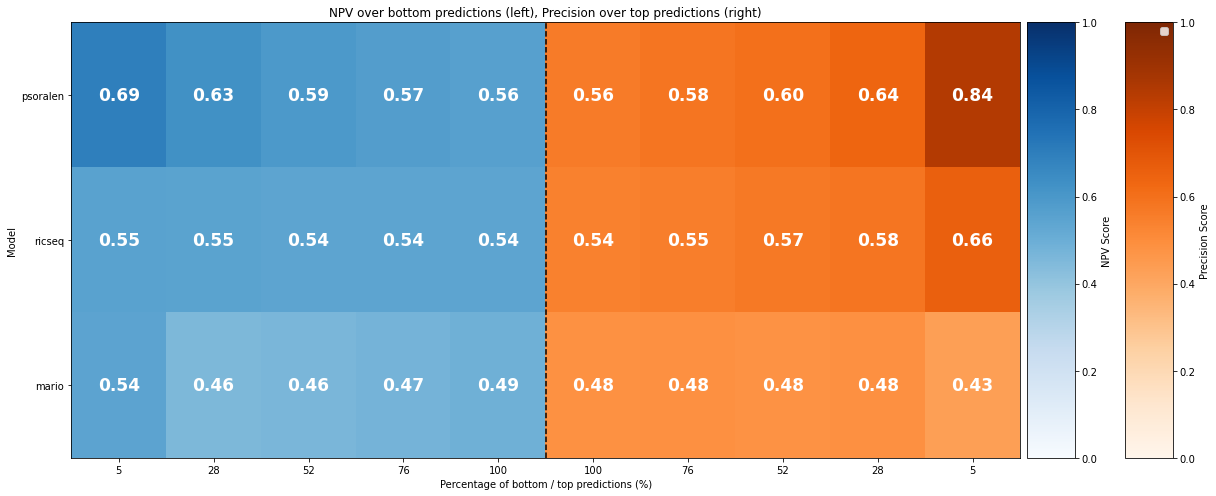

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


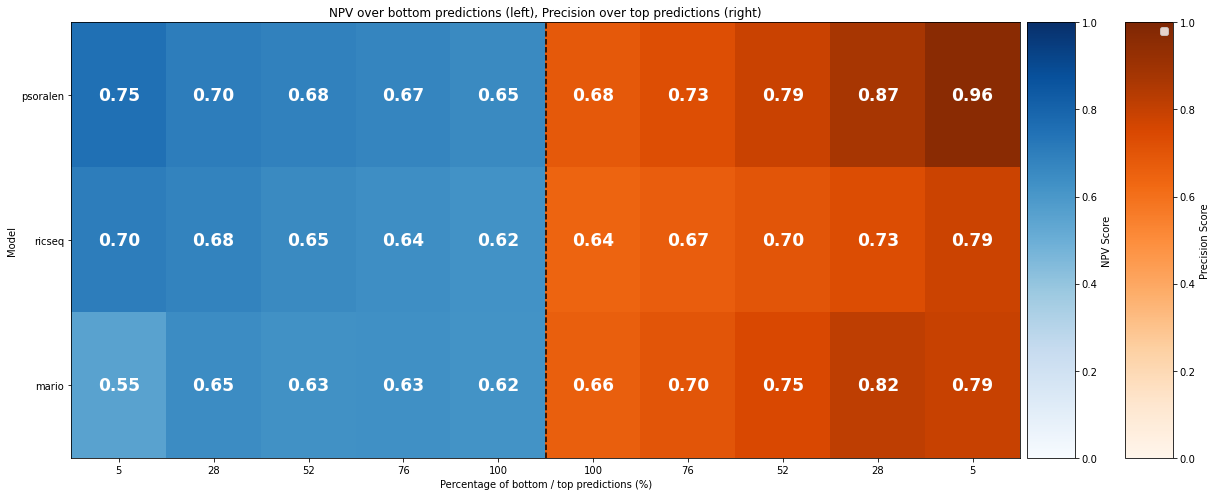

In [16]:
npv_precision(np.array(prec_dri_list), np.array([npv [::-1] for npv in npv_dri_list]), shorter_datasets, figsize, MIN_PERC, savepath = os.path.join(plots_dir, f'derbyplot_DRI_RIME.pdf'))
npv_precision(np.array(prec_drp_list), np.array([npv [::-1] for npv in npv_drp_list]), shorter_datasets, figsize, MIN_PERC, savepath = os.path.join(plots_dir, f'derbyplot_DRP_RIME.pdf'))

In [17]:
corr_perf_conf = calc_corr_perf_conf(prec_dri_list, npv_dri_list, prec_drp_list, npv_drp_list, shorter_datasets)

### Ricseq AUC increase with higher n_reads

In [18]:
filter_neg_by_HQ = False

In [19]:
dfs = []

n_positives_run = []

pos_score = []

list_of_n_reads_ricseq = [2,3,4,5,6,7,8] #[2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,19,20] #[2,3,4,5,6,7,8, 9, 10] #[2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,19,20]

for n_reads_ricseq in list_of_n_reads_ricseq:
    
    res = modelRM.get_experiment_data(
        experiment = 'ricseq', 
        paris_test = np.nan, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = np.nan,
        paris_hq = np.nan,
        paris_hq_threshold = np.nan,
        n_reads_paris = np.nan,
        interlen_OR_nreads_paris = False,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = n_reads_ricseq,
        logistic_regression_models = {},
    )
    
    
    enhn, easypos_smartneg = obtain_enhn_easypos_smartneg(res, filter_neg_by_HQ = filter_neg_by_HQ)
    
    pos = res[res.policy == 'easypos'].reset_index(drop = True)
    
    print(f'# total positive samples for N_reads >= {n_reads_ricseq}: \n {res[(res.ground_truth == 1)].shape[0]}')
    
    
    
    n_positives_run.append(pos.shape[0])
    
    pos_score.append(list(pos.probability))
    
    dfs.append(obtain_all_model_auc(easypos_smartneg, energy_columns).rename({'auc': f'auc_interactors_ricseq_nread{n_reads_ricseq}'}, axis = 1))
    dfs.append(obtain_all_model_auc(enhn, energy_columns).rename({'auc': f'auc_patches_ricseq_nread{n_reads_ricseq}'}, axis = 1))
    
df_auc = pd.concat(dfs, axis = 1)
df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()
df_auc['model_name'] = df_auc['model_name'].apply(map_model_names)
df_auc = df_auc.drop_duplicates().reset_index(drop=True)

# total positive samples for N_reads >= 2: 
 8978
# total positive samples for N_reads >= 3: 
 850
# total positive samples for N_reads >= 4: 
 161
# total positive samples for N_reads >= 5: 
 73
# total positive samples for N_reads >= 6: 
 41
# total positive samples for N_reads >= 7: 
 23
# total positive samples for N_reads >= 8: 
 17


In [20]:
# Calculate rho quality VS performance
corr_ricseq_quality_perf = calc_corr_quality_perf(df_auc, 'ricseq_nread', list_of_n_reads_ricseq, corr = 'pearson')
corr_ricseq_quality_perf

DRI_AUC   DRP_AUC  ricseq_nread
DRI_AUC       1.000000  0.995459      0.842023
DRP_AUC       0.995459  1.000000      0.879599
ricseq_nread  0.842023  0.879599      1.000000

In [21]:
# Calculate rho quality VS confidence
corr_ricseq_quality_confidence = calc_corr_quality_conf(pos_score, 'ricseq_nread', list_of_n_reads_ricseq, 'pearson')
corr_ricseq_quality_confidence

mean_pos_score  ricseq_nread
mean_pos_score        1.000000      0.797365
ricseq_nread          0.797365      1.000000

#### Plot

TASK:  interactors


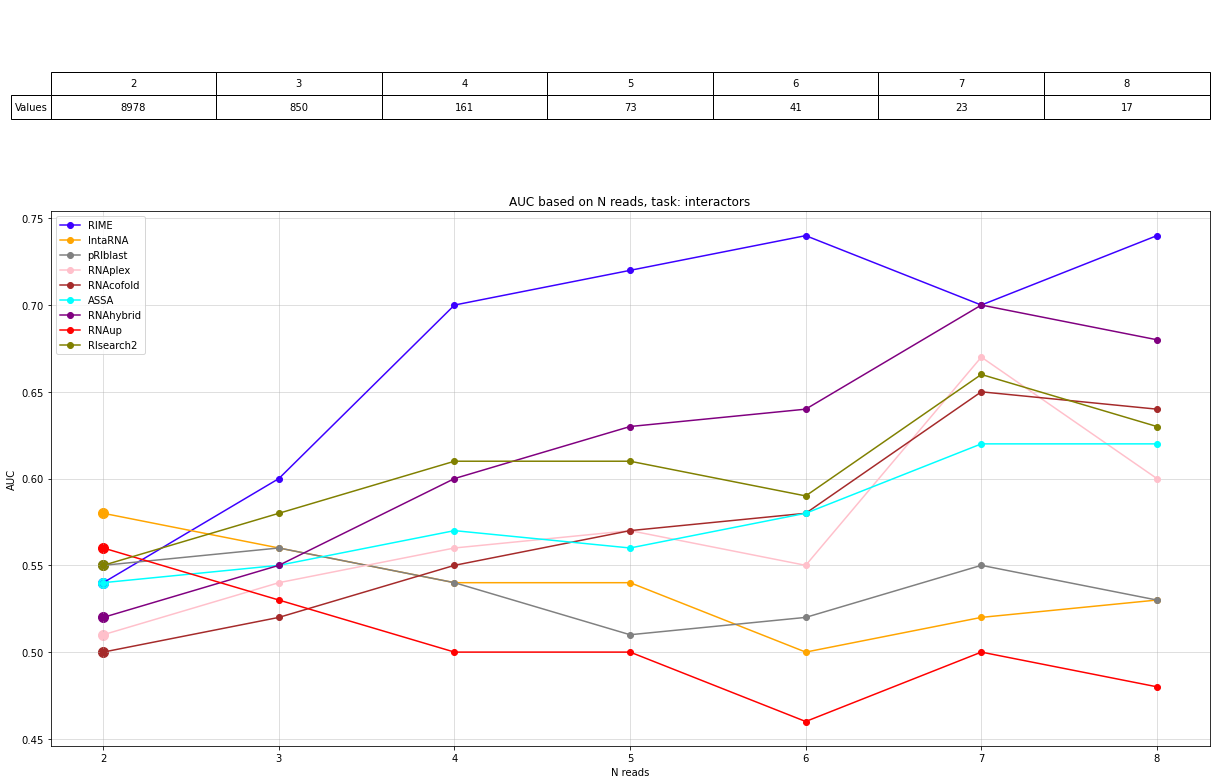




TASK:  patches


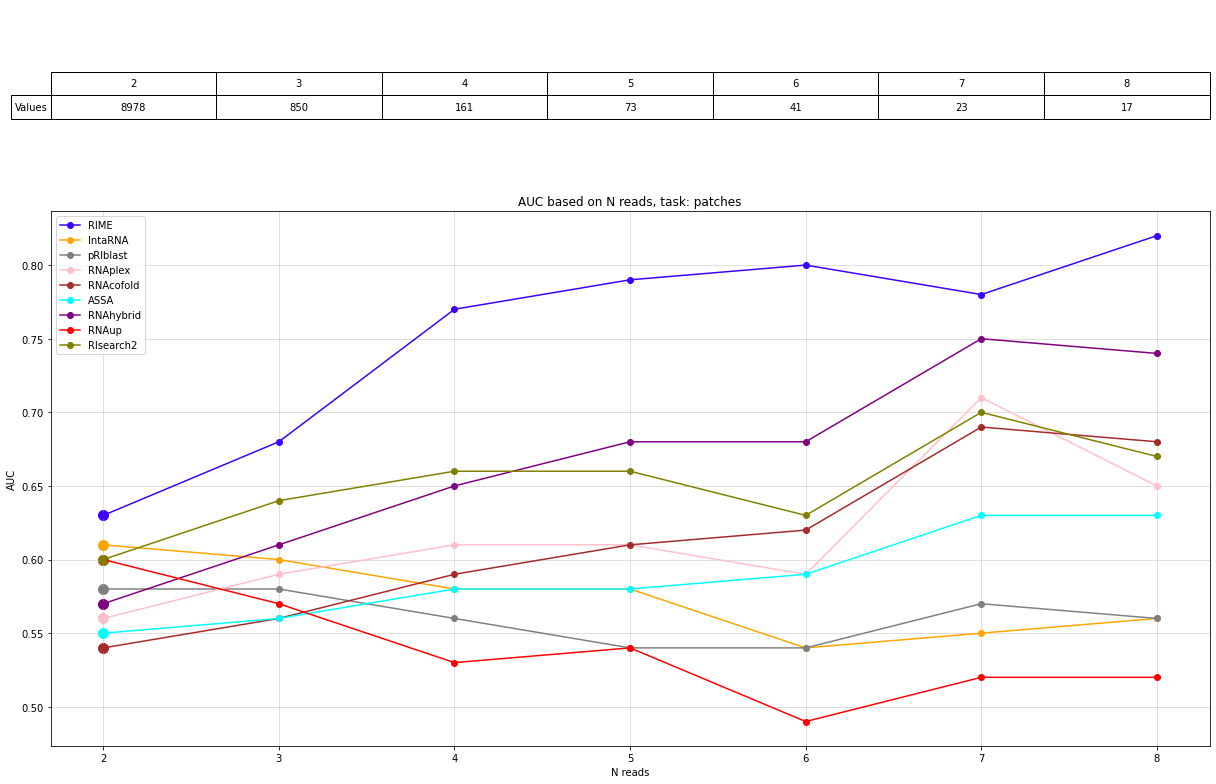

In [22]:
plot_metric_confidence_for_all_models_for_2tasks(df_auc, list_of_n_reads_ricseq, n_positives_run, 'ricseq_nread', size_multiplier = 1, metric = 'AUC', string_label = 'N reads', figsize = (17,11), savepath = os.path.join(plots_dir, 'quality_performance_ricseq.pdf'))

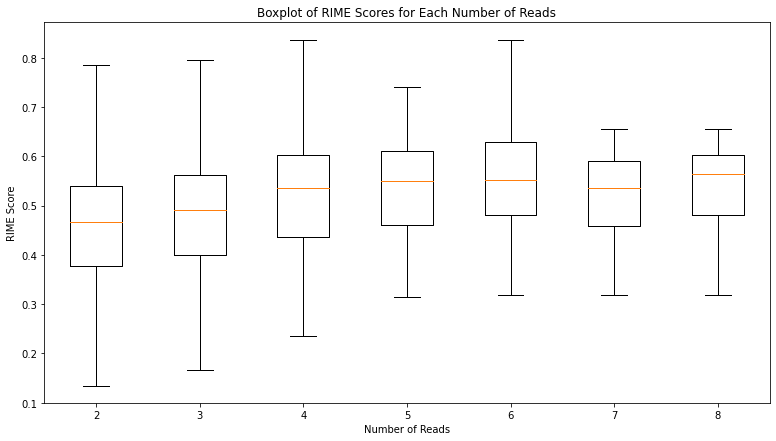

In [23]:
plot_qualityVSconfidence(list_of_n_reads_ricseq, pos_score, variable='Number of Reads', figsize=(13, 7), savepath =  os.path.join(plots_dir, f'confidence_quality_ricseq.pdf'))

# PARIS HQ

Correlation between log(interaction size) and n_reads: 0.16
Correlation between log(interaction size) and probability: 0.12
Correlation between n_reads and probability: 0.03


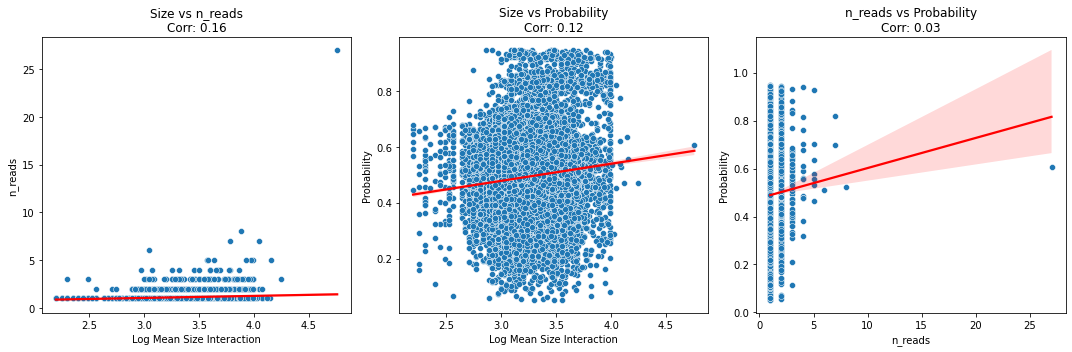

In [12]:
filter_neg_by_HQ = False

plot_correlation_nreads_prob_intsize(modelRM, PARIS_FINETUNED_MODEL)

### Paris AUC increase with higher n_reads

In [20]:
SPECIE = 'human'

dfs = []

n_positives_run = []
pos_score = []

list_of_n_reads_paris = [1,2,3,4,5] #[2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,19,20] #[2,3,4,5,6,7,8, 9, 10] #[2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,19,20]

for n_reads_paris in list_of_n_reads_paris:
    
    res = modelRM.get_experiment_data(
        experiment = 'paris', 
        paris_test = True, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = SPECIE,
        paris_hq = False,
        paris_hq_threshold = 1,
        n_reads_paris = n_reads_paris,
        interlen_OR_nreads_paris = False,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = np.nan,
        n_reads_ricseq = np.nan,
        logistic_regression_models = {},
    )
    
    enhn, easypos_smartneg = obtain_enhn_easypos_smartneg(res, filter_neg_by_HQ = filter_neg_by_HQ)
    
    print(f'# total positive samples for N_reads >= {n_reads_paris}: \n {res[(res.ground_truth == 1)].specie.value_counts()}')
    
    pos = easypos_smartneg[easypos_smartneg.policy == 'easypos'].reset_index(drop = True)
    n_positives_run.append(pos.shape[0])
    pos_score.append(list(pos.probability))
    
    dfs.append(obtain_all_model_auc(easypos_smartneg, energy_columns).rename({'auc': f'auc_interactors_paris_nread{n_reads_paris}'}, axis = 1))
    dfs.append(obtain_all_model_auc(enhn, energy_columns).rename({'auc': f'auc_patches_paris_nread{n_reads_paris}'}, axis = 1))
    
df_auc = pd.concat(dfs, axis = 1)
df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()
df_auc['model_name'] = df_auc['model_name'].apply(map_model_names)
df_auc = df_auc.drop_duplicates().reset_index(drop=True)

# total positive samples for N_reads >= 1: 
 human    9531
Name: specie, dtype: int64
# total positive samples for N_reads >= 2: 
 human    752
Name: specie, dtype: int64
# total positive samples for N_reads >= 3: 
 human    64
Name: specie, dtype: int64
# total positive samples for N_reads >= 4: 
 human    17
Name: specie, dtype: int64
# total positive samples for N_reads >= 5: 
 human    5
Name: specie, dtype: int64


In [21]:
if SPECIE == 'all':
    # Calculate rho quality VS performance
    corr_paris_quality_perf = calc_corr_quality_perf(df_auc, 'paris_nread', list_of_n_reads_paris, corr = 'pearson')
    # Calculate rho quality VS confidence
    corr_paris_quality_confidence = calc_corr_quality_conf(pos_score, 'paris_nread', list_of_n_reads_paris, 'pearson')

TASK:  interactors


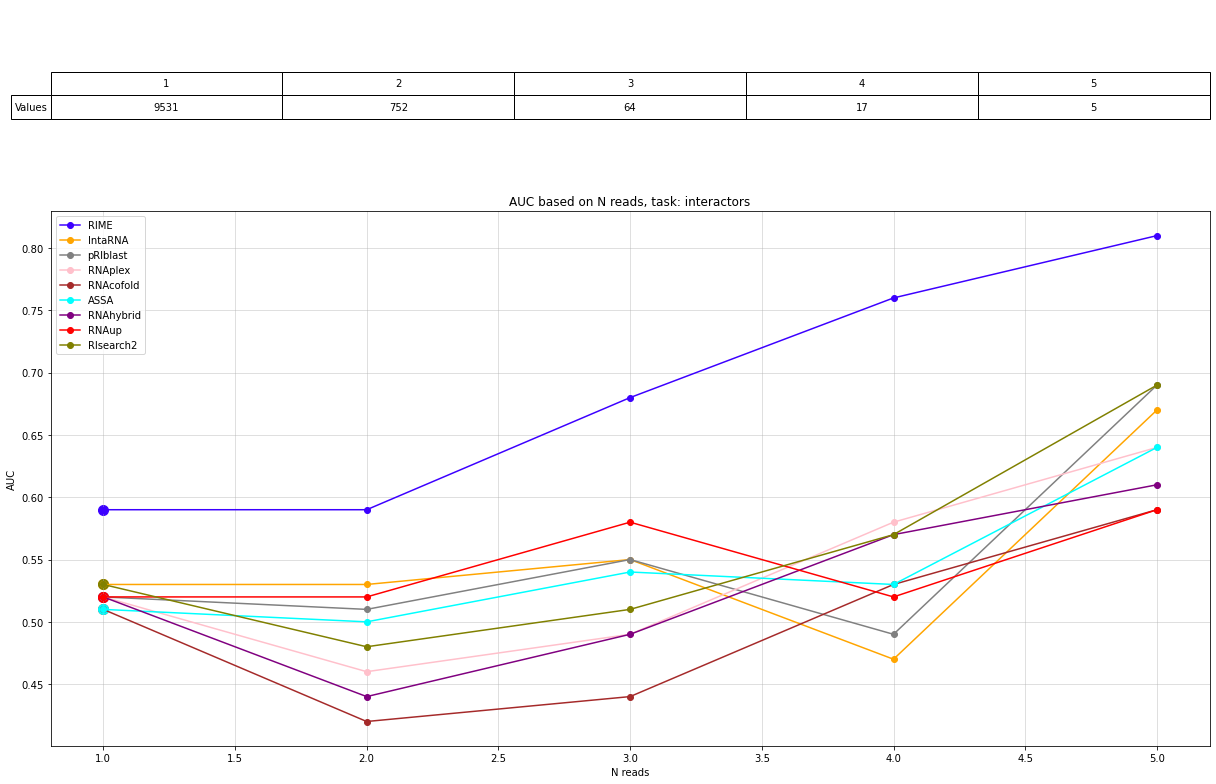




TASK:  patches


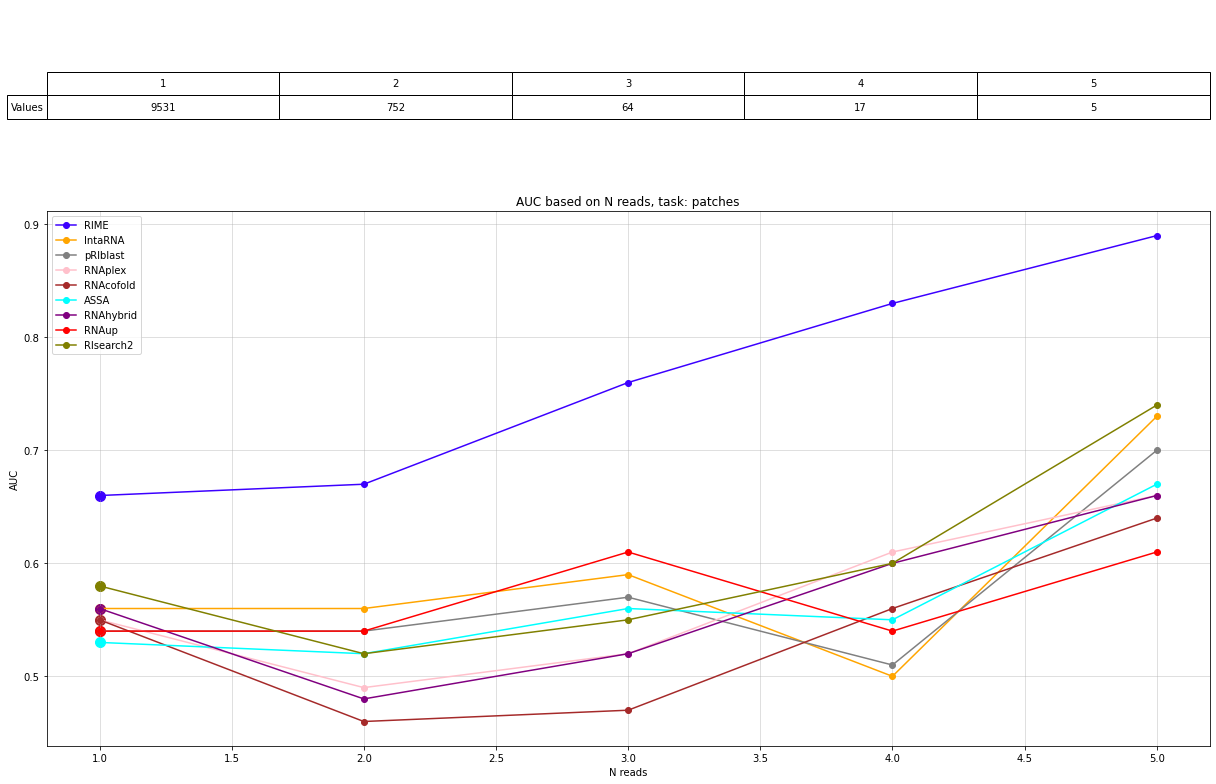

In [22]:
plot_metric_confidence_for_all_models_for_2tasks(df_auc, list_of_n_reads_paris, n_positives_run, 'paris_nread', size_multiplier = 1, metric = 'AUC', string_label = 'N reads', figsize = (17,11), savepath = os.path.join(plots_dir, f'quality_performance_paris1_{SPECIE}.pdf'))

In [19]:
if SPECIE == 'all':
    plot_qualityVSconfidence(list_of_n_reads_paris, pos_score, variable='Number of Reads', figsize=(13, 7), savepath =  os.path.join(plots_dir, f'confidence_quality_paris1.pdf'))

### Paris AUC increase with higher interaction length size

###### Il modo in cui carico i dataset tiene conto del fatto che la regione di interazione ha senso filtrarla per lunghezza solo per i positivi e gli smartneg. Quindi per hardneg, easyneg io caricherò tutti i dati non devo filtrare per lunghezza della regione di interazione.

In [23]:
dfs = []

n_positives_run = []
pos_score = []

list_of_paris_hq_tresholds = [15, 20, 25, 30, 35, 40, 45]

for HQ_THRESHOLD in tqdm(list_of_paris_hq_tresholds):
    
    res = modelRM.get_experiment_data(
        experiment = 'paris', 
        paris_test = True, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = SPECIE,
        paris_hq = False,
        paris_hq_threshold = HQ_THRESHOLD,
        n_reads_paris = 1,
        interlen_OR_nreads_paris = False,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = np.nan,
        n_reads_ricseq = np.nan,
        logistic_regression_models = {},
    )
    
    enhn, easypos_smartneg = obtain_enhn_easypos_smartneg(res, filter_neg_by_HQ = filter_neg_by_HQ)
    
    print(f'# total positive samples for interaction size >= {HQ_THRESHOLD}: \n {res[(res.ground_truth == 1)].specie.value_counts()}')
    
    pos = easypos_smartneg[easypos_smartneg.policy == 'easypos'].reset_index(drop = True)
    n_positives_run.append(pos.shape[0])
    pos_score.append(list(pos.probability))

    dfs.append(obtain_all_model_auc(easypos_smartneg, energy_columns).rename({'auc': f'auc_interactors_paris_len{HQ_THRESHOLD}'}, axis = 1))
    dfs.append(obtain_all_model_auc(enhn, energy_columns).rename({'auc': f'auc_patches_paris_len{HQ_THRESHOLD}'}, axis = 1))

df_auc = pd.concat(dfs, axis = 1)
df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()
df_auc['model_name'] = df_auc['model_name'].apply(map_model_names)
df_auc = df_auc.drop_duplicates().reset_index(drop=True)

  0%|          | 0/7 [00:00<?, ?it/s]

# total positive samples for interaction size >= 15: 
 human    9027
Name: specie, dtype: int64
# total positive samples for interaction size >= 20: 
 human    4632
Name: specie, dtype: int64
# total positive samples for interaction size >= 25: 
 human    1798
Name: specie, dtype: int64
# total positive samples for interaction size >= 30: 
 human    819
Name: specie, dtype: int64
# total positive samples for interaction size >= 35: 
 human    379
Name: specie, dtype: int64
# total positive samples for interaction size >= 40: 
 human    167
Name: specie, dtype: int64
# total positive samples for interaction size >= 45: 
 human    67
Name: specie, dtype: int64


In [24]:
if SPECIE == 'all':
    # Calculate rho quality VS performance
    corr_paris_quality_perf2 = calc_corr_quality_perf(df_auc, 'paris_len', list_of_paris_hq_tresholds, corr = 'pearson')
    # Calculate rho quality VS confidence
    corr_paris_quality_confidence2 = calc_corr_quality_conf(pos_score, 'paris_len', list_of_paris_hq_tresholds, 'pearson')

TASK:  interactors


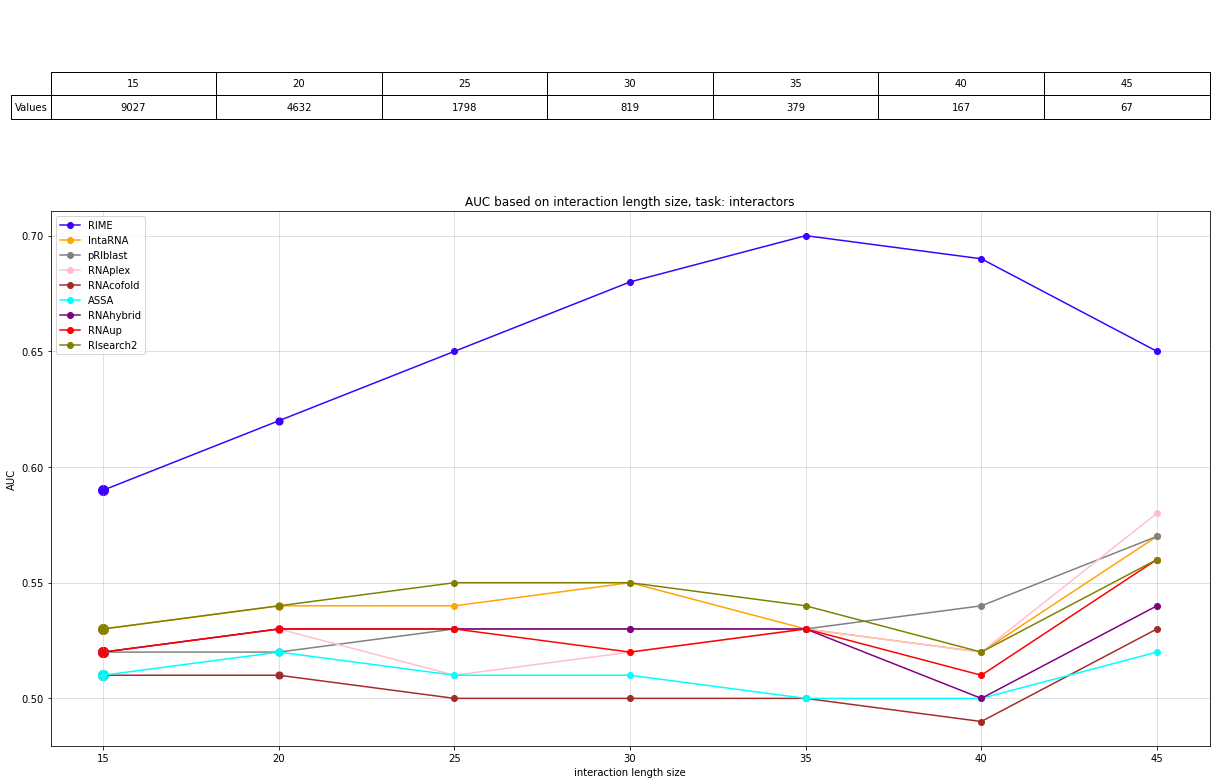




TASK:  patches


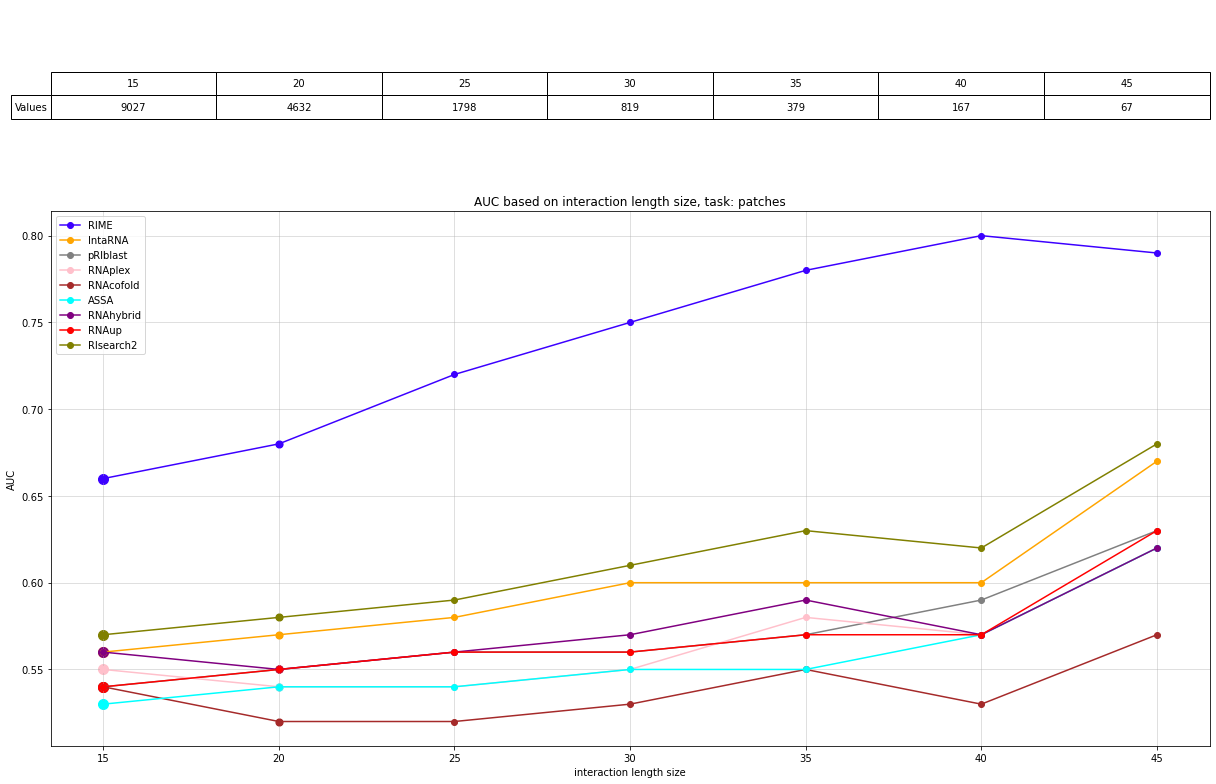

In [25]:
plot_metric_confidence_for_all_models_for_2tasks(df_auc, list_of_paris_hq_tresholds, n_positives_run, 'paris_len', size_multiplier = 1, metric = 'AUC', string_label = 'interaction length size', figsize = (17,11), savepath = os.path.join(plots_dir, f'quality_performance_paris2_{SPECIE}.pdf'))

In [26]:
if SPECIE == 'all':
    plot_qualityVSconfidence(list_of_paris_hq_tresholds, pos_score, variable='Int. Region Length', figsize=(13, 7), savepath = os.path.join(plots_dir, f'confidence_quality_paris2.pdf'))

# Quality VS Performance VS Confidence

In [45]:
rows = []
index = []

In [46]:
#corr_ricseq_quality_confidence, corr_paris_quality_confidence, corr_paris_quality_confidence2

index.append('Quality VS Confidence')

rows.append({
    'Paris':corr_paris_quality_confidence['paris_nread']['mean_pos_score'], 
    'RIC-seq':corr_ricseq_quality_confidence['ricseq_nread']['mean_pos_score'],
})

In [47]:
#corr_ricseq_quality_perf, corr_paris_quality_perf, corr_paris_quality_perf2,

index.append('Quality VS Performance (DRI)')

rows.append({
    'Paris':corr_paris_quality_perf['paris_nread']['DRI_AUC'],
    'RIC-seq':corr_ricseq_quality_perf['ricseq_nread']['DRI_AUC'],
})

index.append('Quality VS Performance (DRP)')

rows.append({
    'Paris':corr_paris_quality_perf['paris_nread']['DRP_AUC'],
    'RIC-seq':corr_ricseq_quality_perf['ricseq_nread']['DRP_AUC'],
})

In [48]:
# corr_perf_conf['paris'][['prec_DRI', 'npv_DRI', 'prec_DRP', 'npv_DRP']]

index.append('Performance VS Confidence (DRI)')

rows.append({
    'Paris':corr_perf_conf['psoralen']['top_values']['prec_DRI'],
    'RIC-seq':corr_perf_conf['ricseq']['top_values']['prec_DRI'],
})

index.append('Performance VS Confidence (DRP)')

rows.append({
    'Paris':corr_perf_conf['psoralen']['top_values']['prec_DRP'],
    'RIC-seq':corr_perf_conf['ricseq']['top_values']['prec_DRP'],
})

In [51]:
corr_QPC = pd.DataFrame(rows, index = index)

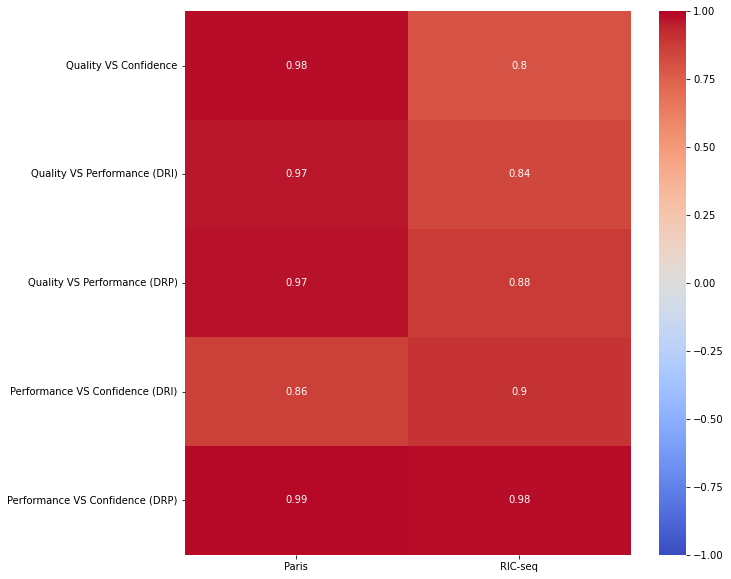

In [52]:
plot_correlations_QPC(corr_QPC, figsize=(10, 10), savepath = os.path.join(plots_dir, 'correlations_QPC.pdf'))

# Ricseq AUC increase with higher n_reads COMPARISON

In [ ]:
names = ['RIME', 'RIMEfull']
df_aucs = []
filter_neg_by_HQ = False
for i, model_name in enumerate(['arch2_PSORALENtrained_PARISval0074', 'arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0086']):
    modelRM = ModelResultsManager(model_name = model_name, 
                                  dimension = 200, 
                                  chkpt_directory = os.path.join(ROOT_DIR, 'checkpoints'), 
                                  rna_rna_files_dir = rna_rna_files_dir, 
                                  test_info_directory = metadata_dir, 
                                  other_tools = [], 
                                  other_tools_dir = external_dataset_dir
                                 )
    
    dfs = []

    n_positives_run = []

    pos_score = []

    list_of_n_reads_ricseq = [2,3,4,5,6,7,8] #[2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,19,20] #[2,3,4,5,6,7,8, 9, 10] #[2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,19,20]

    
    paris_ft_model = False if model_name == 'arch2_PSORALENtrained_PARISval0074' else True
    
    
    for n_reads_ricseq in list_of_n_reads_ricseq:

        res = modelRM.get_experiment_data(
            experiment = 'ricseq', 
            paris_test = np.nan, 
            paris_finetuned_model = paris_ft_model, 
            specie_paris = np.nan,
            paris_hq = np.nan,
            paris_hq_threshold = np.nan,
            n_reads_paris = np.nan,
            interlen_OR_nreads_paris = False,
            splash_trained_model = False,
            only_test_splash_ricseq_mario = False,
            n_reads_ricseq = n_reads_ricseq,
            logistic_regression_models = {},
        )


        enhn, easypos_smartneg = obtain_enhn_easypos_smartneg(res, filter_neg_by_HQ = filter_neg_by_HQ)

        pos = res[res.policy == 'easypos'].reset_index(drop = True)

        print(f'# total positive samples for N_reads >= {n_reads_ricseq}: \n {res[(res.ground_truth == 1)].shape[0]}')



        n_positives_run.append(pos.shape[0])

        pos_score.append(list(pos.probability))

        dfs.append(obtain_all_model_auc(easypos_smartneg, []).rename({'auc': f'auc_interactors_ricseq_nread{n_reads_ricseq}'}, axis = 1))
        dfs.append(obtain_all_model_auc(enhn, []).rename({'auc': f'auc_patches_ricseq_nread{n_reads_ricseq}'}, axis = 1))
        
    df_auc = pd.concat(dfs, axis = 1)
    df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()
    df_auc['model_name'] = names[i]
    df_auc = df_auc.drop_duplicates().reset_index(drop=True)
    
    df_aucs.append(df_auc)

# total positive samples for N_reads >= 2: 
 8991
# total positive samples for N_reads >= 3: 
 855
# total positive samples for N_reads >= 4: 
 162
# total positive samples for N_reads >= 5: 
 73


In [ ]:
plot_metric_confidence_for_all_models_for_2tasks(pd.concat(df_aucs), list_of_n_reads_ricseq, n_positives_run, 'ricseq_nread', size_multiplier = 1, metric = 'AUC', string_label = 'N reads', figsize = (17,11), savepath = os.path.join(plots_dir, 'RIMEvsRIMEfull.pdf'))

# Time speed 

over entropy_TINCR_pulldown

#### Create fasta file

In [31]:
output_path = os.path.join(dataset_files_dir, 'external_dataset', 'check_times', '20sequences.fa')

if os.path.exists(output_path) == False:

    df_genes = pd.read_csv(os.path.join(processed_files_dir, 'df_genes.csv'))
    pt1 = df_genes[(df_genes['length'] > 4500)&(df_genes['length'] < 5960) & (df_genes.gene_biotype == 'protein_coding')].sample(10)
    pt2 = df_genes[(df_genes['length'] > 4500)&(df_genes['length'] < 5960) & (df_genes.gene_biotype != 'protein_coding')].sample(10)

    data = pd.concat([pt1, pt2], axis = 0) 

    with open(output_path, 'w') as fasta_file:
        for _, row in data.iterrows():
            fasta_file.write(f">{row['gene_id']}\n{row['cdna']}\n")

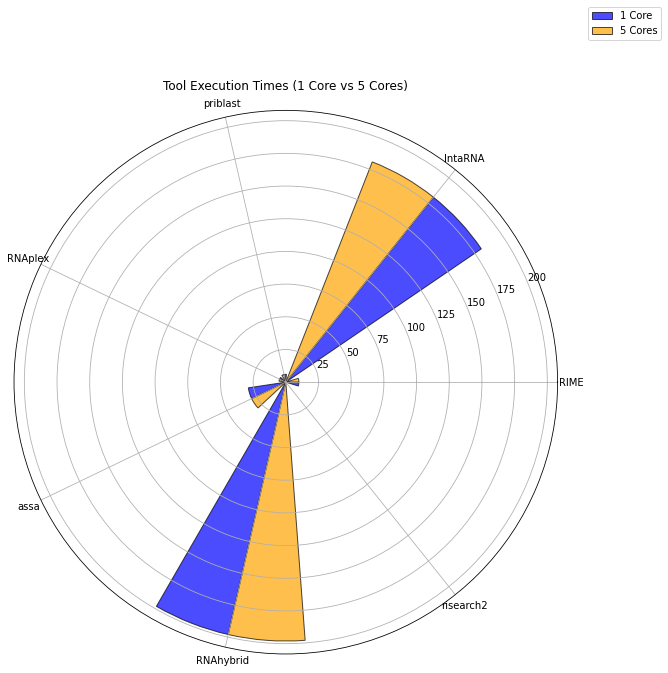

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Data
tools = ['RIME', 'IntaRNA', 'priblast', 'RNAplex', 
         'assa', 'RNAhybrid', 'risearch2']

times_1core = [23, 809, 28, 5.3,
               29, 870, 2.3]
# times_1core = [10, 181, 6, 5.3,
#                29, 198, 0.5]
times_5core = [10, 181, 6, 5.3,
               29, 198, 0.5]

# Number of tools (bins)
n_tools = len(tools)

# Compute angles for each tool
angles = np.linspace(0, 2 * np.pi, n_tools, endpoint=False)

# Bar width
bar_width = 2 * np.pi / n_tools / 3  # Narrower bars for side-by-side comparison

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})

# Plot 1-core times
bars_1core = ax.bar(angles - bar_width / 2, times_1core, width=bar_width, 
                    color='blue', alpha=0.7, edgecolor='black', label='1 Core')

# Plot 5-core times
bars_5core = ax.bar(angles + bar_width / 2, times_5core, width=bar_width, 
                    color='orange', alpha=0.7, edgecolor='black', label='5 Cores')

# Add tool names as labels
ax.set_xticks(angles)
ax.set_xticklabels(tools)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))

# Set title
ax.set_title("Tool Execution Times (1 Core vs 5 Cores)", va='bottom')

# Show the plot
plt.show()